In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util
from bmi_dynamics_code import analyze_lqr

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
#Load a base file for simulation parameters: 
ext_list =['.png', '.eps']

plot_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


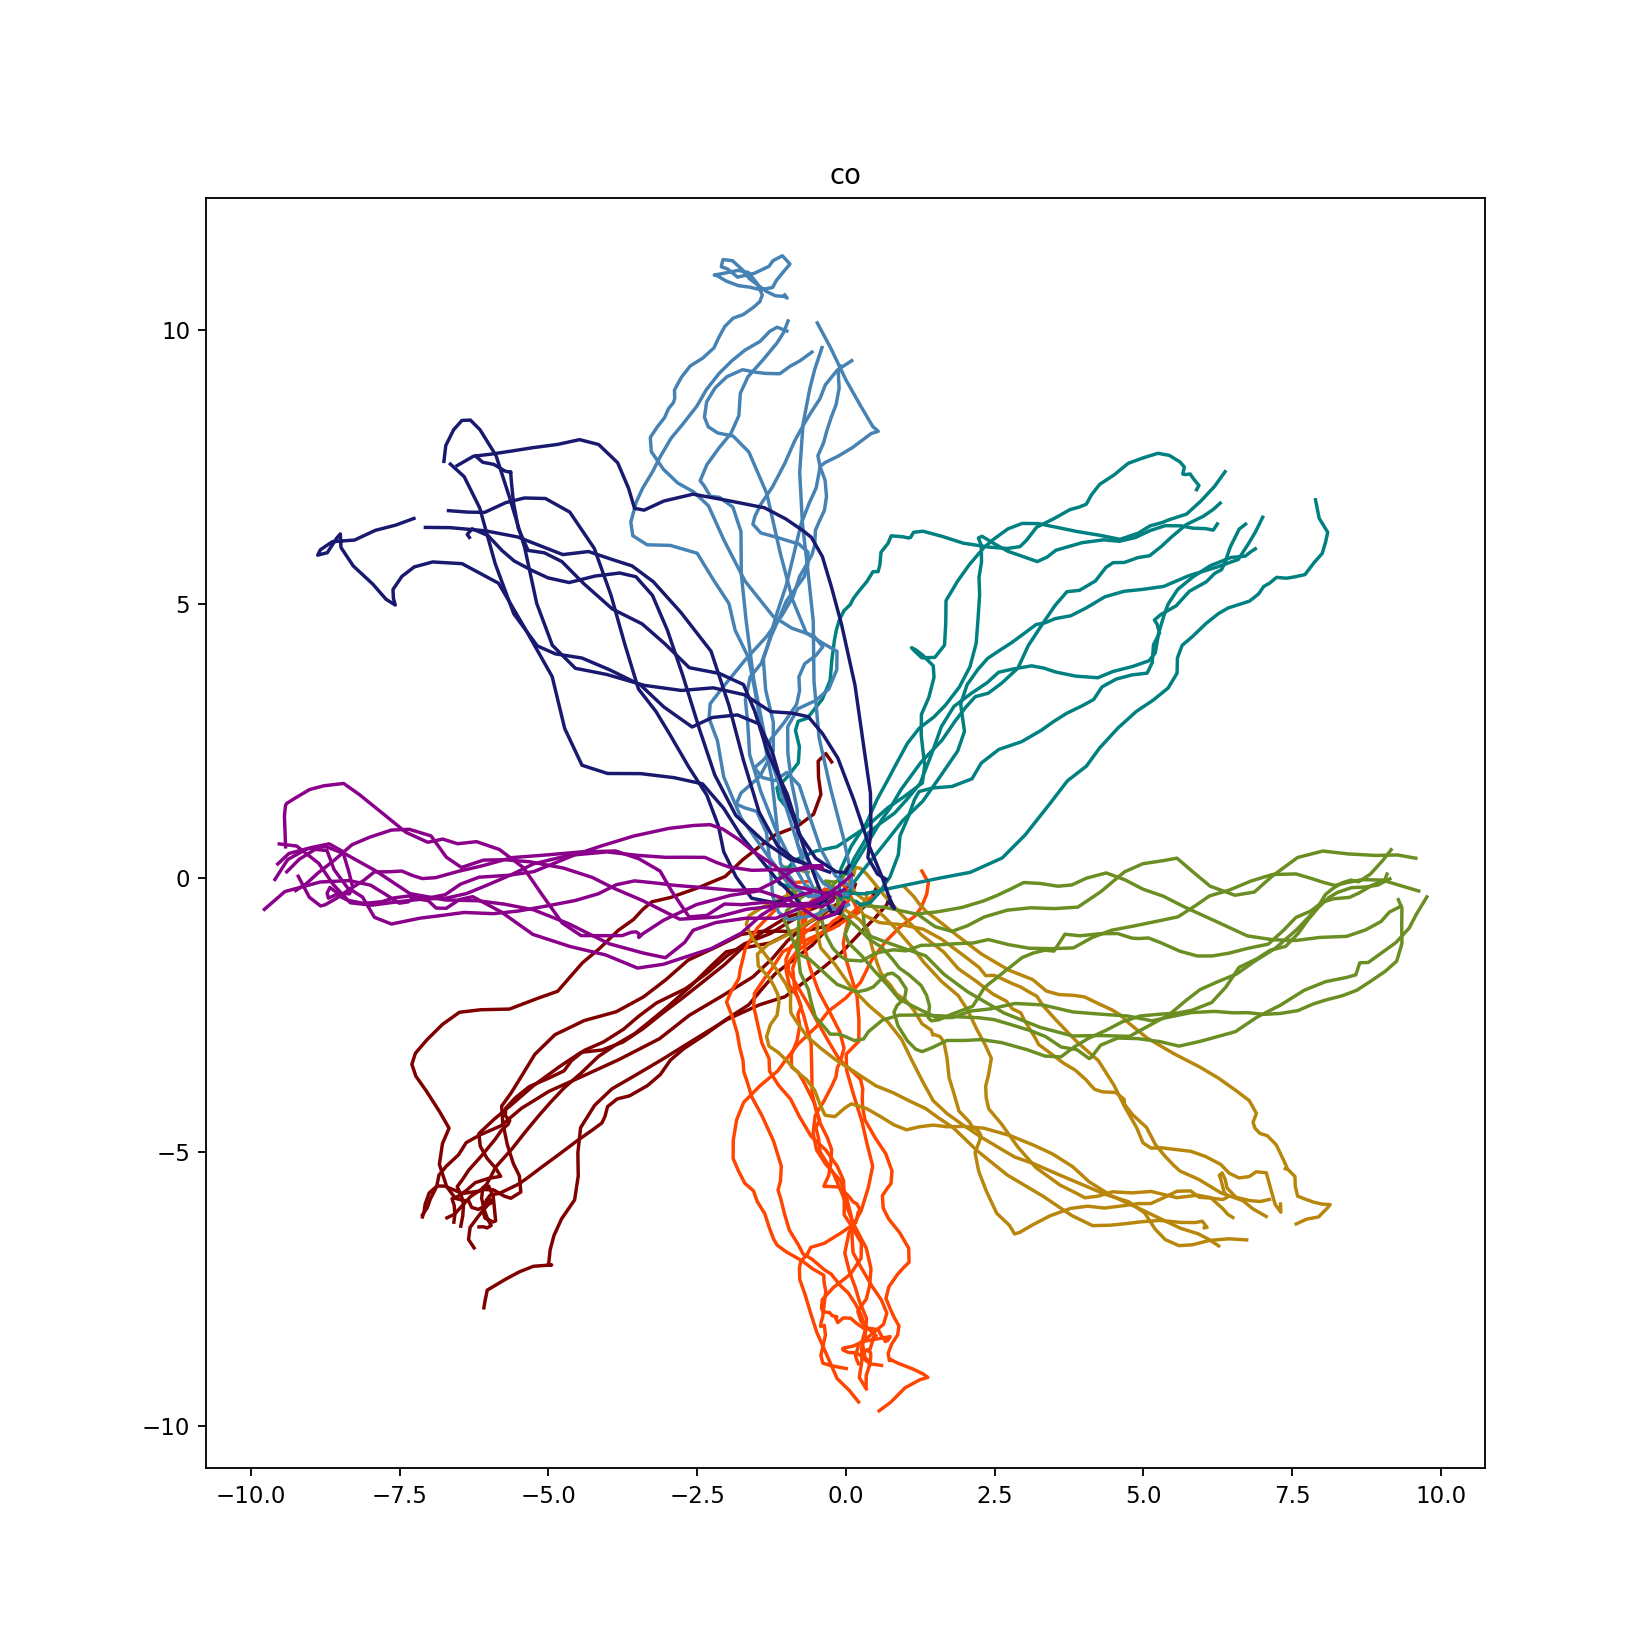

<IPython.core.display.Javascript object>


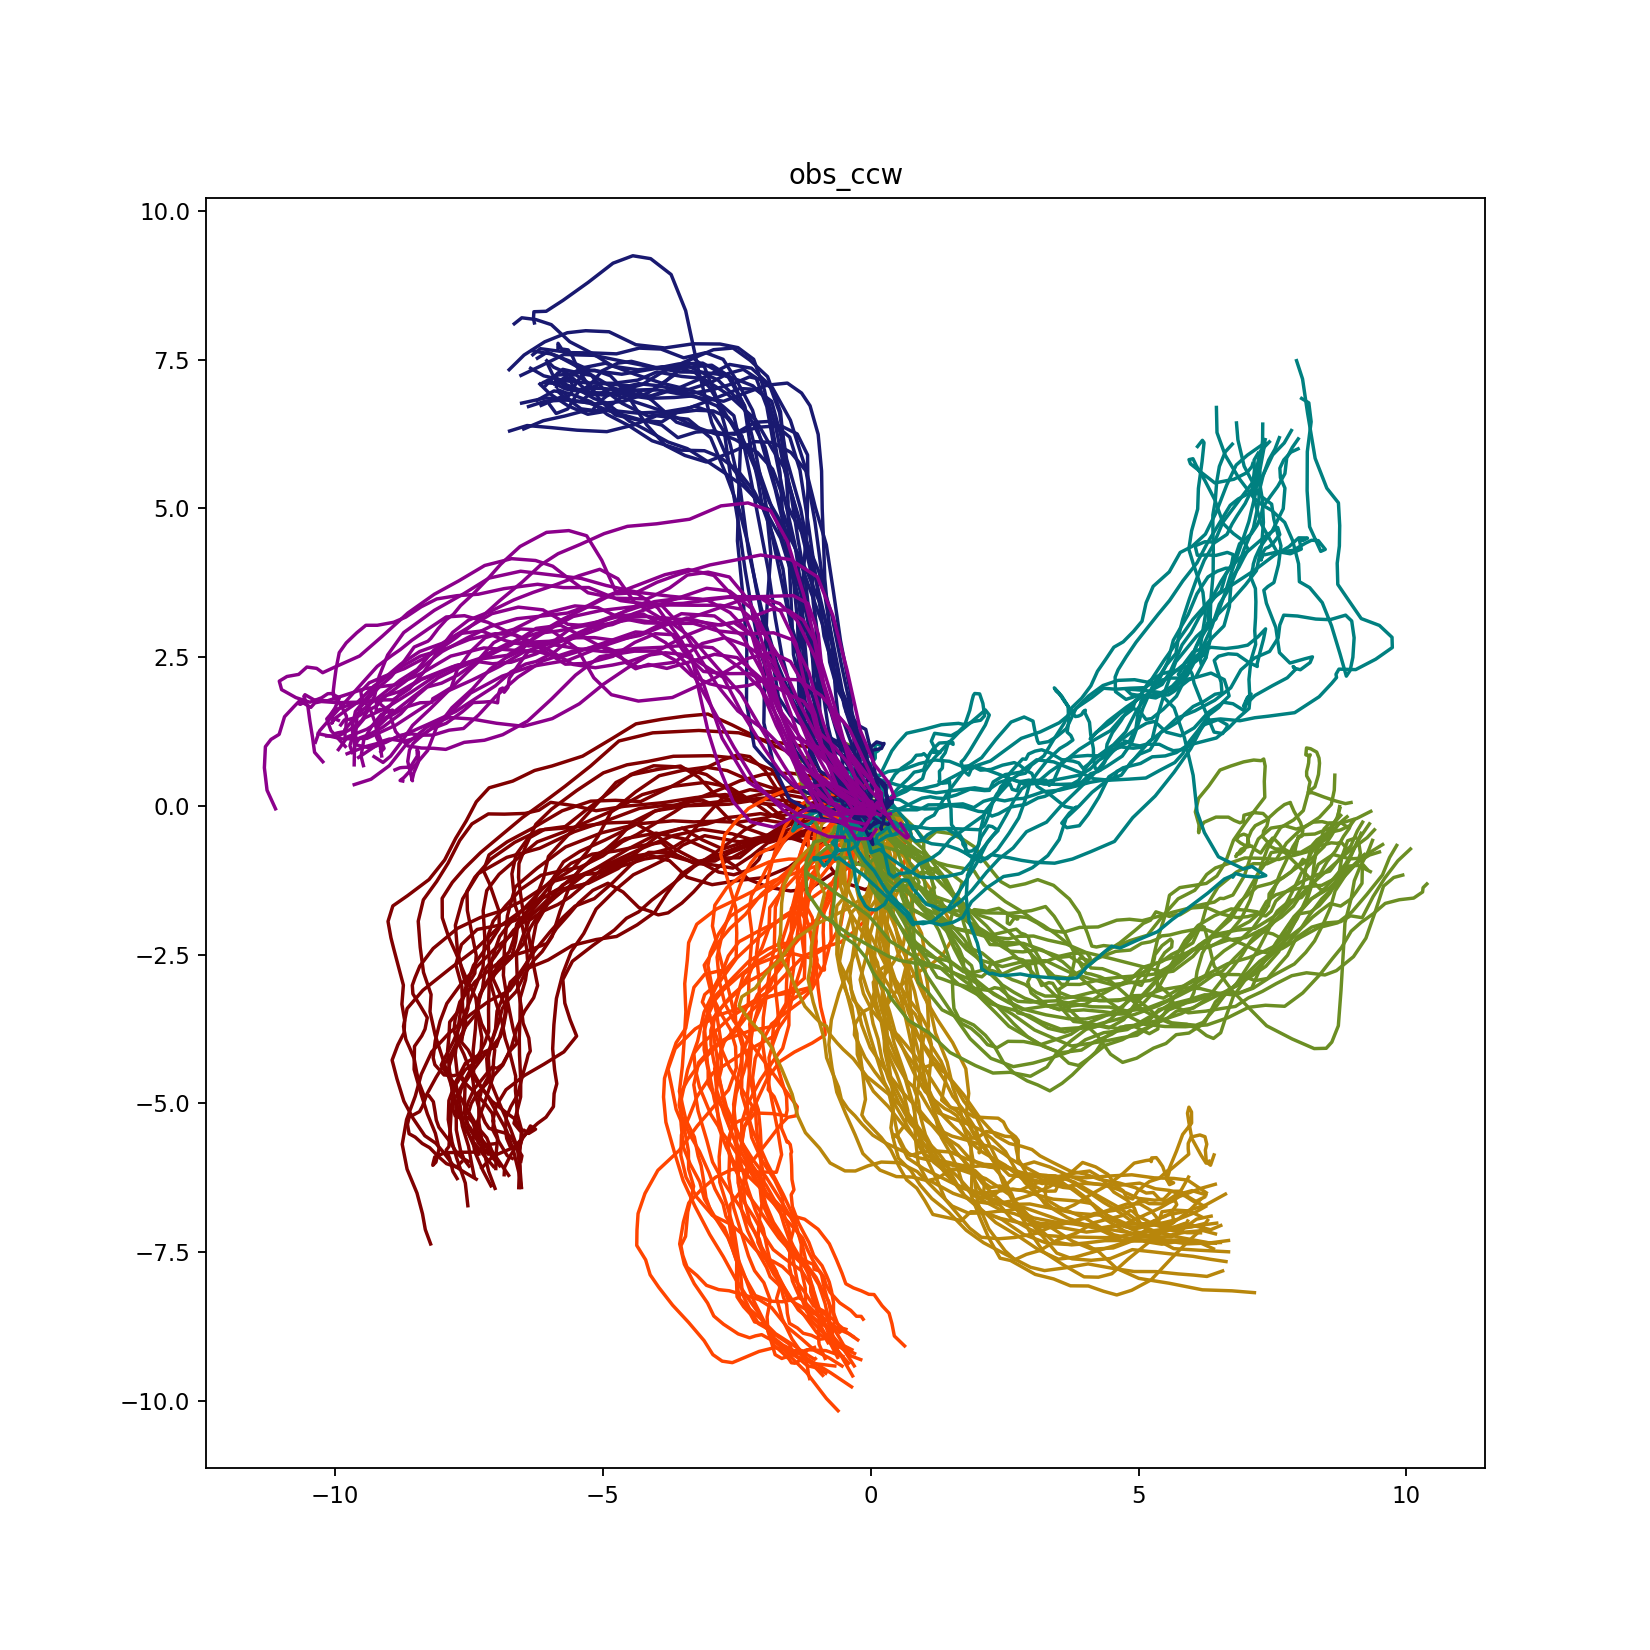

<IPython.core.display.Javascript object>


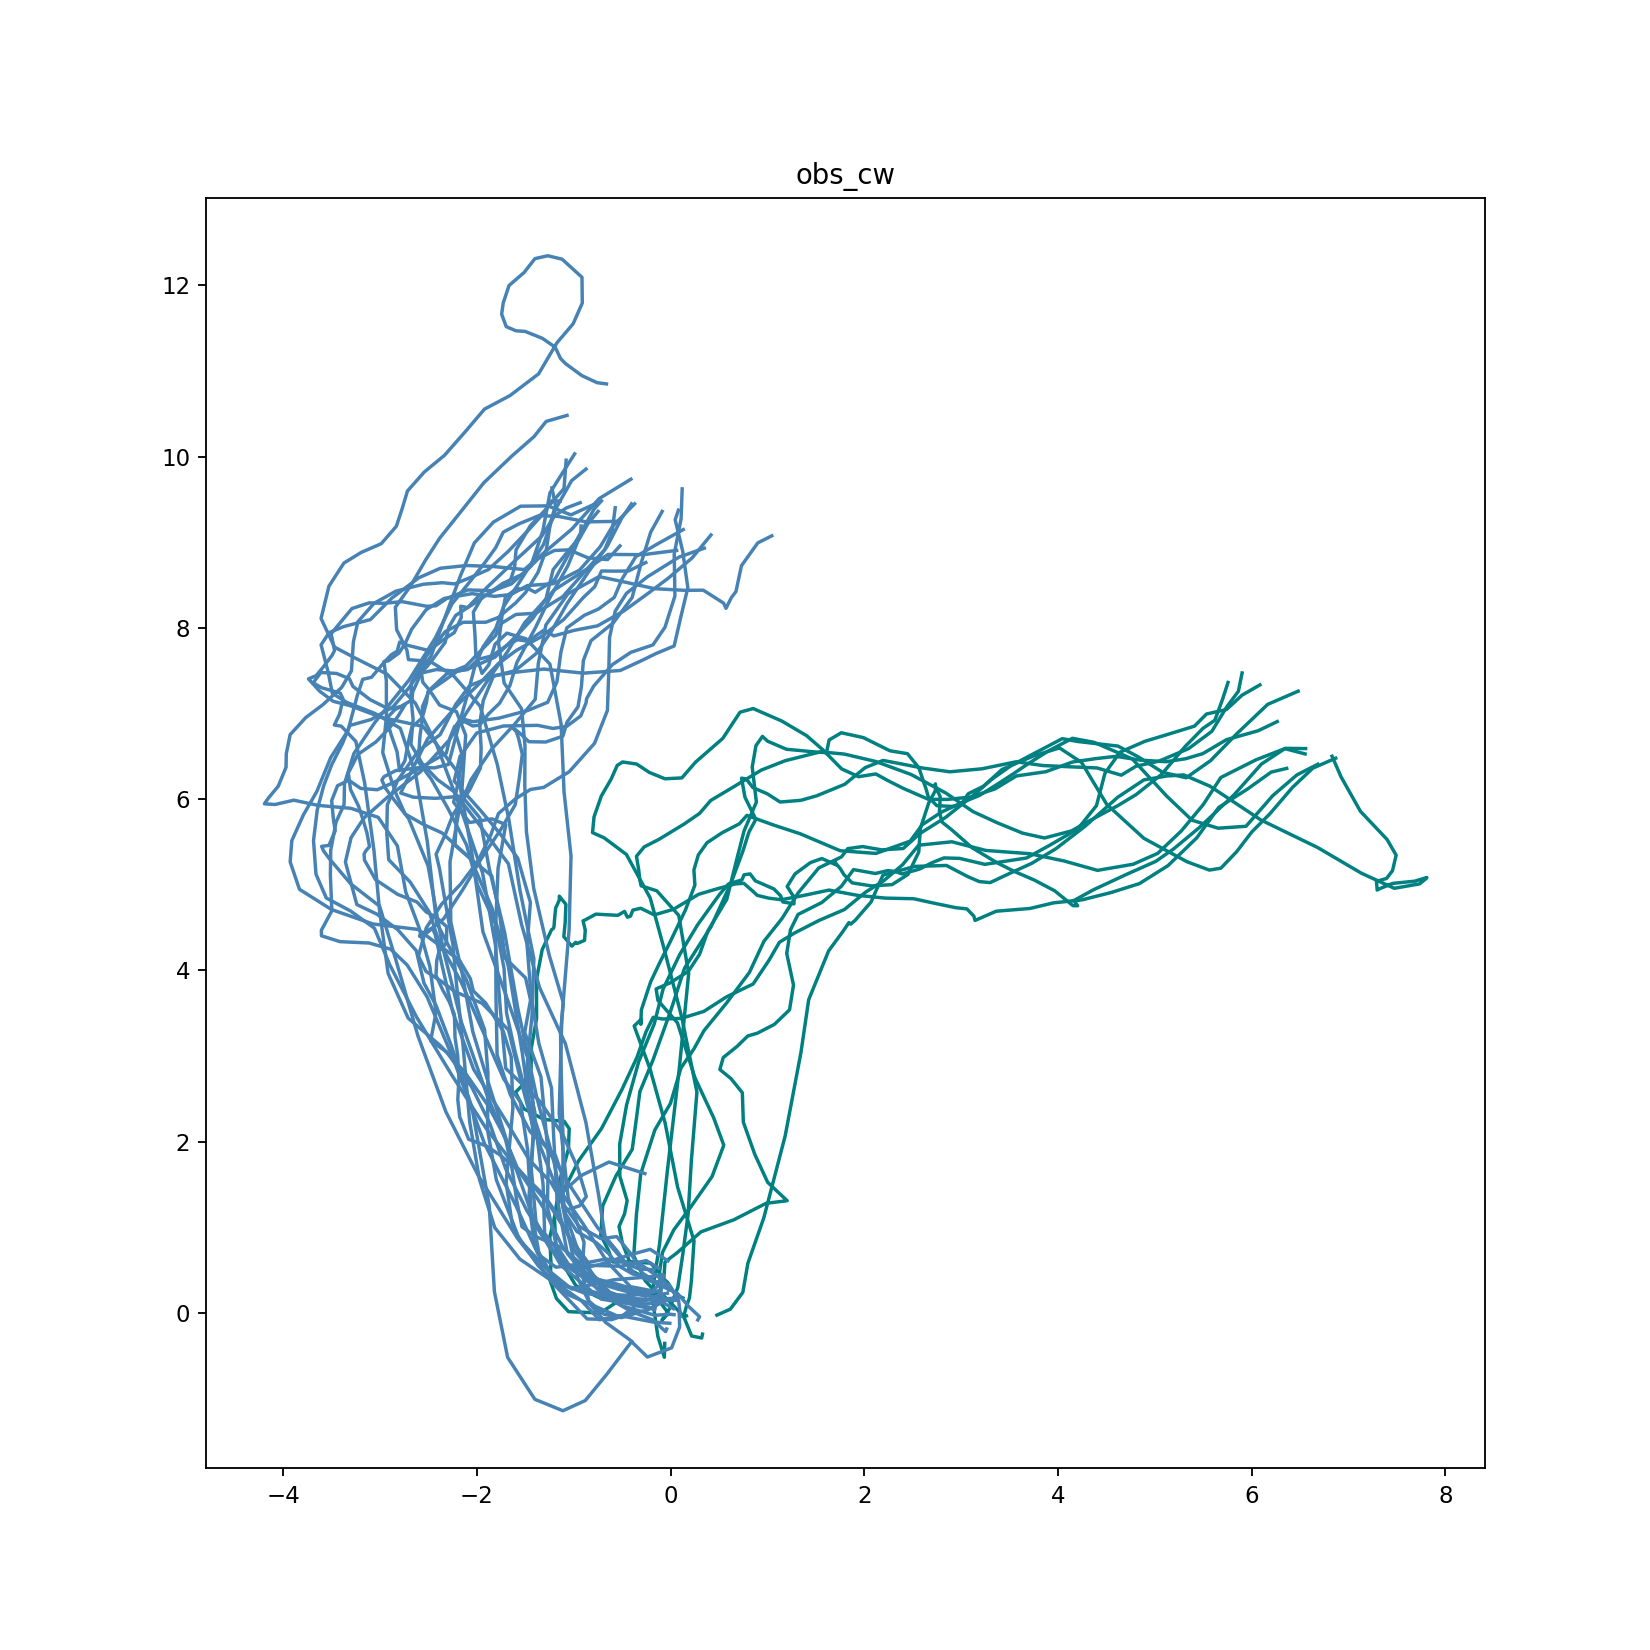

In [5]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [6]:
a_list = ['grom', 'jeev']
a2num_days = {'grom':9, 'jeev':4}

In [ ]:
#Pool simulations from "full dynamics" and "decoder_null dynamics" 
#Original simulation: 'lqr_sim_20trials.pkl', 'lqr_sim_20trials_decoder_null_dyn.pkl'
#10/27/2022 simulation: 'lqr_sim_Q2_full.pkl', 'lqr_sim_Q2_decoder_null.pkl'

In [7]:
#Dynamics models: 
dm_list = ['full', 'decoder_null'] #dynamics, decoder_null dynamics
num_trials = 20 #number of trials simulated with lqr
# dm_files = {dm_list[0]:'lqr_sim_'+str(num_trials)+'trials.pkl',\
#             dm_list[1]:'lqr_sim_'+str(num_trials)+'trials_decoder_null_dyn.pkl'}

# dm_files = {dm_list[0]:'lqr_sim_Q2_full.pkl',\
#             dm_list[1]:'lqr_sim_Q2_decoder_null.pkl'}


dm_files = {dm_list[0]:'lqr_init_fp_full_noisy.pkl',\
            dm_list[1]:'lqr_init_fp_decoder_null_noisy.pkl'}


In [8]:
model_list_analyze = \
[('full', 'n_do'), \
 ('decoder_null', 'n_do'), \
 ('full', 'n_o'), \
 ('decoder_null', 'n_o')]

mla = model_list_analyze

model_pairs = []
pair = (mla[0], mla[1])
model_pairs.append(pair)

pair = (mla[0], mla[2])
model_pairs.append(pair)

pair = (mla[1], mla[2])
model_pairs.append(pair)

pair = (mla[1], mla[3])
model_pairs.append(pair)


In [ ]:
# #Load an example lqr sim
# a = 'grom'
# d = 0
# load_dir = os.path.join(save_home, a, str(d))
# sim_dm_paths = {}
# for dm in dm_list:
#     sim_dm_paths[dm] = os.path.join(load_dir, dm_files[dm])
# lqr_dm, df_pool = analyze_lqr.pool_lqr_sim_across_dm(dm_list, sim_dm_paths)  


In [9]:
#Information for analysis: 
save_home = r'D:\DATA\bmi_co_obs_backup'

#analyze neural diff: 
p_sig_match = 0.05 #0.05
shuffle_bool = True
num_shuffle = 1000
min_obs = 15

#Save information
save_file = \
'analysis_v2_lqr_full_vs_decoder_null_'+str(num_trials)+'trials_'+ str(num_shuffle) + 'shuffles' +'.pkl'
# save_file = \
# 'curr_test' +'.pkl'
print(save_file)
#v2 refers to fixing how pooling data for the shuffle is done

analysis_v2_lqr_full_vs_decoder_null_20trials_1000shuffles.pkl


In [10]:
move_list, c_list, n_list = \
        analyze_lqr.def_var_lists(num_targets, task_rot_list, num_mag_bins_analyze, num_angle_bins, num_neurons)

In [11]:
#Run analysis:
debug_bool = False
for a in a_list: #[a_list[0]]: #a_list:
    for d in range(a2num_days[a]): #[0]: #range(a2num_days[a]):
        t_iter_start = timeit.default_timer()
        print(a,d)
        load_dir = os.path.join(save_home, a, str(d))
        
#         if not debug_bool:
            #lqr sim paths for dynamics models (dm):
        sim_dm_paths = {}
        for dm in dm_list:
            sim_dm_paths[dm] = os.path.join(load_dir, dm_files[dm])
        lqr_dm, df_pool = analyze_lqr.pool_lqr_sim_across_dm(dm_list, sim_dm_paths)

        #Load some params, must be the same across dynamics models: 
        target_list = lqr_dm[dm_list[0]]['target_list'] 
        task_rot_list = lqr_dm[dm_list[0]]['task_rot_list'] 
        num_neurons = lqr_dm[dm_list[0]]['num_neurons']
        #Decoder:
        Kn = lqr_dm[dm_list[0]]['Kn']
        
        #labels for movements, commands, neurons:
        move_list, c_list, n_list = \
        analyze_lqr.def_var_lists(num_targets, task_rot_list, num_mag_bins_analyze, num_angle_bins, num_neurons)
        #If debug, analyze small subsets of data:
        if debug_bool:
            move_list = move_list[0:2]
            c_list = [(3,0)] #[c_list[1]]
        
        #analyze u norm:
        r_u = \
        analyze_lqr.analyze_u_norm(lqr_dm, model_list_analyze, model_pairs, target_list, task_rot_list)
        
        #Analyze the difference in neural activity for (command,movement) from the movement-pooled neural activity
        model_cm =  \
        analyze_lqr.main_compute_neural_command_diff(df_pool['df_lqr_n'], Kn, model_list_analyze, move_list, c_list, n_list, p_sig_match, shuffle_bool, num_shuffle)
        model_diff = analyze_lqr.collect_neural_command_diff(model_cm, Kn, model_list_analyze, c_list, move_list, min_obs)
        
        r_n = analyze_lqr.analyze_n_diff(model_diff, model_list_analyze, model_pairs)
        
        #Save results: 
        r = {}
        r['Kn'] = Kn
        r['num_targets'] = num_targets
        r['task_rot_list'] = task_rot_list
        r['num_mag_bins_analyze'] = num_mag_bins_analyze
        r['num_angle_bins'] = num_angle_bins
        r['num_neurons'] = num_neurons
        r['m_list'] = move_list
        r['c_list'] = c_list
        r['n_list'] = n_list
        r['p_sig_match'] = p_sig_match
        r['shuffle_bool'] = shuffle_bool
        r['num_shuffle'] = num_shuffle
        r['min_obs'] = min_obs
        r['model_cm'] = model_cm
        r['model_diff'] = model_diff
        r['norm_u_df_n'] = df_pool['norm_u_df_n']
        r['r_u'] = r_u
        r['r_n'] = r_n
        
        save_dir = os.path.join(save_home, a, str(d))
        save_path = os.path.join(save_dir, save_file)
        print(save_path)
        with open(save_path, 'wb') as f: 
            data = pickle.dump(r, f, protocol=pickle.HIGHEST_PROTOCOL)    
            
        t_iter_elapsed = timeit.default_timer()-t_iter_start
        print('time iteration: ' + str(t_iter_elapsed))
        print('DONE!')        
        
        

('grom', 0)
(('full', 'n_do'), (0, 0), (0, 0))
(('full', 'n_do'), (0, 0), (0, 1.1))
(('full', 'n_do'), (0, 0), (0, 1.2))
(('full', 'n_do'), (0, 0), (1, 0))
(('full', 'n_do'), (0, 0), (1, 1.1))
(('full', 'n_do'), (0, 0), (1, 1.2))
(('full', 'n_do'), (0, 0), (2, 0))
(('full', 'n_do'), (0, 0), (2, 1.1))
(('full', 'n_do'), (0, 0), (2, 1.2))
(('full', 'n_do'), (0, 0), (3, 0))
(('full', 'n_do'), (0, 0), (3, 1.1))
(('full', 'n_do'), (0, 0), (3, 1.2))
(('full', 'n_do'), (0, 0), (4, 0))
(('full', 'n_do'), (0, 0), (4, 1.1))
(('full', 'n_do'), (0, 0), (4, 1.2))
(('full', 'n_do'), (0, 0), (5, 0))
(('full', 'n_do'), (0, 0), (5, 1.1))
(('full', 'n_do'), (0, 0), (5, 1.2))
(('full', 'n_do'), (0, 0), (6, 0))
(('full', 'n_do'), (0, 0), (6, 1.1))
(('full', 'n_do'), (0, 0), (6, 1.2))
(('full', 'n_do'), (0, 0), (7, 0))
(('full', 'n_do'), (0, 0), (7, 1.1))
(('full', 'n_do'), (0, 0), (7, 1.2))
(('full', 'n_do'), (0, 1), (0, 0))
(('full', 'n_do'), (0, 1), (0, 1.1))
(('full', 'n_do'), (0, 1), (0, 1.2))
(('full

(('full', 'n_do'), (1, 1), (5, 1.2))
(('full', 'n_do'), (1, 1), (6, 0))
(('full', 'n_do'), (1, 1), (6, 1.1))
(('full', 'n_do'), (1, 1), (6, 1.2))
(('full', 'n_do'), (1, 1), (7, 0))
(('full', 'n_do'), (1, 1), (7, 1.1))
(('full', 'n_do'), (1, 1), (7, 1.2))
(('full', 'n_do'), (1, 2), (0, 0))
(('full', 'n_do'), (1, 2), (0, 1.1))
(('full', 'n_do'), (1, 2), (0, 1.2))
(('full', 'n_do'), (1, 2), (1, 0))
(('full', 'n_do'), (1, 2), (1, 1.1))
(('full', 'n_do'), (1, 2), (1, 1.2))
(('full', 'n_do'), (1, 2), (2, 0))
(('full', 'n_do'), (1, 2), (2, 1.1))
(('full', 'n_do'), (1, 2), (2, 1.2))
(('full', 'n_do'), (1, 2), (3, 0))
(('full', 'n_do'), (1, 2), (3, 1.1))
(('full', 'n_do'), (1, 2), (3, 1.2))
(('full', 'n_do'), (1, 2), (4, 0))
(('full', 'n_do'), (1, 2), (4, 1.1))
(('full', 'n_do'), (1, 2), (4, 1.2))
(('full', 'n_do'), (1, 2), (5, 0))
(('full', 'n_do'), (1, 2), (5, 1.1))
(('full', 'n_do'), (1, 2), (5, 1.2))
(('full', 'n_do'), (1, 2), (6, 0))
(('full', 'n_do'), (1, 2), (6, 1.1))
(('full', 'n_do'), 

(('full', 'n_do'), (2, 3), (7, 1.2))
(('full', 'n_do'), (2, 4), (0, 0))
(('full', 'n_do'), (2, 4), (0, 1.1))
(('full', 'n_do'), (2, 4), (0, 1.2))
(('full', 'n_do'), (2, 4), (1, 0))
(('full', 'n_do'), (2, 4), (1, 1.1))
(('full', 'n_do'), (2, 4), (1, 1.2))
(('full', 'n_do'), (2, 4), (2, 0))
(('full', 'n_do'), (2, 4), (2, 1.1))
(('full', 'n_do'), (2, 4), (2, 1.2))
(('full', 'n_do'), (2, 4), (3, 0))
(('full', 'n_do'), (2, 4), (3, 1.1))
(('full', 'n_do'), (2, 4), (3, 1.2))
(('full', 'n_do'), (2, 4), (4, 0))
(('full', 'n_do'), (2, 4), (4, 1.1))
(('full', 'n_do'), (2, 4), (4, 1.2))
(('full', 'n_do'), (2, 4), (5, 0))
(('full', 'n_do'), (2, 4), (5, 1.1))
(('full', 'n_do'), (2, 4), (5, 1.2))
(('full', 'n_do'), (2, 4), (6, 0))
(('full', 'n_do'), (2, 4), (6, 1.1))
(('full', 'n_do'), (2, 4), (6, 1.2))
(('full', 'n_do'), (2, 4), (7, 0))
(('full', 'n_do'), (2, 4), (7, 1.1))
(('full', 'n_do'), (2, 4), (7, 1.2))
(('full', 'n_do'), (2, 5), (0, 0))
(('full', 'n_do'), (2, 5), (0, 1.1))
(('full', 'n_do'), 

(('full', 'n_do'), (3, 5), (5, 0))
(('full', 'n_do'), (3, 5), (5, 1.1))
(('full', 'n_do'), (3, 5), (5, 1.2))
(('full', 'n_do'), (3, 5), (6, 0))
(('full', 'n_do'), (3, 5), (6, 1.1))
(('full', 'n_do'), (3, 5), (6, 1.2))
(('full', 'n_do'), (3, 5), (7, 0))
(('full', 'n_do'), (3, 5), (7, 1.1))
(('full', 'n_do'), (3, 5), (7, 1.2))
(('full', 'n_do'), (3, 6), (0, 0))
(('full', 'n_do'), (3, 6), (0, 1.1))
(('full', 'n_do'), (3, 6), (0, 1.2))
(('full', 'n_do'), (3, 6), (1, 0))
(('full', 'n_do'), (3, 6), (1, 1.1))
(('full', 'n_do'), (3, 6), (1, 1.2))
(('full', 'n_do'), (3, 6), (2, 0))
(('full', 'n_do'), (3, 6), (2, 1.1))
(('full', 'n_do'), (3, 6), (2, 1.2))
(('full', 'n_do'), (3, 6), (3, 0))
(('full', 'n_do'), (3, 6), (3, 1.1))
(('full', 'n_do'), (3, 6), (3, 1.2))
(('full', 'n_do'), (3, 6), (4, 0))
(('full', 'n_do'), (3, 6), (4, 1.1))
(('full', 'n_do'), (3, 6), (4, 1.2))
(('full', 'n_do'), (3, 6), (5, 0))
(('full', 'n_do'), (3, 6), (5, 1.1))
(('full', 'n_do'), (3, 6), (5, 1.2))
(('full', 'n_do'), 

(('decoder_null', 'n_do'), (0, 6), (0, 0))
(('decoder_null', 'n_do'), (0, 6), (0, 1.1))
(('decoder_null', 'n_do'), (0, 6), (0, 1.2))
(('decoder_null', 'n_do'), (0, 6), (1, 0))
(('decoder_null', 'n_do'), (0, 6), (1, 1.1))
(('decoder_null', 'n_do'), (0, 6), (1, 1.2))
(('decoder_null', 'n_do'), (0, 6), (2, 0))
(('decoder_null', 'n_do'), (0, 6), (2, 1.1))
(('decoder_null', 'n_do'), (0, 6), (2, 1.2))
(('decoder_null', 'n_do'), (0, 6), (3, 0))
(('decoder_null', 'n_do'), (0, 6), (3, 1.1))
(('decoder_null', 'n_do'), (0, 6), (3, 1.2))
(('decoder_null', 'n_do'), (0, 6), (4, 0))
(('decoder_null', 'n_do'), (0, 6), (4, 1.1))
(('decoder_null', 'n_do'), (0, 6), (4, 1.2))
(('decoder_null', 'n_do'), (0, 6), (5, 0))
(('decoder_null', 'n_do'), (0, 6), (5, 1.1))
(('decoder_null', 'n_do'), (0, 6), (5, 1.2))
(('decoder_null', 'n_do'), (0, 6), (6, 0))
(('decoder_null', 'n_do'), (0, 6), (6, 1.1))
(('decoder_null', 'n_do'), (0, 6), (6, 1.2))
(('decoder_null', 'n_do'), (0, 6), (7, 0))
(('decoder_null', 'n_do'),

(('decoder_null', 'n_do'), (1, 5), (7, 1.1))
(('decoder_null', 'n_do'), (1, 5), (7, 1.2))
(('decoder_null', 'n_do'), (1, 6), (0, 0))
(('decoder_null', 'n_do'), (1, 6), (0, 1.1))
(('decoder_null', 'n_do'), (1, 6), (0, 1.2))
(('decoder_null', 'n_do'), (1, 6), (1, 0))
(('decoder_null', 'n_do'), (1, 6), (1, 1.1))
(('decoder_null', 'n_do'), (1, 6), (1, 1.2))
(('decoder_null', 'n_do'), (1, 6), (2, 0))
(('decoder_null', 'n_do'), (1, 6), (2, 1.1))
(('decoder_null', 'n_do'), (1, 6), (2, 1.2))
(('decoder_null', 'n_do'), (1, 6), (3, 0))
(('decoder_null', 'n_do'), (1, 6), (3, 1.1))
(('decoder_null', 'n_do'), (1, 6), (3, 1.2))
(('decoder_null', 'n_do'), (1, 6), (4, 0))
(('decoder_null', 'n_do'), (1, 6), (4, 1.1))
(('decoder_null', 'n_do'), (1, 6), (4, 1.2))
(('decoder_null', 'n_do'), (1, 6), (5, 0))
(('decoder_null', 'n_do'), (1, 6), (5, 1.1))
(('decoder_null', 'n_do'), (1, 6), (5, 1.2))
(('decoder_null', 'n_do'), (1, 6), (6, 0))
(('decoder_null', 'n_do'), (1, 6), (6, 1.1))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (2, 5), (6, 0))
(('decoder_null', 'n_do'), (2, 5), (6, 1.1))
(('decoder_null', 'n_do'), (2, 5), (6, 1.2))
(('decoder_null', 'n_do'), (2, 5), (7, 0))
(('decoder_null', 'n_do'), (2, 5), (7, 1.1))
(('decoder_null', 'n_do'), (2, 5), (7, 1.2))
(('decoder_null', 'n_do'), (2, 6), (0, 0))
(('decoder_null', 'n_do'), (2, 6), (0, 1.1))
(('decoder_null', 'n_do'), (2, 6), (0, 1.2))
(('decoder_null', 'n_do'), (2, 6), (1, 0))
(('decoder_null', 'n_do'), (2, 6), (1, 1.1))
(('decoder_null', 'n_do'), (2, 6), (1, 1.2))
(('decoder_null', 'n_do'), (2, 6), (2, 0))
(('decoder_null', 'n_do'), (2, 6), (2, 1.1))
(('decoder_null', 'n_do'), (2, 6), (2, 1.2))
(('decoder_null', 'n_do'), (2, 6), (3, 0))
(('decoder_null', 'n_do'), (2, 6), (3, 1.1))
(('decoder_null', 'n_do'), (2, 6), (3, 1.2))
(('decoder_null', 'n_do'), (2, 6), (4, 0))
(('decoder_null', 'n_do'), (2, 6), (4, 1.1))
(('decoder_null', 'n_do'), (2, 6), (4, 1.2))
(('decoder_null', 'n_do'), (2, 6), (5, 0))
(('decoder_null', 'n_do'),

(('decoder_null', 'n_do'), (3, 5), (4, 1.1))
(('decoder_null', 'n_do'), (3, 5), (4, 1.2))
(('decoder_null', 'n_do'), (3, 5), (5, 0))
(('decoder_null', 'n_do'), (3, 5), (5, 1.1))
(('decoder_null', 'n_do'), (3, 5), (5, 1.2))
(('decoder_null', 'n_do'), (3, 5), (6, 0))
(('decoder_null', 'n_do'), (3, 5), (6, 1.1))
(('decoder_null', 'n_do'), (3, 5), (6, 1.2))
(('decoder_null', 'n_do'), (3, 5), (7, 0))
(('decoder_null', 'n_do'), (3, 5), (7, 1.1))
(('decoder_null', 'n_do'), (3, 5), (7, 1.2))
(('decoder_null', 'n_do'), (3, 6), (0, 0))
(('decoder_null', 'n_do'), (3, 6), (0, 1.1))
(('decoder_null', 'n_do'), (3, 6), (0, 1.2))
(('decoder_null', 'n_do'), (3, 6), (1, 0))
(('decoder_null', 'n_do'), (3, 6), (1, 1.1))
(('decoder_null', 'n_do'), (3, 6), (1, 1.2))
(('decoder_null', 'n_do'), (3, 6), (2, 0))
(('decoder_null', 'n_do'), (3, 6), (2, 1.1))
(('decoder_null', 'n_do'), (3, 6), (2, 1.2))
(('decoder_null', 'n_do'), (3, 6), (3, 0))
(('decoder_null', 'n_do'), (3, 6), (3, 1.1))
(('decoder_null', 'n_do'

(('full', 'n_o'), (0, 6), (6, 0))
(('full', 'n_o'), (0, 6), (6, 1.1))
(('full', 'n_o'), (0, 6), (6, 1.2))
(('full', 'n_o'), (0, 6), (7, 0))
(('full', 'n_o'), (0, 6), (7, 1.1))
(('full', 'n_o'), (0, 6), (7, 1.2))
(('full', 'n_o'), (0, 7), (0, 0))
(('full', 'n_o'), (0, 7), (0, 1.1))
(('full', 'n_o'), (0, 7), (0, 1.2))
(('full', 'n_o'), (0, 7), (1, 0))
(('full', 'n_o'), (0, 7), (1, 1.1))
(('full', 'n_o'), (0, 7), (1, 1.2))
(('full', 'n_o'), (0, 7), (2, 0))
(('full', 'n_o'), (0, 7), (2, 1.1))
(('full', 'n_o'), (0, 7), (2, 1.2))
(('full', 'n_o'), (0, 7), (3, 0))
(('full', 'n_o'), (0, 7), (3, 1.1))
(('full', 'n_o'), (0, 7), (3, 1.2))
(('full', 'n_o'), (0, 7), (4, 0))
(('full', 'n_o'), (0, 7), (4, 1.1))
(('full', 'n_o'), (0, 7), (4, 1.2))
(('full', 'n_o'), (0, 7), (5, 0))
(('full', 'n_o'), (0, 7), (5, 1.1))
(('full', 'n_o'), (0, 7), (5, 1.2))
(('full', 'n_o'), (0, 7), (6, 0))
(('full', 'n_o'), (0, 7), (6, 1.1))
(('full', 'n_o'), (0, 7), (6, 1.2))
(('full', 'n_o'), (0, 7), (7, 0))
(('full', 'n

(('full', 'n_o'), (2, 0), (7, 1.1))
(('full', 'n_o'), (2, 0), (7, 1.2))
(('full', 'n_o'), (2, 1), (0, 0))
(('full', 'n_o'), (2, 1), (0, 1.1))
(('full', 'n_o'), (2, 1), (0, 1.2))
(('full', 'n_o'), (2, 1), (1, 0))
(('full', 'n_o'), (2, 1), (1, 1.1))
(('full', 'n_o'), (2, 1), (1, 1.2))
(('full', 'n_o'), (2, 1), (2, 0))
(('full', 'n_o'), (2, 1), (2, 1.1))
(('full', 'n_o'), (2, 1), (2, 1.2))
(('full', 'n_o'), (2, 1), (3, 0))
(('full', 'n_o'), (2, 1), (3, 1.1))
(('full', 'n_o'), (2, 1), (3, 1.2))
(('full', 'n_o'), (2, 1), (4, 0))
(('full', 'n_o'), (2, 1), (4, 1.1))
(('full', 'n_o'), (2, 1), (4, 1.2))
(('full', 'n_o'), (2, 1), (5, 0))
(('full', 'n_o'), (2, 1), (5, 1.1))
(('full', 'n_o'), (2, 1), (5, 1.2))
(('full', 'n_o'), (2, 1), (6, 0))
(('full', 'n_o'), (2, 1), (6, 1.1))
(('full', 'n_o'), (2, 1), (6, 1.2))
(('full', 'n_o'), (2, 1), (7, 0))
(('full', 'n_o'), (2, 1), (7, 1.1))
(('full', 'n_o'), (2, 1), (7, 1.2))
(('full', 'n_o'), (2, 2), (0, 0))
(('full', 'n_o'), (2, 2), (0, 1.1))
(('full', 

(('full', 'n_o'), (3, 2), (5, 0))
(('full', 'n_o'), (3, 2), (5, 1.1))
(('full', 'n_o'), (3, 2), (5, 1.2))
(('full', 'n_o'), (3, 2), (6, 0))
(('full', 'n_o'), (3, 2), (6, 1.1))
(('full', 'n_o'), (3, 2), (6, 1.2))
(('full', 'n_o'), (3, 2), (7, 0))
(('full', 'n_o'), (3, 2), (7, 1.1))
(('full', 'n_o'), (3, 2), (7, 1.2))
(('full', 'n_o'), (3, 3), (0, 0))
(('full', 'n_o'), (3, 3), (0, 1.1))
(('full', 'n_o'), (3, 3), (0, 1.2))
(('full', 'n_o'), (3, 3), (1, 0))
(('full', 'n_o'), (3, 3), (1, 1.1))
(('full', 'n_o'), (3, 3), (1, 1.2))
(('full', 'n_o'), (3, 3), (2, 0))
(('full', 'n_o'), (3, 3), (2, 1.1))
(('full', 'n_o'), (3, 3), (2, 1.2))
(('full', 'n_o'), (3, 3), (3, 0))
(('full', 'n_o'), (3, 3), (3, 1.1))
(('full', 'n_o'), (3, 3), (3, 1.2))
(('full', 'n_o'), (3, 3), (4, 0))
(('full', 'n_o'), (3, 3), (4, 1.1))
(('full', 'n_o'), (3, 3), (4, 1.2))
(('full', 'n_o'), (3, 3), (5, 0))
(('full', 'n_o'), (3, 3), (5, 1.1))
(('full', 'n_o'), (3, 3), (5, 1.2))
(('full', 'n_o'), (3, 3), (6, 0))
(('full', 'n

(('decoder_null', 'n_o'), (0, 4), (0, 1.1))
(('decoder_null', 'n_o'), (0, 4), (0, 1.2))
(('decoder_null', 'n_o'), (0, 4), (1, 0))
(('decoder_null', 'n_o'), (0, 4), (1, 1.1))
(('decoder_null', 'n_o'), (0, 4), (1, 1.2))
(('decoder_null', 'n_o'), (0, 4), (2, 0))
(('decoder_null', 'n_o'), (0, 4), (2, 1.1))
(('decoder_null', 'n_o'), (0, 4), (2, 1.2))
(('decoder_null', 'n_o'), (0, 4), (3, 0))
(('decoder_null', 'n_o'), (0, 4), (3, 1.1))
(('decoder_null', 'n_o'), (0, 4), (3, 1.2))
(('decoder_null', 'n_o'), (0, 4), (4, 0))
(('decoder_null', 'n_o'), (0, 4), (4, 1.1))
(('decoder_null', 'n_o'), (0, 4), (4, 1.2))
(('decoder_null', 'n_o'), (0, 4), (5, 0))
(('decoder_null', 'n_o'), (0, 4), (5, 1.1))
(('decoder_null', 'n_o'), (0, 4), (5, 1.2))
(('decoder_null', 'n_o'), (0, 4), (6, 0))
(('decoder_null', 'n_o'), (0, 4), (6, 1.1))
(('decoder_null', 'n_o'), (0, 4), (6, 1.2))
(('decoder_null', 'n_o'), (0, 4), (7, 0))
(('decoder_null', 'n_o'), (0, 4), (7, 1.1))
(('decoder_null', 'n_o'), (0, 4), (7, 1.2))
((

(('decoder_null', 'n_o'), (1, 4), (0, 1.1))
(('decoder_null', 'n_o'), (1, 4), (0, 1.2))
(('decoder_null', 'n_o'), (1, 4), (1, 0))
(('decoder_null', 'n_o'), (1, 4), (1, 1.1))
(('decoder_null', 'n_o'), (1, 4), (1, 1.2))
(('decoder_null', 'n_o'), (1, 4), (2, 0))
(('decoder_null', 'n_o'), (1, 4), (2, 1.1))
(('decoder_null', 'n_o'), (1, 4), (2, 1.2))
(('decoder_null', 'n_o'), (1, 4), (3, 0))
(('decoder_null', 'n_o'), (1, 4), (3, 1.1))
(('decoder_null', 'n_o'), (1, 4), (3, 1.2))
(('decoder_null', 'n_o'), (1, 4), (4, 0))
(('decoder_null', 'n_o'), (1, 4), (4, 1.1))
(('decoder_null', 'n_o'), (1, 4), (4, 1.2))
(('decoder_null', 'n_o'), (1, 4), (5, 0))
(('decoder_null', 'n_o'), (1, 4), (5, 1.1))
(('decoder_null', 'n_o'), (1, 4), (5, 1.2))
(('decoder_null', 'n_o'), (1, 4), (6, 0))
(('decoder_null', 'n_o'), (1, 4), (6, 1.1))
(('decoder_null', 'n_o'), (1, 4), (6, 1.2))
(('decoder_null', 'n_o'), (1, 4), (7, 0))
(('decoder_null', 'n_o'), (1, 4), (7, 1.1))
(('decoder_null', 'n_o'), (1, 4), (7, 1.2))
((

(('decoder_null', 'n_o'), (2, 3), (7, 1.2))
(('decoder_null', 'n_o'), (2, 4), (0, 0))
(('decoder_null', 'n_o'), (2, 4), (0, 1.1))
(('decoder_null', 'n_o'), (2, 4), (0, 1.2))
(('decoder_null', 'n_o'), (2, 4), (1, 0))
(('decoder_null', 'n_o'), (2, 4), (1, 1.1))
(('decoder_null', 'n_o'), (2, 4), (1, 1.2))
(('decoder_null', 'n_o'), (2, 4), (2, 0))
(('decoder_null', 'n_o'), (2, 4), (2, 1.1))
(('decoder_null', 'n_o'), (2, 4), (2, 1.2))
(('decoder_null', 'n_o'), (2, 4), (3, 0))
(('decoder_null', 'n_o'), (2, 4), (3, 1.1))
(('decoder_null', 'n_o'), (2, 4), (3, 1.2))
(('decoder_null', 'n_o'), (2, 4), (4, 0))
(('decoder_null', 'n_o'), (2, 4), (4, 1.1))
(('decoder_null', 'n_o'), (2, 4), (4, 1.2))
(('decoder_null', 'n_o'), (2, 4), (5, 0))
(('decoder_null', 'n_o'), (2, 4), (5, 1.1))
(('decoder_null', 'n_o'), (2, 4), (5, 1.2))
(('decoder_null', 'n_o'), (2, 4), (6, 0))
(('decoder_null', 'n_o'), (2, 4), (6, 1.1))
(('decoder_null', 'n_o'), (2, 4), (6, 1.2))
(('decoder_null', 'n_o'), (2, 4), (7, 0))
(('d

(('decoder_null', 'n_o'), (3, 4), (2, 0))
(('decoder_null', 'n_o'), (3, 4), (2, 1.1))
(('decoder_null', 'n_o'), (3, 4), (2, 1.2))
(('decoder_null', 'n_o'), (3, 4), (3, 0))
(('decoder_null', 'n_o'), (3, 4), (3, 1.1))
(('decoder_null', 'n_o'), (3, 4), (3, 1.2))
(('decoder_null', 'n_o'), (3, 4), (4, 0))
(('decoder_null', 'n_o'), (3, 4), (4, 1.1))
(('decoder_null', 'n_o'), (3, 4), (4, 1.2))
(('decoder_null', 'n_o'), (3, 4), (5, 0))
(('decoder_null', 'n_o'), (3, 4), (5, 1.1))
(('decoder_null', 'n_o'), (3, 4), (5, 1.2))
(('decoder_null', 'n_o'), (3, 4), (6, 0))
(('decoder_null', 'n_o'), (3, 4), (6, 1.1))
(('decoder_null', 'n_o'), (3, 4), (6, 1.2))
(('decoder_null', 'n_o'), (3, 4), (7, 0))
(('decoder_null', 'n_o'), (3, 4), (7, 1.1))
(('decoder_null', 'n_o'), (3, 4), (7, 1.2))
(('decoder_null', 'n_o'), (3, 5), (0, 0))
(('decoder_null', 'n_o'), (3, 5), (0, 1.1))
(('decoder_null', 'n_o'), (3, 5), (0, 1.2))
(('decoder_null', 'n_o'), (3, 5), (1, 0))
(('decoder_null', 'n_o'), (3, 5), (1, 1.1))
(('d

c:\anaconda3\envs\py2\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
c:\anaconda3\envs\py2\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\anaconda3\envs\py2\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\anaconda3\envs\py2\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\anaconda3\envs\py2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\The Kraken\Documents\GitHub\bmi_dynamics_code\behavior_co_obs.py:1582: RuntimeWarning: Degrees of freedom <= 0 for slice
  target_std = np.sqrt(np.diag(np.cov(d_list[1])))
c:\anaco

0.9
matched!
0.9
matched!
0.9
matched!
0.9
448
0.8
398
0.7
348
0.6
298
0.5
249
0.4
199
0.3
matched!
0.9
matched!
0.9
matched!
0.9
448
0.8
matched!
0.9
448
0.8
398
0.7
348
0.6
matched!
0.9
448
0.8
398
0.7
348
0.6
matched!
0.9
448
0.8
398
0.7
348
0.6
298
0.5
249
0.4
matched!
0.9
matched!
0.9
matched!
0.9
448
0.8
398
0.7
348
0.6
298
0.5
matched!
0.9
matched!
0.9
448
0.8
398
0.7
348
0.6
matched!
0.9
448
0.8
matched!
0.9
matched!
0.9
matched!
0.9
448
0.8
398
0.7
348
0.6
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
448
0.8
398
0.7
348
0.6
298
0.5
249
0.4
199
0.3
matched!
0.9
448
0.8
398
0.7
348
0.6
298
0.5
matched!
0.9
395
0.8
351
0.7
307
0.6
263
0.5
219
0.4
175
0.3
131
0.2
87
0.1
matched!
0.9
matched!
0.9
matched!
0.9
395
0.8
351
0.7
307
0.6
263
0.5
219
0.4
matched!
0.9
matched!
0.9
395
0.8
351
0.7
307
0.6
263
0.5
219
0.4
matched!
0.9
395
0.8
351
0.7
matched!
0.9
395
0.8
351
0.7
307
0.6
263
0.5
matched!
0.9
395
0.8
351
0.7
307
0.6
matched!
0.9
395
0.8
351
0.7
matched!
0.9
395
0.8
351

c:\anaconda3\envs\py2\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
c:\anaconda3\envs\py2\lib\site-packages\xarray\core\nputils.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwds)
c:\anaconda3\envs\py2\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\anaconda3\envs\py2\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.9
477
0.8
424
0.7
371
0.6
matched!
0.9
matched!
0.9
477
0.8
424
0.7
371
0.6
318
0.5
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
477
0.8
424
0.7
371
0.6
matched!
0.9
477
0.8
matched!
0.9
477
0.8
424
0.7
371
0.6
318
0.5
265
0.4
matched!
0.9
477
0.8
424
0.7
371
0.6
318
0.5
265
0.4
matched!
0.9
477
0.8
424
0.7
371
0.6
318
0.5
265
0.4
matched!
0.9
551
0.8
490
0.7
429
0.6
matched!
0.9
551
0.8
490
0.7
429
0.6
367
0.5
306
0.4
matched!
0.9
551
0.8
490
0.7
429
0.6
367
0.5
matched!
0.9
551
0.8
490
0.7
matched!
0.9
matched!
0.9
551
0.8
matched!
0.9
551
0.8
490
0.7
429
0.6
367
0.5
306
0.4
245
0.3
183
0.2
122
0.1
matched!
0.9
551
0.8
490
0.7
matched!
0.9
matched!
0.9
matched!
0.9
551
0.8
matched!
0.9
551
0.8
490
0.7
429
0.6
367
0.5
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
551
0.8
490
0.7
429
0.6
matched!
0.9
551
0.8
490
0.7
4

479
0.7
419
0.6
359
0.5
matched!
0.9
matched!
0.9
539
0.8
matched!
0.9
539
0.8
479
0.7
matched!
0.9
539
0.8
matched!
0.9
matched!
0.9
matched!
0.9
539
0.8
479
0.7
419
0.6
359
0.5
299
0.4
239
0.3
matched!
0.9
539
0.8
479
0.7
419
0.6
359
0.5
matched!
0.9
matched!
0.9
539
0.8
479
0.7
419
0.6
359
0.5
matched!
0.9
539
0.8
479
0.7
419
0.6
359
0.5
299
0.4
239
0.3
179
0.2
matched!
0.9
matched!
0.9
488
0.8
434
0.7
380
0.6
325
0.5
matched!
0.9
488
0.8
434
0.7
380
0.6
325
0.5
271
0.4
217
0.3
162
0.2
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
488
0.8
434
0.7
380
0.6
325
0.5
matched!
0.9
488
0.8
434
0.7
380
0.6
325
0.5
271
0.4
matched!
0.9
488
0.8
434
0.7
380
0.6
325
0.5
271
0.4
217
0.3
162
0.2
108
0.1
matched!
0.9
488
0.8
434
0.7
380
0.6
matched!
0.9
488
0.8
434
0.7
380
0.6
325
0.5
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
488
0.8
434
0.7
380
0.6
325
0.5
271
0.4
217
0.3
162
0.2
108
0.1
mat

412
0.6
353
0.5
294
0.4
235
0.3
matched!
0.9
530
0.8
matched!
0.9
530
0.8
matched!
0.9
matched!
0.9
530
0.8
471
0.7
412
0.6
matched!
0.9
matched!
0.9
530
0.8
471
0.7
412
0.6
353
0.5
matched!
0.9
matched!
0.9
530
0.8
471
0.7
412
0.6
353
0.5
294
0.4
matched!
0.9
530
0.8
471
0.7
412
0.6
353
0.5
294
0.4
matched!
0.9
530
0.8
471
0.7
412
0.6
matched!
0.9
530
0.8
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
544
0.8
484
0.7
matched!
0.9
matched!
0.9
544
0.8
matched!
0.9
544
0.8
484
0.7
423
0.6
matched!
0.9
matched!
0.9
544
0.8
matched!
0.9
544
0.8
484
0.7
423
0.6
363
0.5
matched!
0.9
544
0.8
484
0.7
matched!
0.9
544
0.8
484
0.7
423
0.6
363
0.5
302
0.4
241
0.3
matched!
0.9
matched!
0.9
544
0.8
matched!
0.9
544
0.8
484
0.7
423
0.6
363
0.5
matched!
0.9
544
0.8
484
0.7
423
0.6
matched!
0.9
matched!
0.9
544
0.8
484
0.7
423
0.6
363
0.5
302
0.4
241
0.3
matched!
0.9
matched!
0.9
544
0.8
matched!
0.9
544
0.8
matched!
0.9
544
0.8
484
0.7
423
0.6
matched!
0.9
544
0.8
484
0.7
423
0.6
363
0.5
302
0.

0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
496
0.8
441
0.7
386
0.6
matched!
0.9
matched!
0.9
496
0.8
441
0.7
386
0.6
331
0.5
276
0.4
220
0.3
matched!
0.9
496
0.8
441
0.7
386
0.6
331
0.5
276
0.4
matched!
0.9
496
0.8
441
0.7
386
0.6
331
0.5
276
0.4
220
0.3
165
0.2
matched!
0.9
496
0.8
441
0.7
386
0.6
331
0.5
276
0.4
220
0.3
165
0.2
matched!
0.9
496
0.8
441
0.7
386
0.6
331
0.5
276
0.4
220
0.3
matched!
0.9
496
0.8
441
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
496
0.8
441
0.7
386
0.6
331
0.5
matched!
0.9
496
0.8
441
0.7
386
0.6
331
0.5
matched!
0.9
matched!
0.9
matched!
0.9
496
0.8
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
450
0.8
400
0.7
350
0.6
300
0.5
matched!
0.9
matched!
0.9
450
0.8
400
0.7
350
0.6
300
0.5
250
0.4
200
0.3
matched!
0.9
450
0.8
400
0.7
350
0.6
300
0.5
250
0.4
matched!
0.9
450
0.8
4

0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
531
0.8
472
0.7
413
0.6
354
0.5
295
0.4
235
0.3
176
0.2
matched!
0.9
531
0.8
472
0.7
413
0.6
354
0.5
295
0.4
235
0.3
matched!
0.9
matched!
0.9
531
0.8
472
0.7
413
0.6
matched!
0.9
531
0.8
472
0.7
matched!
0.9
matched!
0.9
363
0.8
323
0.7
282
0.6
matched!
0.9
363
0.8
323
0.7
282
0.6
matched!
0.9
matched!
0.9
matched!
0.9
363
0.8
323
0.7
282
0.6
242
0.5
matched!
0.9
matched!
0.9
363
0.8
323
0.7
282
0.6
matched!
0.9
363
0.8
323
0.7
282
0.6
242
0.5
202
0.4
matched!
0.9
matched!
0.9
363
0.8
323
0.7
282
0.6
242
0.5
202
0.4
161
0.3
matched!
0.9
363
0.8
323
0.7
282
0.6
242
0.5
202
0.4
161
0.3
121
0.2
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
363
0.8
323
0.7
282
0.6
242
0.5
202
0.4
161
0.3
121
0.2
matched!
0.9
363
0.8
323
0.7
282
0.6
242
0.5
202
0.4
161
0.3
121
0.2
matched!
0.9
matched!
0.

0.9
matched!
0.9
374
0.8
332
0.7
291
0.6
249
0.5
208
0.4
166
0.3
124
0.2
matched!
0.9
374
0.8
332
0.7
291
0.6
249
0.5
208
0.4
166
0.3
124
0.2
83
0.1
matched!
0.9
matched!
0.9
374
0.8
332
0.7
291
0.6
249
0.5
208
0.4
166
0.3
matched!
0.9
374
0.8
332
0.7
291
0.6
249
0.5
208
0.4
166
0.3
124
0.2
83
0.1
matched!
0.9
matched!
0.9
374
0.8
332
0.7
291
0.6
249
0.5
208
0.4
166
0.3
matched!
0.9
matched!
0.9
matched!
0.9
374
0.8
332
0.7
291
0.6
249
0.5
208
0.4
matched!
0.9
matched!
0.9
374
0.8
332
0.7
291
0.6
249
0.5
208
0.4
matched!
0.9
374
0.8
332
0.7
matched!
0.9
matched!
0.9
matched!
0.9
374
0.8
332
0.7
291
0.6
249
0.5
208
0.4
166
0.3
124
0.2
83
0.1
matched!
0.9
matched!
0.9
matched!
0.9
374
0.8
332
0.7
291
0.6
249
0.5
208
0.4
166
0.3
124
0.2
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
374
0.8
332
0.7
291
0.6
249
0.5
208
0.4
166
0.3
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
284
0.8
252
0.7
221
0.6
189
0.5
matched!
0.9
matched!
0.9
284
0.8
252
0.7
221
0.6
189
0.5
m

0.9
matched!
0.9
573
0.8
509
0.7
445
0.6
matched!
0.9
573
0.8
matched!
0.9
matched!
0.9
573
0.8
509
0.7
445
0.6
382
0.5
318
0.4
254
0.3
191
0.2
matched!
0.9
576
0.8
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
576
0.8
512
0.7
448
0.6
384
0.5
320
0.4
256
0.3
matched!
0.9
576
0.8
512
0.7
448
0.6
384
0.5
320
0.4
256
0.3
matched!
0.9
matched!
0.9
576
0.8
512
0.7
448
0.6
384
0.5
320
0.4
matched!
0.9
576
0.8
512
0.7
448
0.6
384
0.5
320
0.4
256
0.3
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
576
0.8
512
0.7
448
0.6
384
0.5
320
0.4
256
0.3
matched!
0.9
576
0.8
512
0.7
448
0.6
384
0.5
320
0.4
matched!
0.9
576
0.8
512
0.7
448
0.6
384
0.5
320
0.4
256
0.3
192
0.2
128
0.1
matched!
0.9
576
0.8
matched!
0.9
576
0.8
512
0.7
448
0.6
matched!
0.9
matched!
0.9
484
0.8
430
0.7
matched!
0.9
484
0.8
430
0.7
376
0.6
matched!
0.9
484
0.8
430
0.7
376
0.6
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9


0.9
156
0.8
139
0.7
121
0.6
104
0.5
matched!
0.9
matched!
0.9
156
0.8
139
0.7
121
0.6
104
0.5
87
0.4
matched!
0.9
matched!
0.9
matched!
0.9
156
0.8
139
0.7
121
0.6
104
0.5
87
0.4
69
0.3
52
0.2
34
0.1
matched!
0.9
156
0.8
139
0.7
121
0.6
104
0.5
87
0.4
69
0.3
52
0.2
34
0.1
failed!
0.9
matched!
0.9
matched!
0.9
156
0.8
139
0.7
121
0.6
matched!
0.9
matched!
0.9
156
0.8
139
0.7
121
0.6
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
310
0.8
276
0.7
241
0.6
207
0.5
172
0.4
137
0.3
103
0.2
matched!
0.9
310
0.8
276
0.7
241
0.6
207
0.5
172
0.4
matched!
0.9
matched!
0.9
310
0.8
276
0.7
241
0.6
207
0.5
172
0.4
137
0.3
matched!
0.9
310
0.8
276
0.7
matched!
0.9
matched!
0.9
310
0.8
276
0.7
241
0.6
207
0.5
172
0.4
137
0.3
103
0.2
68
0.1
failed!
0.9
310
0.8
276
0.7
241
0.6
207
0.5
172
0.4
137
0.3
103
0.2
matched!
0.9
matched!
0.9
matched!
0.9
310
0.8
matc

242
0.5
matched!
0.9
matched!
0.9
363
0.8
323
0.7
282
0.6
242
0.5
matched!
0.9
matched!
0.9
matched!
0.9
363
0.8
323
0.7
matched!
0.9
matched!
0.9
363
0.8
323
0.7
matched!
0.9
363
0.8
323
0.7
282
0.6
242
0.5
matched!
0.9
matched!
0.9
363
0.8
323
0.7
282
0.6
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
317
0.8
282
0.7
247
0.6
211
0.5
matched!
0.9
317
0.8
282
0.7
247
0.6
211
0.5
176
0.4
141
0.3
matched!
0.9
317
0.8
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
317
0.8
matched!
0.9
matched!
0.9
317
0.8
282
0.7
247
0.6
matched!
0.9
matched!
0.9
317
0.8
282
0.7
247
0.6
211
0.5
matched!
0.9
matched!
0.9
matched!
0.9
317
0.8
282
0.7
247
0.6
211
0.5
176
0.4
141
0.3
105
0.2
matched!
0.9
matched!
0.9
317
0.8
282
0.7
247
0.6
211
0.5
matched!
0.9
317
0.8
282
0.7
247
0.6
211
0.5
matched!
0.9
317
0.8
matched!
0.9
317
0.8
matched!
0.9
549
0.8
488
0.7
matched!
0.9
matched!
0.9
matched!
0.9
549
0.8
488
0.7
427
0.6
366
0.5
305

274
0.5
229
0.4
matched!
0.9
412
0.8
366
0.7
320
0.6
274
0.5
229
0.4
matched!
0.9
matched!
0.9
412
0.8
366
0.7
320
0.6
274
0.5
229
0.4
183
0.3
matched!
0.9
412
0.8
366
0.7
320
0.6
274
0.5
229
0.4
183
0.3
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
457
0.8
406
0.7
355
0.6
304
0.5
254
0.4
203
0.3
152
0.2
matched!
0.9
457
0.8
406
0.7
355
0.6
304
0.5
254
0.4
matched!
0.9
matched!
0.9
457
0.8
406
0.7
355
0.6
304
0.5
254
0.4
matched!
0.9
457
0.8
406
0.7
355
0.6
304
0.5
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
457
0.8
406
0.7
355
0.6
304
0.5
matched!
0.9
457
0.8
406
0.7
355
0.6
matched!
0.9
matched!
0.9
457
0.8
406
0.7
355
0.6
304
0.5
254
0.4
203
0.3
matched!
0.9
457
0.8
406
0.7
355
0.6
304
0.5
254
0.4
203
0.3
152
0.2
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9


296
0.2
matched!
0.9
889
0.8
790
0.7
691
0.6
592
0.5
494
0.4
395
0.3
296
0.2
197
0.1
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
889
0.8
790
0.7
691
0.6
592
0.5
494
0.4
395
0.3
296
0.2
197
0.1
matched!
0.9
889
0.8
790
0.7
691
0.6
592
0.5
494
0.4
395
0.3
296
0.2
matched!
0.9
matched!
0.9
889
0.8
790
0.7
691
0.6
592
0.5
matched!
0.9
889
0.8
790
0.7
691
0.6
matched!
0.9
889
0.8
matched!
0.9
889
0.8
790
0.7
691
0.6
592
0.5
494
0.4
matched!
0.9
889
0.8
790
0.7
691
0.6
592
0.5
494
0.4
395
0.3
matched!
0.9
889
0.8
790
0.7
691
0.6
592
0.5
494
0.4
395
0.3
296
0.2
197
0.1
matched!
0.9
889
0.8
790
0.7
691
0.6
592
0.5
494
0.4
matched!
0.9
889
0.8
790
0.7
691
0.6
592
0.5
matched!
0.9
matched!
0.9
756
0.8
672
0.7
588
0.6
504
0.5
matched!
0.9
756
0.8
672
0.7
588
0.6
504
0.5
420
0.4
335
0.3
251
0.2
matched!
0.9
matched!
0.9
756
0.8
672
0.7
588
0.6
504
0.5
420
0.4
335
0.3
matched!
0.9
756
0.8
672
0.7
588


(('full', 'n_do'), (0, 7), (5, 0))
(('full', 'n_do'), (0, 7), (5, 1.1))
(('full', 'n_do'), (0, 7), (5, 1.2))
(('full', 'n_do'), (0, 7), (6, 0))
(('full', 'n_do'), (0, 7), (6, 1.1))
(('full', 'n_do'), (0, 7), (6, 1.2))
(('full', 'n_do'), (0, 7), (7, 0))
(('full', 'n_do'), (0, 7), (7, 1.1))
(('full', 'n_do'), (0, 7), (7, 1.2))
(('full', 'n_do'), (1, 0), (0, 0))
(('full', 'n_do'), (1, 0), (0, 1.1))
(('full', 'n_do'), (1, 0), (0, 1.2))
(('full', 'n_do'), (1, 0), (1, 0))
(('full', 'n_do'), (1, 0), (1, 1.1))
(('full', 'n_do'), (1, 0), (1, 1.2))
(('full', 'n_do'), (1, 0), (2, 0))


C:\Users\The Kraken\Documents\GitHub\bmi_dynamics_code\analyze_lqr.py:264: RuntimeWarning: Mean of empty slice.
  mu_cm = n_df[cm_idxs, :].mean(axis=0)
C:\Users\The Kraken\Documents\GitHub\bmi_dynamics_code\analyze_lqr.py:275: RuntimeWarning: Mean of empty slice.
  mu_s = n_df[s_idxs, :].mean(axis=0)


(('full', 'n_do'), (1, 0), (2, 1.1))
(('full', 'n_do'), (1, 0), (2, 1.2))
(('full', 'n_do'), (1, 0), (3, 0))
(('full', 'n_do'), (1, 0), (3, 1.1))
(('full', 'n_do'), (1, 0), (3, 1.2))
(('full', 'n_do'), (1, 0), (4, 0))
(('full', 'n_do'), (1, 0), (4, 1.1))
(('full', 'n_do'), (1, 0), (4, 1.2))
(('full', 'n_do'), (1, 0), (5, 0))
(('full', 'n_do'), (1, 0), (5, 1.1))
(('full', 'n_do'), (1, 0), (5, 1.2))
(('full', 'n_do'), (1, 0), (6, 0))
(('full', 'n_do'), (1, 0), (6, 1.1))
(('full', 'n_do'), (1, 0), (6, 1.2))
(('full', 'n_do'), (1, 0), (7, 0))
(('full', 'n_do'), (1, 0), (7, 1.1))
(('full', 'n_do'), (1, 0), (7, 1.2))
(('full', 'n_do'), (1, 1), (0, 0))
(('full', 'n_do'), (1, 1), (0, 1.1))
(('full', 'n_do'), (1, 1), (0, 1.2))
(('full', 'n_do'), (1, 1), (1, 0))
(('full', 'n_do'), (1, 1), (1, 1.1))
(('full', 'n_do'), (1, 1), (1, 1.2))
(('full', 'n_do'), (1, 1), (2, 0))
(('full', 'n_do'), (1, 1), (2, 1.1))
(('full', 'n_do'), (1, 1), (2, 1.2))
(('full', 'n_do'), (1, 1), (3, 0))
(('full', 'n_do'), 

(('full', 'n_do'), (2, 1), (5, 1.2))
(('full', 'n_do'), (2, 1), (6, 0))
(('full', 'n_do'), (2, 1), (6, 1.1))
(('full', 'n_do'), (2, 1), (6, 1.2))
(('full', 'n_do'), (2, 1), (7, 0))
(('full', 'n_do'), (2, 1), (7, 1.1))
(('full', 'n_do'), (2, 1), (7, 1.2))
(('full', 'n_do'), (2, 2), (0, 0))
(('full', 'n_do'), (2, 2), (0, 1.1))
(('full', 'n_do'), (2, 2), (0, 1.2))
(('full', 'n_do'), (2, 2), (1, 0))
(('full', 'n_do'), (2, 2), (1, 1.1))
(('full', 'n_do'), (2, 2), (1, 1.2))
(('full', 'n_do'), (2, 2), (2, 0))
(('full', 'n_do'), (2, 2), (2, 1.1))
(('full', 'n_do'), (2, 2), (2, 1.2))
(('full', 'n_do'), (2, 2), (3, 0))
(('full', 'n_do'), (2, 2), (3, 1.1))
(('full', 'n_do'), (2, 2), (3, 1.2))
(('full', 'n_do'), (2, 2), (4, 0))
(('full', 'n_do'), (2, 2), (4, 1.1))
(('full', 'n_do'), (2, 2), (4, 1.2))
(('full', 'n_do'), (2, 2), (5, 0))
(('full', 'n_do'), (2, 2), (5, 1.1))
(('full', 'n_do'), (2, 2), (5, 1.2))
(('full', 'n_do'), (2, 2), (6, 0))
(('full', 'n_do'), (2, 2), (6, 1.1))
(('full', 'n_do'), 

(('full', 'n_do'), (3, 3), (1, 1.1))
(('full', 'n_do'), (3, 3), (1, 1.2))
(('full', 'n_do'), (3, 3), (2, 0))
(('full', 'n_do'), (3, 3), (2, 1.1))
(('full', 'n_do'), (3, 3), (2, 1.2))
(('full', 'n_do'), (3, 3), (3, 0))
(('full', 'n_do'), (3, 3), (3, 1.1))
(('full', 'n_do'), (3, 3), (3, 1.2))
(('full', 'n_do'), (3, 3), (4, 0))
(('full', 'n_do'), (3, 3), (4, 1.1))
(('full', 'n_do'), (3, 3), (4, 1.2))
(('full', 'n_do'), (3, 3), (5, 0))
(('full', 'n_do'), (3, 3), (5, 1.1))
(('full', 'n_do'), (3, 3), (5, 1.2))
(('full', 'n_do'), (3, 3), (6, 0))
(('full', 'n_do'), (3, 3), (6, 1.1))
(('full', 'n_do'), (3, 3), (6, 1.2))
(('full', 'n_do'), (3, 3), (7, 0))
(('full', 'n_do'), (3, 3), (7, 1.1))
(('full', 'n_do'), (3, 3), (7, 1.2))
(('full', 'n_do'), (3, 4), (0, 0))
(('full', 'n_do'), (3, 4), (0, 1.1))
(('full', 'n_do'), (3, 4), (0, 1.2))
(('full', 'n_do'), (3, 4), (1, 0))
(('full', 'n_do'), (3, 4), (1, 1.1))
(('full', 'n_do'), (3, 4), (1, 1.2))
(('full', 'n_do'), (3, 4), (2, 0))
(('full', 'n_do'), 

(('decoder_null', 'n_do'), (0, 3), (6, 1.1))
(('decoder_null', 'n_do'), (0, 3), (6, 1.2))
(('decoder_null', 'n_do'), (0, 3), (7, 0))
(('decoder_null', 'n_do'), (0, 3), (7, 1.1))
(('decoder_null', 'n_do'), (0, 3), (7, 1.2))
(('decoder_null', 'n_do'), (0, 4), (0, 0))
(('decoder_null', 'n_do'), (0, 4), (0, 1.1))
(('decoder_null', 'n_do'), (0, 4), (0, 1.2))
(('decoder_null', 'n_do'), (0, 4), (1, 0))
(('decoder_null', 'n_do'), (0, 4), (1, 1.1))
(('decoder_null', 'n_do'), (0, 4), (1, 1.2))
(('decoder_null', 'n_do'), (0, 4), (2, 0))
(('decoder_null', 'n_do'), (0, 4), (2, 1.1))
(('decoder_null', 'n_do'), (0, 4), (2, 1.2))
(('decoder_null', 'n_do'), (0, 4), (3, 0))
(('decoder_null', 'n_do'), (0, 4), (3, 1.1))
(('decoder_null', 'n_do'), (0, 4), (3, 1.2))
(('decoder_null', 'n_do'), (0, 4), (4, 0))
(('decoder_null', 'n_do'), (0, 4), (4, 1.1))
(('decoder_null', 'n_do'), (0, 4), (4, 1.2))
(('decoder_null', 'n_do'), (0, 4), (5, 0))
(('decoder_null', 'n_do'), (0, 4), (5, 1.1))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (1, 3), (4, 0))
(('decoder_null', 'n_do'), (1, 3), (4, 1.1))
(('decoder_null', 'n_do'), (1, 3), (4, 1.2))
(('decoder_null', 'n_do'), (1, 3), (5, 0))
(('decoder_null', 'n_do'), (1, 3), (5, 1.1))
(('decoder_null', 'n_do'), (1, 3), (5, 1.2))
(('decoder_null', 'n_do'), (1, 3), (6, 0))
(('decoder_null', 'n_do'), (1, 3), (6, 1.1))
(('decoder_null', 'n_do'), (1, 3), (6, 1.2))
(('decoder_null', 'n_do'), (1, 3), (7, 0))
(('decoder_null', 'n_do'), (1, 3), (7, 1.1))
(('decoder_null', 'n_do'), (1, 3), (7, 1.2))
(('decoder_null', 'n_do'), (1, 4), (0, 0))
(('decoder_null', 'n_do'), (1, 4), (0, 1.1))
(('decoder_null', 'n_do'), (1, 4), (0, 1.2))
(('decoder_null', 'n_do'), (1, 4), (1, 0))
(('decoder_null', 'n_do'), (1, 4), (1, 1.1))
(('decoder_null', 'n_do'), (1, 4), (1, 1.2))
(('decoder_null', 'n_do'), (1, 4), (2, 0))
(('decoder_null', 'n_do'), (1, 4), (2, 1.1))
(('decoder_null', 'n_do'), (1, 4), (2, 1.2))
(('decoder_null', 'n_do'), (1, 4), (3, 0))
(('decoder_null', 'n_do'),

(('decoder_null', 'n_do'), (2, 3), (2, 0))
(('decoder_null', 'n_do'), (2, 3), (2, 1.1))
(('decoder_null', 'n_do'), (2, 3), (2, 1.2))
(('decoder_null', 'n_do'), (2, 3), (3, 0))
(('decoder_null', 'n_do'), (2, 3), (3, 1.1))
(('decoder_null', 'n_do'), (2, 3), (3, 1.2))
(('decoder_null', 'n_do'), (2, 3), (4, 0))
(('decoder_null', 'n_do'), (2, 3), (4, 1.1))
(('decoder_null', 'n_do'), (2, 3), (4, 1.2))
(('decoder_null', 'n_do'), (2, 3), (5, 0))
(('decoder_null', 'n_do'), (2, 3), (5, 1.1))
(('decoder_null', 'n_do'), (2, 3), (5, 1.2))
(('decoder_null', 'n_do'), (2, 3), (6, 0))
(('decoder_null', 'n_do'), (2, 3), (6, 1.1))
(('decoder_null', 'n_do'), (2, 3), (6, 1.2))
(('decoder_null', 'n_do'), (2, 3), (7, 0))
(('decoder_null', 'n_do'), (2, 3), (7, 1.1))
(('decoder_null', 'n_do'), (2, 3), (7, 1.2))
(('decoder_null', 'n_do'), (2, 4), (0, 0))
(('decoder_null', 'n_do'), (2, 4), (0, 1.1))
(('decoder_null', 'n_do'), (2, 4), (0, 1.2))
(('decoder_null', 'n_do'), (2, 4), (1, 0))
(('decoder_null', 'n_do'),

(('decoder_null', 'n_do'), (3, 3), (0, 1.1))
(('decoder_null', 'n_do'), (3, 3), (0, 1.2))
(('decoder_null', 'n_do'), (3, 3), (1, 0))
(('decoder_null', 'n_do'), (3, 3), (1, 1.1))
(('decoder_null', 'n_do'), (3, 3), (1, 1.2))
(('decoder_null', 'n_do'), (3, 3), (2, 0))
(('decoder_null', 'n_do'), (3, 3), (2, 1.1))
(('decoder_null', 'n_do'), (3, 3), (2, 1.2))
(('decoder_null', 'n_do'), (3, 3), (3, 0))
(('decoder_null', 'n_do'), (3, 3), (3, 1.1))
(('decoder_null', 'n_do'), (3, 3), (3, 1.2))
(('decoder_null', 'n_do'), (3, 3), (4, 0))
(('decoder_null', 'n_do'), (3, 3), (4, 1.1))
(('decoder_null', 'n_do'), (3, 3), (4, 1.2))
(('decoder_null', 'n_do'), (3, 3), (5, 0))
(('decoder_null', 'n_do'), (3, 3), (5, 1.1))
(('decoder_null', 'n_do'), (3, 3), (5, 1.2))
(('decoder_null', 'n_do'), (3, 3), (6, 0))
(('decoder_null', 'n_do'), (3, 3), (6, 1.1))
(('decoder_null', 'n_do'), (3, 3), (6, 1.2))
(('decoder_null', 'n_do'), (3, 3), (7, 0))
(('decoder_null', 'n_do'), (3, 3), (7, 1.1))
(('decoder_null', 'n_do'

(('full', 'n_o'), (0, 3), (4, 0))
(('full', 'n_o'), (0, 3), (4, 1.1))
(('full', 'n_o'), (0, 3), (4, 1.2))
(('full', 'n_o'), (0, 3), (5, 0))
(('full', 'n_o'), (0, 3), (5, 1.1))
(('full', 'n_o'), (0, 3), (5, 1.2))
(('full', 'n_o'), (0, 3), (6, 0))
(('full', 'n_o'), (0, 3), (6, 1.1))
(('full', 'n_o'), (0, 3), (6, 1.2))
(('full', 'n_o'), (0, 3), (7, 0))
(('full', 'n_o'), (0, 3), (7, 1.1))
(('full', 'n_o'), (0, 3), (7, 1.2))
(('full', 'n_o'), (0, 4), (0, 0))
(('full', 'n_o'), (0, 4), (0, 1.1))
(('full', 'n_o'), (0, 4), (0, 1.2))
(('full', 'n_o'), (0, 4), (1, 0))
(('full', 'n_o'), (0, 4), (1, 1.1))
(('full', 'n_o'), (0, 4), (1, 1.2))
(('full', 'n_o'), (0, 4), (2, 0))
(('full', 'n_o'), (0, 4), (2, 1.1))
(('full', 'n_o'), (0, 4), (2, 1.2))
(('full', 'n_o'), (0, 4), (3, 0))
(('full', 'n_o'), (0, 4), (3, 1.1))
(('full', 'n_o'), (0, 4), (3, 1.2))
(('full', 'n_o'), (0, 4), (4, 0))
(('full', 'n_o'), (0, 4), (4, 1.1))
(('full', 'n_o'), (0, 4), (4, 1.2))
(('full', 'n_o'), (0, 4), (5, 0))
(('full', 'n

(('full', 'n_o'), (1, 5), (1, 1.2))
(('full', 'n_o'), (1, 5), (2, 0))
(('full', 'n_o'), (1, 5), (2, 1.1))
(('full', 'n_o'), (1, 5), (2, 1.2))
(('full', 'n_o'), (1, 5), (3, 0))
(('full', 'n_o'), (1, 5), (3, 1.1))
(('full', 'n_o'), (1, 5), (3, 1.2))
(('full', 'n_o'), (1, 5), (4, 0))
(('full', 'n_o'), (1, 5), (4, 1.1))
(('full', 'n_o'), (1, 5), (4, 1.2))
(('full', 'n_o'), (1, 5), (5, 0))
(('full', 'n_o'), (1, 5), (5, 1.1))
(('full', 'n_o'), (1, 5), (5, 1.2))
(('full', 'n_o'), (1, 5), (6, 0))
(('full', 'n_o'), (1, 5), (6, 1.1))
(('full', 'n_o'), (1, 5), (6, 1.2))
(('full', 'n_o'), (1, 5), (7, 0))
(('full', 'n_o'), (1, 5), (7, 1.1))
(('full', 'n_o'), (1, 5), (7, 1.2))
(('full', 'n_o'), (1, 6), (0, 0))
(('full', 'n_o'), (1, 6), (0, 1.1))
(('full', 'n_o'), (1, 6), (0, 1.2))
(('full', 'n_o'), (1, 6), (1, 0))
(('full', 'n_o'), (1, 6), (1, 1.1))
(('full', 'n_o'), (1, 6), (1, 1.2))
(('full', 'n_o'), (1, 6), (2, 0))
(('full', 'n_o'), (1, 6), (2, 1.1))
(('full', 'n_o'), (1, 6), (2, 1.2))
(('full', 

(('full', 'n_o'), (2, 6), (7, 1.2))
(('full', 'n_o'), (2, 7), (0, 0))
(('full', 'n_o'), (2, 7), (0, 1.1))
(('full', 'n_o'), (2, 7), (0, 1.2))
(('full', 'n_o'), (2, 7), (1, 0))
(('full', 'n_o'), (2, 7), (1, 1.1))
(('full', 'n_o'), (2, 7), (1, 1.2))
(('full', 'n_o'), (2, 7), (2, 0))
(('full', 'n_o'), (2, 7), (2, 1.1))
(('full', 'n_o'), (2, 7), (2, 1.2))
(('full', 'n_o'), (2, 7), (3, 0))
(('full', 'n_o'), (2, 7), (3, 1.1))
(('full', 'n_o'), (2, 7), (3, 1.2))
(('full', 'n_o'), (2, 7), (4, 0))
(('full', 'n_o'), (2, 7), (4, 1.1))
(('full', 'n_o'), (2, 7), (4, 1.2))
(('full', 'n_o'), (2, 7), (5, 0))
(('full', 'n_o'), (2, 7), (5, 1.1))
(('full', 'n_o'), (2, 7), (5, 1.2))
(('full', 'n_o'), (2, 7), (6, 1.1))
(('full', 'n_o'), (2, 7), (6, 1.2))
(('full', 'n_o'), (2, 7), (7, 0))
(('full', 'n_o'), (2, 7), (7, 1.1))
(('full', 'n_o'), (2, 7), (7, 1.2))
(('full', 'n_o'), (3, 0), (0, 0))
(('full', 'n_o'), (3, 0), (1, 0))
(('full', 'n_o'), (3, 0), (1, 1.1))
(('full', 'n_o'), (3, 0), (1, 1.2))
(('full', 

(('decoder_null', 'n_o'), (0, 0), (7, 1.1))
(('decoder_null', 'n_o'), (0, 0), (7, 1.2))
(('decoder_null', 'n_o'), (0, 1), (0, 0))
(('decoder_null', 'n_o'), (0, 1), (0, 1.1))
(('decoder_null', 'n_o'), (0, 1), (0, 1.2))
(('decoder_null', 'n_o'), (0, 1), (1, 0))
(('decoder_null', 'n_o'), (0, 1), (1, 1.1))
(('decoder_null', 'n_o'), (0, 1), (1, 1.2))
(('decoder_null', 'n_o'), (0, 1), (2, 0))
(('decoder_null', 'n_o'), (0, 1), (2, 1.1))
(('decoder_null', 'n_o'), (0, 1), (2, 1.2))
(('decoder_null', 'n_o'), (0, 1), (3, 0))
(('decoder_null', 'n_o'), (0, 1), (3, 1.1))
(('decoder_null', 'n_o'), (0, 1), (3, 1.2))
(('decoder_null', 'n_o'), (0, 1), (4, 0))
(('decoder_null', 'n_o'), (0, 1), (4, 1.1))
(('decoder_null', 'n_o'), (0, 1), (4, 1.2))
(('decoder_null', 'n_o'), (0, 1), (5, 0))
(('decoder_null', 'n_o'), (0, 1), (5, 1.1))
(('decoder_null', 'n_o'), (0, 1), (5, 1.2))
(('decoder_null', 'n_o'), (0, 1), (6, 0))
(('decoder_null', 'n_o'), (0, 1), (6, 1.1))
(('decoder_null', 'n_o'), (0, 1), (6, 1.2))
((

(('decoder_null', 'n_o'), (1, 0), (6, 1.2))
(('decoder_null', 'n_o'), (1, 0), (7, 0))
(('decoder_null', 'n_o'), (1, 0), (7, 1.1))
(('decoder_null', 'n_o'), (1, 0), (7, 1.2))
(('decoder_null', 'n_o'), (1, 1), (0, 0))
(('decoder_null', 'n_o'), (1, 1), (0, 1.1))
(('decoder_null', 'n_o'), (1, 1), (0, 1.2))
(('decoder_null', 'n_o'), (1, 1), (1, 0))
(('decoder_null', 'n_o'), (1, 1), (1, 1.1))
(('decoder_null', 'n_o'), (1, 1), (1, 1.2))
(('decoder_null', 'n_o'), (1, 1), (2, 0))
(('decoder_null', 'n_o'), (1, 1), (2, 1.1))
(('decoder_null', 'n_o'), (1, 1), (2, 1.2))
(('decoder_null', 'n_o'), (1, 1), (3, 0))
(('decoder_null', 'n_o'), (1, 1), (3, 1.1))
(('decoder_null', 'n_o'), (1, 1), (3, 1.2))
(('decoder_null', 'n_o'), (1, 1), (4, 0))
(('decoder_null', 'n_o'), (1, 1), (4, 1.1))
(('decoder_null', 'n_o'), (1, 1), (4, 1.2))
(('decoder_null', 'n_o'), (1, 1), (5, 0))
(('decoder_null', 'n_o'), (1, 1), (5, 1.1))
(('decoder_null', 'n_o'), (1, 1), (5, 1.2))
(('decoder_null', 'n_o'), (1, 1), (6, 0))
(('d

(('decoder_null', 'n_o'), (2, 0), (6, 1.1))
(('decoder_null', 'n_o'), (2, 0), (6, 1.2))
(('decoder_null', 'n_o'), (2, 0), (7, 0))
(('decoder_null', 'n_o'), (2, 0), (7, 1.1))
(('decoder_null', 'n_o'), (2, 0), (7, 1.2))
(('decoder_null', 'n_o'), (2, 1), (0, 0))
(('decoder_null', 'n_o'), (2, 1), (0, 1.1))
(('decoder_null', 'n_o'), (2, 1), (0, 1.2))
(('decoder_null', 'n_o'), (2, 1), (1, 0))
(('decoder_null', 'n_o'), (2, 1), (1, 1.1))
(('decoder_null', 'n_o'), (2, 1), (1, 1.2))
(('decoder_null', 'n_o'), (2, 1), (2, 0))
(('decoder_null', 'n_o'), (2, 1), (2, 1.1))
(('decoder_null', 'n_o'), (2, 1), (2, 1.2))
(('decoder_null', 'n_o'), (2, 1), (3, 0))
(('decoder_null', 'n_o'), (2, 1), (3, 1.1))
(('decoder_null', 'n_o'), (2, 1), (3, 1.2))
(('decoder_null', 'n_o'), (2, 1), (4, 0))
(('decoder_null', 'n_o'), (2, 1), (4, 1.1))
(('decoder_null', 'n_o'), (2, 1), (4, 1.2))
(('decoder_null', 'n_o'), (2, 1), (5, 0))
(('decoder_null', 'n_o'), (2, 1), (5, 1.1))
(('decoder_null', 'n_o'), (2, 1), (5, 1.2))
((

(('decoder_null', 'n_o'), (3, 0), (6, 0))
(('decoder_null', 'n_o'), (3, 0), (6, 1.1))
(('decoder_null', 'n_o'), (3, 0), (6, 1.2))
(('decoder_null', 'n_o'), (3, 0), (7, 0))
(('decoder_null', 'n_o'), (3, 0), (7, 1.1))
(('decoder_null', 'n_o'), (3, 0), (7, 1.2))
(('decoder_null', 'n_o'), (3, 1), (0, 0))
(('decoder_null', 'n_o'), (3, 1), (0, 1.1))
(('decoder_null', 'n_o'), (3, 1), (0, 1.2))
(('decoder_null', 'n_o'), (3, 1), (1, 0))
(('decoder_null', 'n_o'), (3, 1), (1, 1.2))
(('decoder_null', 'n_o'), (3, 1), (2, 0))
(('decoder_null', 'n_o'), (3, 1), (2, 1.1))
(('decoder_null', 'n_o'), (3, 1), (2, 1.2))
(('decoder_null', 'n_o'), (3, 1), (3, 0))
(('decoder_null', 'n_o'), (3, 1), (3, 1.1))
(('decoder_null', 'n_o'), (3, 1), (3, 1.2))
(('decoder_null', 'n_o'), (3, 1), (4, 0))
(('decoder_null', 'n_o'), (3, 1), (4, 1.1))
(('decoder_null', 'n_o'), (3, 1), (4, 1.2))
(('decoder_null', 'n_o'), (3, 1), (5, 0))
(('decoder_null', 'n_o'), (3, 1), (5, 1.1))
(('decoder_null', 'n_o'), (3, 1), (5, 1.2))
(('d

(('full', 'n_do'), (0, 0), (7, 0))
(('full', 'n_do'), (0, 0), (7, 1.1))
(('full', 'n_do'), (0, 0), (7, 1.2))
(('full', 'n_do'), (0, 1), (0, 0))
(('full', 'n_do'), (0, 1), (0, 1.1))
(('full', 'n_do'), (0, 1), (0, 1.2))
(('full', 'n_do'), (0, 1), (1, 0))
(('full', 'n_do'), (0, 1), (1, 1.1))
(('full', 'n_do'), (0, 1), (1, 1.2))
(('full', 'n_do'), (0, 1), (2, 0))
(('full', 'n_do'), (0, 1), (2, 1.1))
(('full', 'n_do'), (0, 1), (2, 1.2))
(('full', 'n_do'), (0, 1), (3, 0))
(('full', 'n_do'), (0, 1), (3, 1.1))
(('full', 'n_do'), (0, 1), (3, 1.2))
(('full', 'n_do'), (0, 1), (4, 0))
(('full', 'n_do'), (0, 1), (4, 1.1))
(('full', 'n_do'), (0, 1), (4, 1.2))
(('full', 'n_do'), (0, 1), (5, 0))
(('full', 'n_do'), (0, 1), (5, 1.1))
(('full', 'n_do'), (0, 1), (5, 1.2))
(('full', 'n_do'), (0, 1), (6, 0))
(('full', 'n_do'), (0, 1), (6, 1.1))
(('full', 'n_do'), (0, 1), (6, 1.2))
(('full', 'n_do'), (0, 1), (7, 0))
(('full', 'n_do'), (0, 1), (7, 1.1))
(('full', 'n_do'), (0, 1), (7, 1.2))
(('full', 'n_do'), 

(('full', 'n_do'), (1, 2), (4, 0))
(('full', 'n_do'), (1, 2), (4, 1.1))
(('full', 'n_do'), (1, 2), (4, 1.2))
(('full', 'n_do'), (1, 2), (5, 0))
(('full', 'n_do'), (1, 2), (5, 1.1))
(('full', 'n_do'), (1, 2), (5, 1.2))
(('full', 'n_do'), (1, 2), (6, 0))
(('full', 'n_do'), (1, 2), (6, 1.1))
(('full', 'n_do'), (1, 2), (6, 1.2))
(('full', 'n_do'), (1, 2), (7, 0))
(('full', 'n_do'), (1, 2), (7, 1.1))
(('full', 'n_do'), (1, 2), (7, 1.2))
(('full', 'n_do'), (1, 3), (0, 0))
(('full', 'n_do'), (1, 3), (0, 1.1))
(('full', 'n_do'), (1, 3), (0, 1.2))
(('full', 'n_do'), (1, 3), (1, 0))
(('full', 'n_do'), (1, 3), (1, 1.1))
(('full', 'n_do'), (1, 3), (1, 1.2))
(('full', 'n_do'), (1, 3), (2, 0))
(('full', 'n_do'), (1, 3), (2, 1.1))
(('full', 'n_do'), (1, 3), (2, 1.2))
(('full', 'n_do'), (1, 3), (3, 0))
(('full', 'n_do'), (1, 3), (3, 1.1))
(('full', 'n_do'), (1, 3), (3, 1.2))
(('full', 'n_do'), (1, 3), (4, 0))
(('full', 'n_do'), (1, 3), (4, 1.1))
(('full', 'n_do'), (1, 3), (4, 1.2))
(('full', 'n_do'), 

(('full', 'n_do'), (2, 4), (5, 1.1))
(('full', 'n_do'), (2, 4), (5, 1.2))
(('full', 'n_do'), (2, 4), (6, 0))
(('full', 'n_do'), (2, 4), (6, 1.1))
(('full', 'n_do'), (2, 4), (6, 1.2))
(('full', 'n_do'), (2, 4), (7, 0))
(('full', 'n_do'), (2, 4), (7, 1.1))
(('full', 'n_do'), (2, 4), (7, 1.2))
(('full', 'n_do'), (2, 5), (0, 0))
(('full', 'n_do'), (2, 5), (0, 1.1))
(('full', 'n_do'), (2, 5), (0, 1.2))
(('full', 'n_do'), (2, 5), (1, 0))
(('full', 'n_do'), (2, 5), (1, 1.1))
(('full', 'n_do'), (2, 5), (1, 1.2))
(('full', 'n_do'), (2, 5), (2, 0))
(('full', 'n_do'), (2, 5), (2, 1.1))
(('full', 'n_do'), (2, 5), (2, 1.2))
(('full', 'n_do'), (2, 5), (3, 0))
(('full', 'n_do'), (2, 5), (3, 1.1))
(('full', 'n_do'), (2, 5), (3, 1.2))
(('full', 'n_do'), (2, 5), (4, 0))
(('full', 'n_do'), (2, 5), (4, 1.1))
(('full', 'n_do'), (2, 5), (4, 1.2))
(('full', 'n_do'), (2, 5), (5, 0))
(('full', 'n_do'), (2, 5), (5, 1.1))
(('full', 'n_do'), (2, 5), (5, 1.2))
(('full', 'n_do'), (2, 5), (6, 0))
(('full', 'n_do'), 

(('full', 'n_do'), (3, 6), (1, 0))
(('full', 'n_do'), (3, 6), (1, 1.1))
(('full', 'n_do'), (3, 6), (1, 1.2))
(('full', 'n_do'), (3, 6), (2, 0))
(('full', 'n_do'), (3, 6), (2, 1.1))
(('full', 'n_do'), (3, 6), (2, 1.2))
(('full', 'n_do'), (3, 6), (3, 0))
(('full', 'n_do'), (3, 6), (3, 1.1))
(('full', 'n_do'), (3, 6), (3, 1.2))
(('full', 'n_do'), (3, 6), (4, 0))
(('full', 'n_do'), (3, 6), (4, 1.1))
(('full', 'n_do'), (3, 6), (4, 1.2))
(('full', 'n_do'), (3, 6), (5, 0))
(('full', 'n_do'), (3, 6), (5, 1.1))
(('full', 'n_do'), (3, 6), (5, 1.2))
(('full', 'n_do'), (3, 6), (6, 0))
(('full', 'n_do'), (3, 6), (6, 1.1))
(('full', 'n_do'), (3, 6), (6, 1.2))
(('full', 'n_do'), (3, 6), (7, 0))
(('full', 'n_do'), (3, 6), (7, 1.1))
(('full', 'n_do'), (3, 6), (7, 1.2))
(('full', 'n_do'), (3, 7), (0, 0))
(('full', 'n_do'), (3, 7), (0, 1.1))
(('full', 'n_do'), (3, 7), (0, 1.2))
(('full', 'n_do'), (3, 7), (1, 0))
(('full', 'n_do'), (3, 7), (1, 1.1))
(('full', 'n_do'), (3, 7), (1, 1.2))
(('full', 'n_do'), 

(('decoder_null', 'n_do'), (0, 6), (1, 1.1))
(('decoder_null', 'n_do'), (0, 6), (1, 1.2))
(('decoder_null', 'n_do'), (0, 6), (2, 0))
(('decoder_null', 'n_do'), (0, 6), (2, 1.1))
(('decoder_null', 'n_do'), (0, 6), (2, 1.2))
(('decoder_null', 'n_do'), (0, 6), (3, 0))
(('decoder_null', 'n_do'), (0, 6), (3, 1.1))
(('decoder_null', 'n_do'), (0, 6), (3, 1.2))
(('decoder_null', 'n_do'), (0, 6), (4, 0))
(('decoder_null', 'n_do'), (0, 6), (4, 1.1))
(('decoder_null', 'n_do'), (0, 6), (4, 1.2))
(('decoder_null', 'n_do'), (0, 6), (5, 0))
(('decoder_null', 'n_do'), (0, 6), (5, 1.1))
(('decoder_null', 'n_do'), (0, 6), (5, 1.2))
(('decoder_null', 'n_do'), (0, 6), (6, 0))
(('decoder_null', 'n_do'), (0, 6), (6, 1.1))
(('decoder_null', 'n_do'), (0, 6), (6, 1.2))
(('decoder_null', 'n_do'), (0, 6), (7, 0))
(('decoder_null', 'n_do'), (0, 6), (7, 1.1))
(('decoder_null', 'n_do'), (0, 6), (7, 1.2))
(('decoder_null', 'n_do'), (0, 7), (0, 0))
(('decoder_null', 'n_do'), (0, 7), (0, 1.1))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (1, 6), (0, 1.1))
(('decoder_null', 'n_do'), (1, 6), (0, 1.2))
(('decoder_null', 'n_do'), (1, 6), (1, 0))
(('decoder_null', 'n_do'), (1, 6), (1, 1.1))
(('decoder_null', 'n_do'), (1, 6), (1, 1.2))
(('decoder_null', 'n_do'), (1, 6), (2, 0))
(('decoder_null', 'n_do'), (1, 6), (2, 1.1))
(('decoder_null', 'n_do'), (1, 6), (2, 1.2))
(('decoder_null', 'n_do'), (1, 6), (3, 0))
(('decoder_null', 'n_do'), (1, 6), (3, 1.1))
(('decoder_null', 'n_do'), (1, 6), (3, 1.2))
(('decoder_null', 'n_do'), (1, 6), (4, 0))
(('decoder_null', 'n_do'), (1, 6), (4, 1.1))
(('decoder_null', 'n_do'), (1, 6), (4, 1.2))
(('decoder_null', 'n_do'), (1, 6), (5, 0))
(('decoder_null', 'n_do'), (1, 6), (5, 1.1))
(('decoder_null', 'n_do'), (1, 6), (5, 1.2))
(('decoder_null', 'n_do'), (1, 6), (6, 0))
(('decoder_null', 'n_do'), (1, 6), (6, 1.1))
(('decoder_null', 'n_do'), (1, 6), (6, 1.2))
(('decoder_null', 'n_do'), (1, 6), (7, 0))
(('decoder_null', 'n_do'), (1, 6), (7, 1.1))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (2, 6), (0, 0))
(('decoder_null', 'n_do'), (2, 6), (0, 1.1))
(('decoder_null', 'n_do'), (2, 6), (0, 1.2))
(('decoder_null', 'n_do'), (2, 6), (1, 0))
(('decoder_null', 'n_do'), (2, 6), (1, 1.1))
(('decoder_null', 'n_do'), (2, 6), (1, 1.2))
(('decoder_null', 'n_do'), (2, 6), (2, 0))
(('decoder_null', 'n_do'), (2, 6), (2, 1.1))
(('decoder_null', 'n_do'), (2, 6), (2, 1.2))
(('decoder_null', 'n_do'), (2, 6), (3, 0))
(('decoder_null', 'n_do'), (2, 6), (3, 1.1))
(('decoder_null', 'n_do'), (2, 6), (3, 1.2))
(('decoder_null', 'n_do'), (2, 6), (4, 0))
(('decoder_null', 'n_do'), (2, 6), (4, 1.1))
(('decoder_null', 'n_do'), (2, 6), (4, 1.2))
(('decoder_null', 'n_do'), (2, 6), (5, 0))
(('decoder_null', 'n_do'), (2, 6), (5, 1.1))
(('decoder_null', 'n_do'), (2, 6), (5, 1.2))
(('decoder_null', 'n_do'), (2, 6), (6, 0))
(('decoder_null', 'n_do'), (2, 6), (6, 1.1))
(('decoder_null', 'n_do'), (2, 6), (6, 1.2))
(('decoder_null', 'n_do'), (2, 6), (7, 0))
(('decoder_null', 'n_do'),

(('decoder_null', 'n_do'), (3, 5), (6, 1.1))
(('decoder_null', 'n_do'), (3, 5), (6, 1.2))
(('decoder_null', 'n_do'), (3, 5), (7, 0))
(('decoder_null', 'n_do'), (3, 5), (7, 1.1))
(('decoder_null', 'n_do'), (3, 5), (7, 1.2))
(('decoder_null', 'n_do'), (3, 6), (0, 0))
(('decoder_null', 'n_do'), (3, 6), (0, 1.1))
(('decoder_null', 'n_do'), (3, 6), (0, 1.2))
(('decoder_null', 'n_do'), (3, 6), (1, 0))
(('decoder_null', 'n_do'), (3, 6), (1, 1.1))
(('decoder_null', 'n_do'), (3, 6), (1, 1.2))
(('decoder_null', 'n_do'), (3, 6), (2, 0))
(('decoder_null', 'n_do'), (3, 6), (2, 1.1))
(('decoder_null', 'n_do'), (3, 6), (2, 1.2))
(('decoder_null', 'n_do'), (3, 6), (3, 0))
(('decoder_null', 'n_do'), (3, 6), (3, 1.1))
(('decoder_null', 'n_do'), (3, 6), (3, 1.2))
(('decoder_null', 'n_do'), (3, 6), (4, 0))
(('decoder_null', 'n_do'), (3, 6), (4, 1.1))
(('decoder_null', 'n_do'), (3, 6), (4, 1.2))
(('decoder_null', 'n_do'), (3, 6), (5, 0))
(('decoder_null', 'n_do'), (3, 6), (5, 1.1))
(('decoder_null', 'n_do'

(('full', 'n_o'), (0, 7), (4, 0))
(('full', 'n_o'), (0, 7), (4, 1.1))
(('full', 'n_o'), (0, 7), (4, 1.2))
(('full', 'n_o'), (0, 7), (5, 0))
(('full', 'n_o'), (0, 7), (5, 1.1))
(('full', 'n_o'), (0, 7), (5, 1.2))
(('full', 'n_o'), (0, 7), (6, 0))
(('full', 'n_o'), (0, 7), (6, 1.1))
(('full', 'n_o'), (0, 7), (6, 1.2))
(('full', 'n_o'), (0, 7), (7, 0))
(('full', 'n_o'), (0, 7), (7, 1.1))
(('full', 'n_o'), (0, 7), (7, 1.2))
(('full', 'n_o'), (1, 0), (0, 0))
(('full', 'n_o'), (1, 0), (0, 1.1))
(('full', 'n_o'), (1, 0), (0, 1.2))
(('full', 'n_o'), (1, 0), (1, 0))
(('full', 'n_o'), (1, 0), (1, 1.1))
(('full', 'n_o'), (1, 0), (1, 1.2))
(('full', 'n_o'), (1, 0), (2, 0))
(('full', 'n_o'), (1, 0), (2, 1.1))
(('full', 'n_o'), (1, 0), (2, 1.2))
(('full', 'n_o'), (1, 0), (3, 0))
(('full', 'n_o'), (1, 0), (3, 1.1))
(('full', 'n_o'), (1, 0), (3, 1.2))
(('full', 'n_o'), (1, 0), (4, 0))
(('full', 'n_o'), (1, 0), (4, 1.1))
(('full', 'n_o'), (1, 0), (4, 1.2))
(('full', 'n_o'), (1, 0), (5, 0))
(('full', 'n

(('full', 'n_o'), (2, 1), (4, 1.2))
(('full', 'n_o'), (2, 1), (5, 0))
(('full', 'n_o'), (2, 1), (5, 1.1))
(('full', 'n_o'), (2, 1), (5, 1.2))
(('full', 'n_o'), (2, 1), (6, 0))
(('full', 'n_o'), (2, 1), (6, 1.1))
(('full', 'n_o'), (2, 1), (6, 1.2))
(('full', 'n_o'), (2, 1), (7, 0))
(('full', 'n_o'), (2, 1), (7, 1.1))
(('full', 'n_o'), (2, 1), (7, 1.2))
(('full', 'n_o'), (2, 2), (0, 0))
(('full', 'n_o'), (2, 2), (0, 1.1))
(('full', 'n_o'), (2, 2), (0, 1.2))
(('full', 'n_o'), (2, 2), (1, 0))
(('full', 'n_o'), (2, 2), (1, 1.1))
(('full', 'n_o'), (2, 2), (1, 1.2))
(('full', 'n_o'), (2, 2), (2, 0))
(('full', 'n_o'), (2, 2), (2, 1.1))
(('full', 'n_o'), (2, 2), (2, 1.2))
(('full', 'n_o'), (2, 2), (3, 0))
(('full', 'n_o'), (2, 2), (3, 1.1))
(('full', 'n_o'), (2, 2), (3, 1.2))
(('full', 'n_o'), (2, 2), (4, 0))
(('full', 'n_o'), (2, 2), (4, 1.1))
(('full', 'n_o'), (2, 2), (4, 1.2))
(('full', 'n_o'), (2, 2), (5, 0))
(('full', 'n_o'), (2, 2), (5, 1.1))
(('full', 'n_o'), (2, 2), (5, 1.2))
(('full', 

(('full', 'n_o'), (3, 3), (4, 1.1))
(('full', 'n_o'), (3, 3), (4, 1.2))
(('full', 'n_o'), (3, 3), (5, 0))
(('full', 'n_o'), (3, 3), (5, 1.1))
(('full', 'n_o'), (3, 3), (5, 1.2))
(('full', 'n_o'), (3, 3), (6, 0))
(('full', 'n_o'), (3, 3), (6, 1.1))
(('full', 'n_o'), (3, 3), (6, 1.2))
(('full', 'n_o'), (3, 3), (7, 0))
(('full', 'n_o'), (3, 3), (7, 1.1))
(('full', 'n_o'), (3, 3), (7, 1.2))
(('full', 'n_o'), (3, 4), (0, 0))
(('full', 'n_o'), (3, 4), (0, 1.1))
(('full', 'n_o'), (3, 4), (0, 1.2))
(('full', 'n_o'), (3, 4), (1, 0))
(('full', 'n_o'), (3, 4), (1, 1.1))
(('full', 'n_o'), (3, 4), (1, 1.2))
(('full', 'n_o'), (3, 4), (2, 0))
(('full', 'n_o'), (3, 4), (2, 1.1))
(('full', 'n_o'), (3, 4), (2, 1.2))
(('full', 'n_o'), (3, 4), (3, 0))
(('full', 'n_o'), (3, 4), (3, 1.1))
(('full', 'n_o'), (3, 4), (3, 1.2))
(('full', 'n_o'), (3, 4), (4, 0))
(('full', 'n_o'), (3, 4), (4, 1.1))
(('full', 'n_o'), (3, 4), (4, 1.2))
(('full', 'n_o'), (3, 4), (5, 0))
(('full', 'n_o'), (3, 4), (5, 1.1))
(('full', 

(('decoder_null', 'n_o'), (0, 4), (4, 1.1))
(('decoder_null', 'n_o'), (0, 4), (4, 1.2))
(('decoder_null', 'n_o'), (0, 4), (5, 0))
(('decoder_null', 'n_o'), (0, 4), (5, 1.1))
(('decoder_null', 'n_o'), (0, 4), (5, 1.2))
(('decoder_null', 'n_o'), (0, 4), (6, 0))
(('decoder_null', 'n_o'), (0, 4), (6, 1.1))
(('decoder_null', 'n_o'), (0, 4), (6, 1.2))
(('decoder_null', 'n_o'), (0, 4), (7, 0))
(('decoder_null', 'n_o'), (0, 4), (7, 1.1))
(('decoder_null', 'n_o'), (0, 4), (7, 1.2))
(('decoder_null', 'n_o'), (0, 5), (0, 0))
(('decoder_null', 'n_o'), (0, 5), (0, 1.1))
(('decoder_null', 'n_o'), (0, 5), (0, 1.2))
(('decoder_null', 'n_o'), (0, 5), (1, 0))
(('decoder_null', 'n_o'), (0, 5), (1, 1.1))
(('decoder_null', 'n_o'), (0, 5), (1, 1.2))
(('decoder_null', 'n_o'), (0, 5), (2, 0))
(('decoder_null', 'n_o'), (0, 5), (2, 1.1))
(('decoder_null', 'n_o'), (0, 5), (2, 1.2))
(('decoder_null', 'n_o'), (0, 5), (3, 0))
(('decoder_null', 'n_o'), (0, 5), (3, 1.1))
(('decoder_null', 'n_o'), (0, 5), (3, 1.2))
((

(('decoder_null', 'n_o'), (1, 4), (7, 0))
(('decoder_null', 'n_o'), (1, 4), (7, 1.1))
(('decoder_null', 'n_o'), (1, 4), (7, 1.2))
(('decoder_null', 'n_o'), (1, 5), (0, 0))
(('decoder_null', 'n_o'), (1, 5), (0, 1.1))
(('decoder_null', 'n_o'), (1, 5), (0, 1.2))
(('decoder_null', 'n_o'), (1, 5), (1, 0))
(('decoder_null', 'n_o'), (1, 5), (1, 1.1))
(('decoder_null', 'n_o'), (1, 5), (1, 1.2))
(('decoder_null', 'n_o'), (1, 5), (2, 0))
(('decoder_null', 'n_o'), (1, 5), (2, 1.1))
(('decoder_null', 'n_o'), (1, 5), (2, 1.2))
(('decoder_null', 'n_o'), (1, 5), (3, 0))
(('decoder_null', 'n_o'), (1, 5), (3, 1.1))
(('decoder_null', 'n_o'), (1, 5), (3, 1.2))
(('decoder_null', 'n_o'), (1, 5), (4, 0))
(('decoder_null', 'n_o'), (1, 5), (4, 1.1))
(('decoder_null', 'n_o'), (1, 5), (4, 1.2))
(('decoder_null', 'n_o'), (1, 5), (5, 0))
(('decoder_null', 'n_o'), (1, 5), (5, 1.1))
(('decoder_null', 'n_o'), (1, 5), (5, 1.2))
(('decoder_null', 'n_o'), (1, 5), (6, 0))
(('decoder_null', 'n_o'), (1, 5), (6, 1.1))
(('d

(('decoder_null', 'n_o'), (2, 5), (0, 0))
(('decoder_null', 'n_o'), (2, 5), (0, 1.1))
(('decoder_null', 'n_o'), (2, 5), (0, 1.2))
(('decoder_null', 'n_o'), (2, 5), (1, 0))
(('decoder_null', 'n_o'), (2, 5), (1, 1.1))
(('decoder_null', 'n_o'), (2, 5), (1, 1.2))
(('decoder_null', 'n_o'), (2, 5), (2, 0))
(('decoder_null', 'n_o'), (2, 5), (2, 1.1))
(('decoder_null', 'n_o'), (2, 5), (2, 1.2))
(('decoder_null', 'n_o'), (2, 5), (3, 0))
(('decoder_null', 'n_o'), (2, 5), (3, 1.1))
(('decoder_null', 'n_o'), (2, 5), (3, 1.2))
(('decoder_null', 'n_o'), (2, 5), (4, 0))
(('decoder_null', 'n_o'), (2, 5), (4, 1.1))
(('decoder_null', 'n_o'), (2, 5), (4, 1.2))
(('decoder_null', 'n_o'), (2, 5), (5, 0))
(('decoder_null', 'n_o'), (2, 5), (5, 1.1))
(('decoder_null', 'n_o'), (2, 5), (5, 1.2))
(('decoder_null', 'n_o'), (2, 5), (6, 0))
(('decoder_null', 'n_o'), (2, 5), (6, 1.1))
(('decoder_null', 'n_o'), (2, 5), (6, 1.2))
(('decoder_null', 'n_o'), (2, 5), (7, 0))
(('decoder_null', 'n_o'), (2, 5), (7, 1.1))
(('d

(('decoder_null', 'n_o'), (3, 5), (4, 1.1))
(('decoder_null', 'n_o'), (3, 5), (4, 1.2))
(('decoder_null', 'n_o'), (3, 5), (5, 0))
(('decoder_null', 'n_o'), (3, 5), (5, 1.1))
(('decoder_null', 'n_o'), (3, 5), (5, 1.2))
(('decoder_null', 'n_o'), (3, 5), (6, 0))
(('decoder_null', 'n_o'), (3, 5), (6, 1.1))
(('decoder_null', 'n_o'), (3, 5), (6, 1.2))
(('decoder_null', 'n_o'), (3, 5), (7, 0))
(('decoder_null', 'n_o'), (3, 5), (7, 1.1))
(('decoder_null', 'n_o'), (3, 5), (7, 1.2))
(('decoder_null', 'n_o'), (3, 6), (0, 0))
(('decoder_null', 'n_o'), (3, 6), (0, 1.1))
(('decoder_null', 'n_o'), (3, 6), (0, 1.2))
(('decoder_null', 'n_o'), (3, 6), (1, 0))
(('decoder_null', 'n_o'), (3, 6), (1, 1.1))
(('decoder_null', 'n_o'), (3, 6), (1, 1.2))
(('decoder_null', 'n_o'), (3, 6), (2, 0))
(('decoder_null', 'n_o'), (3, 6), (2, 1.1))
(('decoder_null', 'n_o'), (3, 6), (2, 1.2))
(('decoder_null', 'n_o'), (3, 6), (3, 0))
(('decoder_null', 'n_o'), (3, 6), (3, 1.1))
(('decoder_null', 'n_o'), (3, 6), (3, 1.2))
((

392
0.6
336
0.5
matched!
0.9
matched!
0.9
matched!
0.9
605
0.8
matched!
0.9
605
0.8
538
0.7
471
0.6
403
0.5
336
0.4
269
0.3
matched!
0.9
matched!
0.9
605
0.8
538
0.7
matched!
0.9
605
0.8
538
0.7
471
0.6
matched!
0.9
605
0.8
matched!
0.9
matched!
0.9
605
0.8
538
0.7
471
0.6
403
0.5
336
0.4
269
0.3
matched!
0.9
605
0.8
matched!
0.9
605
0.8
538
0.7
471
0.6
403
0.5
matched!
0.9
605
0.8
538
0.7
471
0.6
403
0.5
matched!
0.9
605
0.8
538
0.7
matched!
0.9
matched!
0.9
matched!
0.9
605
0.8
538
0.7
471
0.6
403
0.5
336
0.4
matched!
0.9
605
0.8
538
0.7
471
0.6
matched!
0.9
605
0.8
matched!
0.9
605
0.8
538
0.7
matched!
0.9
605
0.8
538
0.7
matched!
0.9
matched!
0.9
605
0.8
matched!
0.9
matched!
0.9
726
0.8
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
726
0.8
matched!
0.9
726
0.8
645
0.7
564
0.6
matched!
0.9
726
0.8
645
0.7
matched!
0.9
matched!
0.9
matched!
0.9
726
0.8
645
0.7
564
0.6
matched!
0.9
matched!
0.9
matched!
0.9
726
0.8
645
0.7
564
0.6
484
0.5
403
0.4
322
0.3
matched!
0.9
matched!
0

0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
48
0.8
43
0.7
matched!
0.9
matched!
0.9
matched!
0.9
78
0.8
69
0.7
matched!
0.9
matched!
0.9
matched!
0.9
78
0.8
69
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
234
0.8
208
0.7
182
0.6
matched!
0.9
matched!
0.9
matched!
0.9
234
0.8
208
0.7
182
0.6
156
0.5
matched!
0.9
234
0.8
208
0.7
182
0.6
156
0.5
130
0.4
104
0.3
78
0.2
52
0.1
failed!
0.9
234
0.8
208
0.7
182
0.6
156
0.5
130
0.4
104
0.3
78
0.2
matched!
0.9
234
0.8
208
0.7
matched!
0.9
matched!
0.9
234
0.8
matched!
0.9
234
0.8
208
0.7
matched!
0.9
matched!
0.9
234
0.8
208
0.7
182
0.6
156
0.5
130
0.4
matched!
0.9


854
0.8
759
0.7
matched!
0.9
matched!
0.9
854
0.8
759
0.7
matched!
0.9
854
0.8
matched!
0.9
854
0.8
759
0.7
664
0.6
matched!
0.9
854
0.8
759
0.7
matched!
0.9
854
0.8
759
0.7
matched!
0.9
854
0.8
759
0.7
matched!
0.9
matched!
0.9
854
0.8
matched!
0.9
854
0.8
759
0.7
matched!
0.9
854
0.8
matched!
0.9
854
0.8
759
0.7
664
0.6
569
0.5
matched!
0.9
854
0.8
759
0.7
664
0.6
569
0.5
474
0.4
379
0.3
284
0.2
189
0.1
matched!
0.9
matched!
0.9
854
0.8
759
0.7
664
0.6
569
0.5
474
0.4
379
0.3
matched!
0.9
854
0.8
759
0.7
matched!
0.9
854
0.8
matched!
0.9
596
0.8
530
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
596
0.8
530
0.7
464
0.6
397
0.5
matched!
0.9
596
0.8
530
0.7
464
0.6
397
0.5
matched!
0.9
matched!
0.9
596
0.8
530
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
596
0.8
530
0.7
matched!
0.9
596
0.8
530
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
596
0.8
530
0.7
464
0.6
397
0.5
matched!
0.9
596
0.8
530
0.7
matched!
0.9
596
0

613
0.5
511
0.4
408
0.3
matched!
0.9
919
0.8
817
0.7
715
0.6
613
0.5
511
0.4
408
0.3
306
0.2
204
0.1
matched!
0.9
919
0.8
817
0.7
715
0.6
613
0.5
matched!
0.9
919
0.8
817
0.7
715
0.6
613
0.5
511
0.4
408
0.3
matched!
0.9
919
0.8
matched!
0.9
matched!
0.9
matched!
0.9
919
0.8
817
0.7
715
0.6
613
0.5
511
0.4
408
0.3
matched!
0.9
919
0.8
817
0.7
715
0.6
613
0.5
511
0.4
matched!
0.9
919
0.8
817
0.7
715
0.6
matched!
0.9
919
0.8
matched!
0.9
919
0.8
817
0.7
715
0.6
613
0.5
511
0.4
matched!
0.9
919
0.8
817
0.7
matched!
0.9
matched!
0.9
matched!
0.9
919
0.8
817
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
909
0.8
808
0.7
707
0.6
606
0.5
matched!
0.9
909
0.8
808
0.7
707
0.6
606
0.5
505
0.4
404
0.3
matched!
0.9
909
0.8
808
0.7
707
0.6
606
0.5
505
0.4
404
0.3
matched!
0.9
909
0.8
808
0.7
707
0.6
matched!
0.9
909
0.8
808
0.7
707
0.6
606
0.5
505
0.4
matched!
0.9
909
0.8
808
0.7
707
0.6
606
0.5
505
0

168
0.2
matched!
0.9
504
0.8
448
0.7
392
0.6
336
0.5
280
0.4
224
0.3
matched!
0.9
504
0.8
448
0.7
392
0.6
336
0.5
matched!
0.9
523
0.8
465
0.7
407
0.6
349
0.5
291
0.4
matched!
0.9
523
0.8
465
0.7
matched!
0.9
523
0.8
465
0.7
407
0.6
349
0.5
matched!
0.9
523
0.8
465
0.7
407
0.6
matched!
0.9
523
0.8
matched!
0.9
523
0.8
465
0.7
matched!
0.9
matched!
0.9
523
0.8
465
0.7
407
0.6
349
0.5
291
0.4
matched!
0.9
523
0.8
465
0.7
407
0.6
matched!
0.9
523
0.8
465
0.7
407
0.6
349
0.5
291
0.4
232
0.3
174
0.2
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
523
0.8
465
0.7
407
0.6
349
0.5
matched!
0.9
matched!
0.9
523
0.8
465
0.7
407
0.6
349
0.5
matched!
0.9
matched!
0.9
523
0.8
465
0.7
407
0.6
349
0.5
291
0.4
matched!
0.9
matched!
0.9
523
0.8
465
0.7
407
0.6
349
0.5
291
0.4
232
0.3
matched!
0.9
matched!
0.9
matched!
0.9
523
0.8
465
0.7
407
0.6
349
0.5
matched!
0.9
523
0.8
465
0.7
407
0.6
matched!
0.9
606
0.8
539
0.7
471
0.6
404
0.5
matched!
0.9
matched!
0.9
606
0.8
539
0.7
matched!
0.9
606
0.8
ma

481
0.6
412
0.5
344
0.4
275
0.3
matched!
0.9
619
0.8
550
0.7
481
0.6
412
0.5
344
0.4
275
0.3
206
0.2
matched!
0.9
619
0.8
550
0.7
481
0.6
412
0.5
344
0.4
matched!
0.9
619
0.8
550
0.7
481
0.6
412
0.5
344
0.4
matched!
0.9
619
0.8
550
0.7
481
0.6
412
0.5
344
0.4
275
0.3
206
0.2
matched!
0.9
619
0.8
matched!
0.9
486
0.8
432
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
486
0.8
432
0.7
378
0.6
matched!
0.9
486
0.8
432
0.7
378
0.6
324
0.5
270
0.4
matched!
0.9
matched!
0.9
matched!
0.9
486
0.8
432
0.7
378
0.6
324
0.5
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
486
0.8
432
0.7
378
0.6
324
0.5
270
0.4
matched!
0.9
486
0.8
432
0.7
matched!
0.9
486
0.8
432
0.7
378
0.6
324
0.5
270
0.4
215
0.3
161
0.2
107
0.1
matched!
0.9
486
0.8
432
0.7
378
0.6
324
0.5
270
0.4
matched!
0.9
486
0.8
432
0.7
378
0.6
324
0.5
270
0.4
215
0.3
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
20
0.8

0.6
634
0.5
529
0.4
423
0.3
317
0.2
211
0.1
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
1647
0.8
1464
0.7
1281
0.6
1098
0.5
915
0.4
732
0.3
549
0.2
366
0.1
matched!
0.9
1647
0.8
1464
0.7
1281
0.6
1098
0.5
915
0.4
732
0.3
549
0.2
matched!
0.9
1647
0.8
1464
0.7
1281
0.6
1098
0.5
915
0.4
732
0.3
549
0.2
366
0.1
failed!
0.9
1647
0.8
1464
0.7
1281
0.6
1098
0.5
915
0.4
732
0.3
549
0.2
matched!
0.9
1647
0.8
1464
0.7
1281
0.6
1098
0.5
matched!
0.9
1647
0.8
1464
0.7
1281
0.6
1098
0.5
915
0.4
732
0.3
549
0.2
366
0.1
matched!
0.9
matched!
0.9
1647
0.8
1464
0.7
1281
0.6
1098
0.5
915
0.4
732
0.3
549
0.2
366
0.1
matched!
0.9
1647
0.8
1464
0.7
1281
0.6
1098
0.5
915
0.4
732
0.3
549
0.2
366
0.1
failed!
0.9
1647
0.8
1464
0.7
1281
0.6
1098
0.5
matched!
0.9
1647
0.8
1464
0.7
1281
0.6
1098
0.5
915
0.4
732
0.3
549
0.2
matched!
0.9
matched!
0.9
1647
0.8
1464
0.7
1281
0.6
1

0.9
254
0.8
matched!
0.9
matched!
0.9
382
0.8
340
0.7
297
0.6
255
0.5
matched!
0.9
matched!
0.9
382
0.8
matched!
0.9
382
0.8
340
0.7
297
0.6
255
0.5
212
0.4
169
0.3
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
382
0.8
340
0.7
297
0.6
matched!
0.9
matched!
0.9
382
0.8
340
0.7
297
0.6
255
0.5
212
0.4
169
0.3
127
0.2
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
382
0.8
340
0.7
297
0.6
255
0.5
matched!
0.9
382
0.8
340
0.7
297
0.6
matched!
0.9
735
0.8
653
0.7
571
0.6
490
0.5
408
0.4
326
0.3
matched!
0.9
735
0.8
653
0.7
571
0.6
490
0.5
408
0.4
matched!
0.9
735
0.8
653
0.7
571
0.6
matched!
0.9
735
0.8
653
0.7
571
0.6
490
0.5
matched!
0.9
735
0.8
653
0.7
571
0.6
490
0.5
matched!
0.9
matched!
0.9
735
0.8
653
0.7
571
0.6
490
0.5
408
0.4
326
0.3
245
0.2
163
0.1
matched!
0.9
735
0.8
653
0.7
571
0.6
490
0.5
408
0.4
326
0.3
matched!
0.9
735
0.8
653
0.7
571
0.6
490
0.5
408
0.4
matched

0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
619
0.8
550
0.7
481
0.6
412
0.5
matched!
0.9
619
0.8
matched!
0.9
619
0.8
550
0.7
481
0.6
412
0.5
344
0.4
matched!
0.9
619
0.8
550
0.7
481
0.6
412
0.5
344
0.4
275
0.3
206
0.2
137
0.1
failed!
0.9
619
0.8
550
0.7
matched!
0.9
619
0.8
550
0.7
481
0.6
412
0.5
344
0.4
275
0.3
206
0.2
137
0.1
failed!
0.9
matched!
0.9
619
0.8
550
0.7
481
0.6
412
0.5
344
0.4
275
0.3
206
0.2
137
0.1
matched!
0.9
matched!
0.9
matched!
0.9
162
0.8
144
0.7
126
0.6
108
0.5
90
0.4
matched!
0.9
matched!
0.9
162
0.8
144
0.7
126
0.6
108
0.5
matched!
0.9
162
0.8
144
0.7
126
0.6
108
0.5
90
0.4
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
162
0.8
144
0.7
matched!
0.9
matched!
0.9
162
0.8
144
0.7
126
0.6
108
0.5
90
0.4
72
0.3
54
0.2
matched!
0.

(('full', 'n_do'), (0, 2), (3, 1.2))
(('full', 'n_do'), (0, 2), (4, 0))
(('full', 'n_do'), (0, 2), (4, 1.1))
(('full', 'n_do'), (0, 2), (4, 1.2))
(('full', 'n_do'), (0, 2), (5, 0))
(('full', 'n_do'), (0, 2), (5, 1.1))
(('full', 'n_do'), (0, 2), (5, 1.2))
(('full', 'n_do'), (0, 2), (6, 0))
(('full', 'n_do'), (0, 2), (6, 1.1))
(('full', 'n_do'), (0, 2), (6, 1.2))
(('full', 'n_do'), (0, 2), (7, 0))
(('full', 'n_do'), (0, 2), (7, 1.1))
(('full', 'n_do'), (0, 2), (7, 1.2))
(('full', 'n_do'), (0, 3), (0, 0))
(('full', 'n_do'), (0, 3), (0, 1.1))
(('full', 'n_do'), (0, 3), (0, 1.2))
(('full', 'n_do'), (0, 3), (1, 0))
(('full', 'n_do'), (0, 3), (1, 1.1))
(('full', 'n_do'), (0, 3), (1, 1.2))
(('full', 'n_do'), (0, 3), (2, 0))
(('full', 'n_do'), (0, 3), (2, 1.1))
(('full', 'n_do'), (0, 3), (2, 1.2))
(('full', 'n_do'), (0, 3), (3, 0))
(('full', 'n_do'), (0, 3), (3, 1.1))
(('full', 'n_do'), (0, 3), (3, 1.2))
(('full', 'n_do'), (0, 3), (4, 0))
(('full', 'n_do'), (0, 3), (4, 1.1))
(('full', 'n_do'), 

(('full', 'n_do'), (1, 3), (7, 1.2))
(('full', 'n_do'), (1, 4), (0, 0))
(('full', 'n_do'), (1, 4), (0, 1.1))
(('full', 'n_do'), (1, 4), (0, 1.2))
(('full', 'n_do'), (1, 4), (1, 0))
(('full', 'n_do'), (1, 4), (1, 1.1))
(('full', 'n_do'), (1, 4), (1, 1.2))
(('full', 'n_do'), (1, 4), (2, 0))
(('full', 'n_do'), (1, 4), (2, 1.1))
(('full', 'n_do'), (1, 4), (2, 1.2))
(('full', 'n_do'), (1, 4), (3, 0))
(('full', 'n_do'), (1, 4), (3, 1.1))
(('full', 'n_do'), (1, 4), (3, 1.2))
(('full', 'n_do'), (1, 4), (4, 0))
(('full', 'n_do'), (1, 4), (4, 1.1))
(('full', 'n_do'), (1, 4), (4, 1.2))
(('full', 'n_do'), (1, 4), (5, 0))
(('full', 'n_do'), (1, 4), (5, 1.1))
(('full', 'n_do'), (1, 4), (5, 1.2))
(('full', 'n_do'), (1, 4), (6, 0))
(('full', 'n_do'), (1, 4), (6, 1.1))
(('full', 'n_do'), (1, 4), (6, 1.2))
(('full', 'n_do'), (1, 4), (7, 0))
(('full', 'n_do'), (1, 4), (7, 1.1))
(('full', 'n_do'), (1, 4), (7, 1.2))
(('full', 'n_do'), (1, 5), (0, 0))
(('full', 'n_do'), (1, 5), (0, 1.1))
(('full', 'n_do'), 

(('full', 'n_do'), (2, 5), (3, 1.1))
(('full', 'n_do'), (2, 5), (3, 1.2))
(('full', 'n_do'), (2, 5), (4, 0))
(('full', 'n_do'), (2, 5), (4, 1.1))
(('full', 'n_do'), (2, 5), (4, 1.2))
(('full', 'n_do'), (2, 5), (5, 0))
(('full', 'n_do'), (2, 5), (5, 1.1))
(('full', 'n_do'), (2, 5), (5, 1.2))
(('full', 'n_do'), (2, 5), (6, 0))
(('full', 'n_do'), (2, 5), (6, 1.1))
(('full', 'n_do'), (2, 5), (6, 1.2))
(('full', 'n_do'), (2, 5), (7, 0))
(('full', 'n_do'), (2, 5), (7, 1.1))
(('full', 'n_do'), (2, 5), (7, 1.2))
(('full', 'n_do'), (2, 6), (0, 0))
(('full', 'n_do'), (2, 6), (0, 1.1))
(('full', 'n_do'), (2, 6), (0, 1.2))
(('full', 'n_do'), (2, 6), (1, 0))
(('full', 'n_do'), (2, 6), (1, 1.1))
(('full', 'n_do'), (2, 6), (1, 1.2))
(('full', 'n_do'), (2, 6), (2, 0))
(('full', 'n_do'), (2, 6), (2, 1.1))
(('full', 'n_do'), (2, 6), (2, 1.2))
(('full', 'n_do'), (2, 6), (3, 0))
(('full', 'n_do'), (2, 6), (3, 1.1))
(('full', 'n_do'), (2, 6), (3, 1.2))
(('full', 'n_do'), (2, 6), (4, 0))
(('full', 'n_do'), 

(('full', 'n_do'), (3, 7), (0, 0))
(('full', 'n_do'), (3, 7), (0, 1.1))
(('full', 'n_do'), (3, 7), (0, 1.2))
(('full', 'n_do'), (3, 7), (1, 0))
(('full', 'n_do'), (3, 7), (1, 1.1))
(('full', 'n_do'), (3, 7), (1, 1.2))
(('full', 'n_do'), (3, 7), (2, 0))
(('full', 'n_do'), (3, 7), (2, 1.1))
(('full', 'n_do'), (3, 7), (2, 1.2))
(('full', 'n_do'), (3, 7), (3, 0))
(('full', 'n_do'), (3, 7), (3, 1.1))
(('full', 'n_do'), (3, 7), (3, 1.2))
(('full', 'n_do'), (3, 7), (4, 0))
(('full', 'n_do'), (3, 7), (4, 1.1))
(('full', 'n_do'), (3, 7), (4, 1.2))
(('full', 'n_do'), (3, 7), (5, 0))
(('full', 'n_do'), (3, 7), (5, 1.1))
(('full', 'n_do'), (3, 7), (5, 1.2))
(('full', 'n_do'), (3, 7), (6, 0))
(('full', 'n_do'), (3, 7), (6, 1.1))
(('full', 'n_do'), (3, 7), (6, 1.2))
(('full', 'n_do'), (3, 7), (7, 0))
(('full', 'n_do'), (3, 7), (7, 1.1))
(('full', 'n_do'), (3, 7), (7, 1.2))
(('decoder_null', 'n_do'), (0, 0), (0, 0))
(('decoder_null', 'n_do'), (0, 0), (0, 1.1))
(('decoder_null', 'n_do'), (0, 0), (0, 1

(('decoder_null', 'n_do'), (0, 6), (7, 1.1))
(('decoder_null', 'n_do'), (0, 6), (7, 1.2))
(('decoder_null', 'n_do'), (0, 7), (0, 0))
(('decoder_null', 'n_do'), (0, 7), (0, 1.1))
(('decoder_null', 'n_do'), (0, 7), (0, 1.2))
(('decoder_null', 'n_do'), (0, 7), (1, 0))
(('decoder_null', 'n_do'), (0, 7), (1, 1.1))
(('decoder_null', 'n_do'), (0, 7), (1, 1.2))
(('decoder_null', 'n_do'), (0, 7), (2, 0))
(('decoder_null', 'n_do'), (0, 7), (2, 1.1))
(('decoder_null', 'n_do'), (0, 7), (2, 1.2))
(('decoder_null', 'n_do'), (0, 7), (3, 0))
(('decoder_null', 'n_do'), (0, 7), (3, 1.1))
(('decoder_null', 'n_do'), (0, 7), (3, 1.2))
(('decoder_null', 'n_do'), (0, 7), (4, 0))
(('decoder_null', 'n_do'), (0, 7), (4, 1.1))
(('decoder_null', 'n_do'), (0, 7), (4, 1.2))
(('decoder_null', 'n_do'), (0, 7), (5, 0))
(('decoder_null', 'n_do'), (0, 7), (5, 1.1))
(('decoder_null', 'n_do'), (0, 7), (5, 1.2))
(('decoder_null', 'n_do'), (0, 7), (6, 0))
(('decoder_null', 'n_do'), (0, 7), (6, 1.1))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (1, 6), (5, 1.2))
(('decoder_null', 'n_do'), (1, 6), (6, 0))
(('decoder_null', 'n_do'), (1, 6), (6, 1.1))
(('decoder_null', 'n_do'), (1, 6), (6, 1.2))
(('decoder_null', 'n_do'), (1, 6), (7, 0))
(('decoder_null', 'n_do'), (1, 6), (7, 1.1))
(('decoder_null', 'n_do'), (1, 6), (7, 1.2))
(('decoder_null', 'n_do'), (1, 7), (0, 0))
(('decoder_null', 'n_do'), (1, 7), (0, 1.1))
(('decoder_null', 'n_do'), (1, 7), (0, 1.2))
(('decoder_null', 'n_do'), (1, 7), (1, 0))
(('decoder_null', 'n_do'), (1, 7), (1, 1.1))
(('decoder_null', 'n_do'), (1, 7), (1, 1.2))
(('decoder_null', 'n_do'), (1, 7), (2, 0))
(('decoder_null', 'n_do'), (1, 7), (2, 1.1))
(('decoder_null', 'n_do'), (1, 7), (2, 1.2))
(('decoder_null', 'n_do'), (1, 7), (3, 0))
(('decoder_null', 'n_do'), (1, 7), (3, 1.1))
(('decoder_null', 'n_do'), (1, 7), (3, 1.2))
(('decoder_null', 'n_do'), (1, 7), (4, 0))
(('decoder_null', 'n_do'), (1, 7), (4, 1.1))
(('decoder_null', 'n_do'), (1, 7), (4, 1.2))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (2, 6), (3, 1.2))
(('decoder_null', 'n_do'), (2, 6), (4, 0))
(('decoder_null', 'n_do'), (2, 6), (4, 1.1))
(('decoder_null', 'n_do'), (2, 6), (4, 1.2))
(('decoder_null', 'n_do'), (2, 6), (5, 0))
(('decoder_null', 'n_do'), (2, 6), (5, 1.1))
(('decoder_null', 'n_do'), (2, 6), (5, 1.2))
(('decoder_null', 'n_do'), (2, 6), (6, 0))
(('decoder_null', 'n_do'), (2, 6), (6, 1.2))
(('decoder_null', 'n_do'), (2, 6), (7, 0))
(('decoder_null', 'n_do'), (2, 6), (7, 1.1))
(('decoder_null', 'n_do'), (2, 6), (7, 1.2))
(('decoder_null', 'n_do'), (2, 7), (0, 0))
(('decoder_null', 'n_do'), (2, 7), (0, 1.1))
(('decoder_null', 'n_do'), (2, 7), (0, 1.2))
(('decoder_null', 'n_do'), (2, 7), (1, 0))
(('decoder_null', 'n_do'), (2, 7), (1, 1.1))
(('decoder_null', 'n_do'), (2, 7), (1, 1.2))
(('decoder_null', 'n_do'), (2, 7), (2, 0))
(('decoder_null', 'n_do'), (2, 7), (2, 1.1))
(('decoder_null', 'n_do'), (2, 7), (2, 1.2))
(('decoder_null', 'n_do'), (2, 7), (3, 0))
(('decoder_null', 'n_do'),

(('decoder_null', 'n_do'), (3, 6), (3, 1.1))
(('decoder_null', 'n_do'), (3, 6), (3, 1.2))
(('decoder_null', 'n_do'), (3, 6), (4, 0))
(('decoder_null', 'n_do'), (3, 6), (4, 1.1))
(('decoder_null', 'n_do'), (3, 6), (4, 1.2))
(('decoder_null', 'n_do'), (3, 6), (5, 0))
(('decoder_null', 'n_do'), (3, 6), (5, 1.1))
(('decoder_null', 'n_do'), (3, 6), (5, 1.2))
(('decoder_null', 'n_do'), (3, 6), (6, 0))
(('decoder_null', 'n_do'), (3, 6), (6, 1.1))
(('decoder_null', 'n_do'), (3, 6), (6, 1.2))
(('decoder_null', 'n_do'), (3, 6), (7, 0))
(('decoder_null', 'n_do'), (3, 6), (7, 1.1))
(('decoder_null', 'n_do'), (3, 6), (7, 1.2))
(('decoder_null', 'n_do'), (3, 7), (0, 0))
(('decoder_null', 'n_do'), (3, 7), (0, 1.1))
(('decoder_null', 'n_do'), (3, 7), (0, 1.2))
(('decoder_null', 'n_do'), (3, 7), (1, 0))
(('decoder_null', 'n_do'), (3, 7), (1, 1.1))
(('decoder_null', 'n_do'), (3, 7), (1, 1.2))
(('decoder_null', 'n_do'), (3, 7), (2, 0))
(('decoder_null', 'n_do'), (3, 7), (2, 1.1))
(('decoder_null', 'n_do'

(('full', 'n_o'), (0, 7), (5, 1.2))
(('full', 'n_o'), (0, 7), (6, 0))
(('full', 'n_o'), (0, 7), (6, 1.1))
(('full', 'n_o'), (0, 7), (6, 1.2))
(('full', 'n_o'), (0, 7), (7, 0))
(('full', 'n_o'), (0, 7), (7, 1.1))
(('full', 'n_o'), (0, 7), (7, 1.2))
(('full', 'n_o'), (1, 0), (0, 0))
(('full', 'n_o'), (1, 0), (0, 1.1))
(('full', 'n_o'), (1, 0), (0, 1.2))
(('full', 'n_o'), (1, 0), (1, 0))
(('full', 'n_o'), (1, 0), (1, 1.1))
(('full', 'n_o'), (1, 0), (1, 1.2))
(('full', 'n_o'), (1, 0), (2, 0))
(('full', 'n_o'), (1, 0), (2, 1.1))
(('full', 'n_o'), (1, 0), (2, 1.2))
(('full', 'n_o'), (1, 0), (3, 0))
(('full', 'n_o'), (1, 0), (3, 1.1))
(('full', 'n_o'), (1, 0), (3, 1.2))
(('full', 'n_o'), (1, 0), (4, 0))
(('full', 'n_o'), (1, 0), (4, 1.1))
(('full', 'n_o'), (1, 0), (4, 1.2))
(('full', 'n_o'), (1, 0), (5, 0))
(('full', 'n_o'), (1, 0), (5, 1.1))
(('full', 'n_o'), (1, 0), (5, 1.2))
(('full', 'n_o'), (1, 0), (6, 0))
(('full', 'n_o'), (1, 0), (6, 1.1))
(('full', 'n_o'), (1, 0), (6, 1.2))
(('full', 

(('full', 'n_o'), (2, 1), (3, 0))
(('full', 'n_o'), (2, 1), (3, 1.1))
(('full', 'n_o'), (2, 1), (3, 1.2))
(('full', 'n_o'), (2, 1), (4, 0))
(('full', 'n_o'), (2, 1), (4, 1.1))
(('full', 'n_o'), (2, 1), (4, 1.2))
(('full', 'n_o'), (2, 1), (5, 0))
(('full', 'n_o'), (2, 1), (5, 1.1))
(('full', 'n_o'), (2, 1), (5, 1.2))
(('full', 'n_o'), (2, 1), (6, 0))
(('full', 'n_o'), (2, 1), (6, 1.1))
(('full', 'n_o'), (2, 1), (6, 1.2))
(('full', 'n_o'), (2, 1), (7, 0))
(('full', 'n_o'), (2, 1), (7, 1.1))
(('full', 'n_o'), (2, 1), (7, 1.2))
(('full', 'n_o'), (2, 2), (0, 0))
(('full', 'n_o'), (2, 2), (0, 1.1))
(('full', 'n_o'), (2, 2), (0, 1.2))
(('full', 'n_o'), (2, 2), (1, 0))
(('full', 'n_o'), (2, 2), (1, 1.1))
(('full', 'n_o'), (2, 2), (1, 1.2))
(('full', 'n_o'), (2, 2), (2, 0))
(('full', 'n_o'), (2, 2), (2, 1.1))
(('full', 'n_o'), (2, 2), (2, 1.2))
(('full', 'n_o'), (2, 2), (3, 0))
(('full', 'n_o'), (2, 2), (3, 1.1))
(('full', 'n_o'), (2, 2), (3, 1.2))
(('full', 'n_o'), (2, 2), (4, 0))
(('full', 'n

(('full', 'n_o'), (3, 3), (1, 1.2))
(('full', 'n_o'), (3, 3), (2, 0))
(('full', 'n_o'), (3, 3), (2, 1.1))
(('full', 'n_o'), (3, 3), (2, 1.2))
(('full', 'n_o'), (3, 3), (3, 0))
(('full', 'n_o'), (3, 3), (3, 1.1))
(('full', 'n_o'), (3, 3), (4, 0))
(('full', 'n_o'), (3, 3), (4, 1.1))
(('full', 'n_o'), (3, 3), (4, 1.2))
(('full', 'n_o'), (3, 3), (5, 0))
(('full', 'n_o'), (3, 3), (5, 1.2))
(('full', 'n_o'), (3, 3), (6, 0))
(('full', 'n_o'), (3, 3), (6, 1.1))
(('full', 'n_o'), (3, 3), (6, 1.2))
(('full', 'n_o'), (3, 3), (7, 0))
(('full', 'n_o'), (3, 3), (7, 1.1))
(('full', 'n_o'), (3, 3), (7, 1.2))
(('full', 'n_o'), (3, 4), (0, 0))
(('full', 'n_o'), (3, 4), (0, 1.1))
(('full', 'n_o'), (3, 4), (0, 1.2))
(('full', 'n_o'), (3, 4), (1, 0))
(('full', 'n_o'), (3, 4), (1, 1.1))
(('full', 'n_o'), (3, 4), (1, 1.2))
(('full', 'n_o'), (3, 4), (2, 0))
(('full', 'n_o'), (3, 4), (2, 1.1))
(('full', 'n_o'), (3, 4), (2, 1.2))
(('full', 'n_o'), (3, 4), (3, 1.1))
(('full', 'n_o'), (3, 4), (3, 1.2))
(('full', 

(('decoder_null', 'n_o'), (0, 4), (2, 1.1))
(('decoder_null', 'n_o'), (0, 4), (2, 1.2))
(('decoder_null', 'n_o'), (0, 4), (3, 0))
(('decoder_null', 'n_o'), (0, 4), (3, 1.1))
(('decoder_null', 'n_o'), (0, 4), (3, 1.2))
(('decoder_null', 'n_o'), (0, 4), (4, 0))
(('decoder_null', 'n_o'), (0, 4), (4, 1.1))
(('decoder_null', 'n_o'), (0, 4), (4, 1.2))
(('decoder_null', 'n_o'), (0, 4), (5, 0))
(('decoder_null', 'n_o'), (0, 4), (5, 1.1))
(('decoder_null', 'n_o'), (0, 4), (5, 1.2))
(('decoder_null', 'n_o'), (0, 4), (6, 0))
(('decoder_null', 'n_o'), (0, 4), (6, 1.1))
(('decoder_null', 'n_o'), (0, 4), (6, 1.2))
(('decoder_null', 'n_o'), (0, 4), (7, 0))
(('decoder_null', 'n_o'), (0, 4), (7, 1.1))
(('decoder_null', 'n_o'), (0, 4), (7, 1.2))
(('decoder_null', 'n_o'), (0, 5), (0, 0))
(('decoder_null', 'n_o'), (0, 5), (0, 1.1))
(('decoder_null', 'n_o'), (0, 5), (0, 1.2))
(('decoder_null', 'n_o'), (0, 5), (1, 0))
(('decoder_null', 'n_o'), (0, 5), (1, 1.1))
(('decoder_null', 'n_o'), (0, 5), (1, 1.2))
((

(('decoder_null', 'n_o'), (1, 4), (2, 0))
(('decoder_null', 'n_o'), (1, 4), (2, 1.1))
(('decoder_null', 'n_o'), (1, 4), (2, 1.2))
(('decoder_null', 'n_o'), (1, 4), (3, 0))
(('decoder_null', 'n_o'), (1, 4), (3, 1.1))
(('decoder_null', 'n_o'), (1, 4), (3, 1.2))
(('decoder_null', 'n_o'), (1, 4), (4, 0))
(('decoder_null', 'n_o'), (1, 4), (4, 1.1))
(('decoder_null', 'n_o'), (1, 4), (4, 1.2))
(('decoder_null', 'n_o'), (1, 4), (5, 0))
(('decoder_null', 'n_o'), (1, 4), (5, 1.1))
(('decoder_null', 'n_o'), (1, 4), (5, 1.2))
(('decoder_null', 'n_o'), (1, 4), (6, 0))
(('decoder_null', 'n_o'), (1, 4), (6, 1.1))
(('decoder_null', 'n_o'), (1, 4), (6, 1.2))
(('decoder_null', 'n_o'), (1, 4), (7, 0))
(('decoder_null', 'n_o'), (1, 4), (7, 1.1))
(('decoder_null', 'n_o'), (1, 4), (7, 1.2))
(('decoder_null', 'n_o'), (1, 5), (0, 0))
(('decoder_null', 'n_o'), (1, 5), (0, 1.1))
(('decoder_null', 'n_o'), (1, 5), (0, 1.2))
(('decoder_null', 'n_o'), (1, 5), (1, 0))
(('decoder_null', 'n_o'), (1, 5), (1, 1.1))
(('d

(('decoder_null', 'n_o'), (2, 4), (2, 0))
(('decoder_null', 'n_o'), (2, 4), (2, 1.1))
(('decoder_null', 'n_o'), (2, 4), (2, 1.2))
(('decoder_null', 'n_o'), (2, 4), (3, 0))
(('decoder_null', 'n_o'), (2, 4), (3, 1.1))
(('decoder_null', 'n_o'), (2, 4), (3, 1.2))
(('decoder_null', 'n_o'), (2, 4), (4, 0))
(('decoder_null', 'n_o'), (2, 4), (4, 1.1))
(('decoder_null', 'n_o'), (2, 4), (4, 1.2))
(('decoder_null', 'n_o'), (2, 4), (5, 0))
(('decoder_null', 'n_o'), (2, 4), (5, 1.1))
(('decoder_null', 'n_o'), (2, 4), (5, 1.2))
(('decoder_null', 'n_o'), (2, 4), (6, 0))
(('decoder_null', 'n_o'), (2, 4), (6, 1.1))
(('decoder_null', 'n_o'), (2, 4), (6, 1.2))
(('decoder_null', 'n_o'), (2, 4), (7, 0))
(('decoder_null', 'n_o'), (2, 4), (7, 1.1))
(('decoder_null', 'n_o'), (2, 4), (7, 1.2))
(('decoder_null', 'n_o'), (2, 5), (0, 0))
(('decoder_null', 'n_o'), (2, 5), (0, 1.1))
(('decoder_null', 'n_o'), (2, 5), (0, 1.2))
(('decoder_null', 'n_o'), (2, 5), (1, 0))
(('decoder_null', 'n_o'), (2, 5), (1, 1.1))
(('d

(('decoder_null', 'n_o'), (3, 4), (3, 1.1))
(('decoder_null', 'n_o'), (3, 4), (3, 1.2))
(('decoder_null', 'n_o'), (3, 4), (4, 0))
(('decoder_null', 'n_o'), (3, 4), (4, 1.1))
(('decoder_null', 'n_o'), (3, 4), (4, 1.2))
(('decoder_null', 'n_o'), (3, 4), (5, 0))
(('decoder_null', 'n_o'), (3, 4), (5, 1.1))
(('decoder_null', 'n_o'), (3, 4), (5, 1.2))
(('decoder_null', 'n_o'), (3, 4), (6, 0))
(('decoder_null', 'n_o'), (3, 4), (6, 1.1))
(('decoder_null', 'n_o'), (3, 4), (6, 1.2))
(('decoder_null', 'n_o'), (3, 4), (7, 0))
(('decoder_null', 'n_o'), (3, 4), (7, 1.1))
(('decoder_null', 'n_o'), (3, 4), (7, 1.2))
(('decoder_null', 'n_o'), (3, 5), (0, 0))
(('decoder_null', 'n_o'), (3, 5), (0, 1.1))
(('decoder_null', 'n_o'), (3, 5), (0, 1.2))
(('decoder_null', 'n_o'), (3, 5), (1, 0))
(('decoder_null', 'n_o'), (3, 5), (1, 1.1))
(('decoder_null', 'n_o'), (3, 5), (1, 1.2))
(('decoder_null', 'n_o'), (3, 5), (2, 0))
(('decoder_null', 'n_o'), (3, 5), (2, 1.1))
(('decoder_null', 'n_o'), (3, 5), (2, 1.2))
((

(('full', 'n_do'), (0, 5), (4, 0))
(('full', 'n_do'), (0, 5), (4, 1.1))
(('full', 'n_do'), (0, 5), (4, 1.2))
(('full', 'n_do'), (0, 5), (5, 0))
(('full', 'n_do'), (0, 5), (5, 1.1))
(('full', 'n_do'), (0, 5), (5, 1.2))
(('full', 'n_do'), (0, 5), (6, 0))
(('full', 'n_do'), (0, 5), (6, 1.1))
(('full', 'n_do'), (0, 5), (6, 1.2))
(('full', 'n_do'), (0, 5), (7, 0))
(('full', 'n_do'), (0, 5), (7, 1.1))
(('full', 'n_do'), (0, 5), (7, 1.2))
(('full', 'n_do'), (0, 6), (0, 0))
(('full', 'n_do'), (0, 6), (0, 1.1))
(('full', 'n_do'), (0, 6), (0, 1.2))
(('full', 'n_do'), (0, 6), (1, 0))
(('full', 'n_do'), (0, 6), (1, 1.1))
(('full', 'n_do'), (0, 6), (1, 1.2))
(('full', 'n_do'), (0, 6), (2, 0))
(('full', 'n_do'), (0, 6), (2, 1.1))
(('full', 'n_do'), (0, 6), (2, 1.2))
(('full', 'n_do'), (0, 6), (3, 0))
(('full', 'n_do'), (0, 6), (3, 1.1))
(('full', 'n_do'), (0, 6), (3, 1.2))
(('full', 'n_do'), (0, 6), (4, 0))
(('full', 'n_do'), (0, 6), (4, 1.1))
(('full', 'n_do'), (0, 6), (4, 1.2))
(('full', 'n_do'), 

(('full', 'n_do'), (1, 7), (0, 0))
(('full', 'n_do'), (1, 7), (0, 1.1))
(('full', 'n_do'), (1, 7), (0, 1.2))
(('full', 'n_do'), (1, 7), (1, 0))
(('full', 'n_do'), (1, 7), (1, 1.1))
(('full', 'n_do'), (1, 7), (1, 1.2))
(('full', 'n_do'), (1, 7), (2, 0))
(('full', 'n_do'), (1, 7), (2, 1.1))
(('full', 'n_do'), (1, 7), (2, 1.2))
(('full', 'n_do'), (1, 7), (3, 0))
(('full', 'n_do'), (1, 7), (3, 1.1))
(('full', 'n_do'), (1, 7), (3, 1.2))
(('full', 'n_do'), (1, 7), (4, 0))
(('full', 'n_do'), (1, 7), (4, 1.1))
(('full', 'n_do'), (1, 7), (4, 1.2))
(('full', 'n_do'), (1, 7), (5, 0))
(('full', 'n_do'), (1, 7), (5, 1.1))
(('full', 'n_do'), (1, 7), (5, 1.2))
(('full', 'n_do'), (1, 7), (6, 0))
(('full', 'n_do'), (1, 7), (6, 1.1))
(('full', 'n_do'), (1, 7), (6, 1.2))
(('full', 'n_do'), (1, 7), (7, 0))
(('full', 'n_do'), (1, 7), (7, 1.1))
(('full', 'n_do'), (1, 7), (7, 1.2))
(('full', 'n_do'), (2, 0), (0, 0))
(('full', 'n_do'), (2, 0), (0, 1.1))
(('full', 'n_do'), (2, 0), (0, 1.2))
(('full', 'n_do'), 

(('full', 'n_do'), (3, 0), (6, 0))
(('full', 'n_do'), (3, 0), (6, 1.1))
(('full', 'n_do'), (3, 0), (6, 1.2))
(('full', 'n_do'), (3, 0), (7, 0))
(('full', 'n_do'), (3, 0), (7, 1.1))
(('full', 'n_do'), (3, 0), (7, 1.2))
(('full', 'n_do'), (3, 1), (0, 0))
(('full', 'n_do'), (3, 1), (0, 1.1))
(('full', 'n_do'), (3, 1), (0, 1.2))
(('full', 'n_do'), (3, 1), (1, 0))
(('full', 'n_do'), (3, 1), (1, 1.1))
(('full', 'n_do'), (3, 1), (1, 1.2))
(('full', 'n_do'), (3, 1), (2, 0))
(('full', 'n_do'), (3, 1), (2, 1.1))
(('full', 'n_do'), (3, 1), (2, 1.2))
(('full', 'n_do'), (3, 1), (3, 0))
(('full', 'n_do'), (3, 1), (3, 1.1))
(('full', 'n_do'), (3, 1), (3, 1.2))
(('full', 'n_do'), (3, 1), (4, 0))
(('full', 'n_do'), (3, 1), (4, 1.1))
(('full', 'n_do'), (3, 1), (4, 1.2))
(('full', 'n_do'), (3, 1), (5, 0))
(('full', 'n_do'), (3, 1), (5, 1.1))
(('full', 'n_do'), (3, 1), (5, 1.2))
(('full', 'n_do'), (3, 1), (6, 0))
(('full', 'n_do'), (3, 1), (6, 1.1))
(('full', 'n_do'), (3, 1), (6, 1.2))
(('full', 'n_do'), 

(('decoder_null', 'n_do'), (0, 1), (7, 0))
(('decoder_null', 'n_do'), (0, 1), (7, 1.1))
(('decoder_null', 'n_do'), (0, 1), (7, 1.2))
(('decoder_null', 'n_do'), (0, 2), (0, 0))
(('decoder_null', 'n_do'), (0, 2), (0, 1.1))
(('decoder_null', 'n_do'), (0, 2), (0, 1.2))
(('decoder_null', 'n_do'), (0, 2), (1, 0))
(('decoder_null', 'n_do'), (0, 2), (1, 1.1))
(('decoder_null', 'n_do'), (0, 2), (1, 1.2))
(('decoder_null', 'n_do'), (0, 2), (2, 0))
(('decoder_null', 'n_do'), (0, 2), (2, 1.1))
(('decoder_null', 'n_do'), (0, 2), (2, 1.2))
(('decoder_null', 'n_do'), (0, 2), (3, 0))
(('decoder_null', 'n_do'), (0, 2), (3, 1.1))
(('decoder_null', 'n_do'), (0, 2), (3, 1.2))
(('decoder_null', 'n_do'), (0, 2), (4, 0))
(('decoder_null', 'n_do'), (0, 2), (4, 1.1))
(('decoder_null', 'n_do'), (0, 2), (4, 1.2))
(('decoder_null', 'n_do'), (0, 2), (5, 0))
(('decoder_null', 'n_do'), (0, 2), (5, 1.1))
(('decoder_null', 'n_do'), (0, 2), (5, 1.2))
(('decoder_null', 'n_do'), (0, 2), (6, 0))
(('decoder_null', 'n_do'),

(('decoder_null', 'n_do'), (1, 2), (1, 1.1))
(('decoder_null', 'n_do'), (1, 2), (1, 1.2))
(('decoder_null', 'n_do'), (1, 2), (2, 0))
(('decoder_null', 'n_do'), (1, 2), (2, 1.1))
(('decoder_null', 'n_do'), (1, 2), (2, 1.2))
(('decoder_null', 'n_do'), (1, 2), (3, 0))
(('decoder_null', 'n_do'), (1, 2), (3, 1.1))
(('decoder_null', 'n_do'), (1, 2), (3, 1.2))
(('decoder_null', 'n_do'), (1, 2), (4, 0))
(('decoder_null', 'n_do'), (1, 2), (4, 1.1))
(('decoder_null', 'n_do'), (1, 2), (4, 1.2))
(('decoder_null', 'n_do'), (1, 2), (5, 0))
(('decoder_null', 'n_do'), (1, 2), (5, 1.1))
(('decoder_null', 'n_do'), (1, 2), (5, 1.2))
(('decoder_null', 'n_do'), (1, 2), (6, 0))
(('decoder_null', 'n_do'), (1, 2), (6, 1.1))
(('decoder_null', 'n_do'), (1, 2), (6, 1.2))
(('decoder_null', 'n_do'), (1, 2), (7, 0))
(('decoder_null', 'n_do'), (1, 2), (7, 1.1))
(('decoder_null', 'n_do'), (1, 2), (7, 1.2))
(('decoder_null', 'n_do'), (1, 3), (0, 0))
(('decoder_null', 'n_do'), (1, 3), (0, 1.1))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (2, 2), (1, 1.1))
(('decoder_null', 'n_do'), (2, 2), (1, 1.2))
(('decoder_null', 'n_do'), (2, 2), (2, 0))
(('decoder_null', 'n_do'), (2, 2), (2, 1.1))
(('decoder_null', 'n_do'), (2, 2), (2, 1.2))
(('decoder_null', 'n_do'), (2, 2), (3, 0))
(('decoder_null', 'n_do'), (2, 2), (3, 1.1))
(('decoder_null', 'n_do'), (2, 2), (3, 1.2))
(('decoder_null', 'n_do'), (2, 2), (4, 0))
(('decoder_null', 'n_do'), (2, 2), (4, 1.1))
(('decoder_null', 'n_do'), (2, 2), (4, 1.2))
(('decoder_null', 'n_do'), (2, 2), (5, 0))
(('decoder_null', 'n_do'), (2, 2), (5, 1.1))
(('decoder_null', 'n_do'), (2, 2), (5, 1.2))
(('decoder_null', 'n_do'), (2, 2), (6, 0))
(('decoder_null', 'n_do'), (2, 2), (6, 1.1))
(('decoder_null', 'n_do'), (2, 2), (6, 1.2))
(('decoder_null', 'n_do'), (2, 2), (7, 0))
(('decoder_null', 'n_do'), (2, 2), (7, 1.1))
(('decoder_null', 'n_do'), (2, 2), (7, 1.2))
(('decoder_null', 'n_do'), (2, 3), (0, 0))
(('decoder_null', 'n_do'), (2, 3), (0, 1.1))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (3, 2), (3, 1.1))
(('decoder_null', 'n_do'), (3, 2), (3, 1.2))
(('decoder_null', 'n_do'), (3, 2), (4, 0))
(('decoder_null', 'n_do'), (3, 2), (4, 1.1))
(('decoder_null', 'n_do'), (3, 2), (4, 1.2))
(('decoder_null', 'n_do'), (3, 2), (5, 0))
(('decoder_null', 'n_do'), (3, 2), (5, 1.1))
(('decoder_null', 'n_do'), (3, 2), (5, 1.2))
(('decoder_null', 'n_do'), (3, 2), (6, 0))
(('decoder_null', 'n_do'), (3, 2), (6, 1.1))
(('decoder_null', 'n_do'), (3, 2), (6, 1.2))
(('decoder_null', 'n_do'), (3, 2), (7, 0))
(('decoder_null', 'n_do'), (3, 2), (7, 1.1))
(('decoder_null', 'n_do'), (3, 2), (7, 1.2))
(('decoder_null', 'n_do'), (3, 3), (0, 0))
(('decoder_null', 'n_do'), (3, 3), (0, 1.1))
(('decoder_null', 'n_do'), (3, 3), (0, 1.2))
(('decoder_null', 'n_do'), (3, 3), (1, 0))
(('decoder_null', 'n_do'), (3, 3), (1, 1.1))
(('decoder_null', 'n_do'), (3, 3), (1, 1.2))
(('decoder_null', 'n_do'), (3, 3), (2, 0))
(('decoder_null', 'n_do'), (3, 3), (2, 1.1))
(('decoder_null', 'n_do'

(('full', 'n_o'), (0, 2), (6, 1.1))
(('full', 'n_o'), (0, 2), (6, 1.2))
(('full', 'n_o'), (0, 2), (7, 0))
(('full', 'n_o'), (0, 2), (7, 1.1))
(('full', 'n_o'), (0, 2), (7, 1.2))
(('full', 'n_o'), (0, 3), (0, 0))
(('full', 'n_o'), (0, 3), (0, 1.1))
(('full', 'n_o'), (0, 3), (0, 1.2))
(('full', 'n_o'), (0, 3), (1, 0))
(('full', 'n_o'), (0, 3), (1, 1.1))
(('full', 'n_o'), (0, 3), (1, 1.2))
(('full', 'n_o'), (0, 3), (2, 0))
(('full', 'n_o'), (0, 3), (2, 1.1))
(('full', 'n_o'), (0, 3), (2, 1.2))
(('full', 'n_o'), (0, 3), (3, 0))
(('full', 'n_o'), (0, 3), (3, 1.1))
(('full', 'n_o'), (0, 3), (3, 1.2))
(('full', 'n_o'), (0, 3), (4, 0))
(('full', 'n_o'), (0, 3), (4, 1.1))
(('full', 'n_o'), (0, 3), (4, 1.2))
(('full', 'n_o'), (0, 3), (5, 0))
(('full', 'n_o'), (0, 3), (5, 1.1))
(('full', 'n_o'), (0, 3), (5, 1.2))
(('full', 'n_o'), (0, 3), (6, 0))
(('full', 'n_o'), (0, 3), (6, 1.1))
(('full', 'n_o'), (0, 3), (6, 1.2))
(('full', 'n_o'), (0, 3), (7, 0))
(('full', 'n_o'), (0, 3), (7, 1.1))
(('full', 

(('full', 'n_o'), (1, 4), (5, 1.2))
(('full', 'n_o'), (1, 4), (6, 0))
(('full', 'n_o'), (1, 4), (6, 1.1))
(('full', 'n_o'), (1, 4), (6, 1.2))
(('full', 'n_o'), (1, 4), (7, 0))
(('full', 'n_o'), (1, 4), (7, 1.1))
(('full', 'n_o'), (1, 4), (7, 1.2))
(('full', 'n_o'), (1, 5), (0, 0))
(('full', 'n_o'), (1, 5), (0, 1.1))
(('full', 'n_o'), (1, 5), (0, 1.2))
(('full', 'n_o'), (1, 5), (1, 0))
(('full', 'n_o'), (1, 5), (1, 1.1))
(('full', 'n_o'), (1, 5), (1, 1.2))
(('full', 'n_o'), (1, 5), (2, 0))
(('full', 'n_o'), (1, 5), (2, 1.1))
(('full', 'n_o'), (1, 5), (2, 1.2))
(('full', 'n_o'), (1, 5), (3, 0))
(('full', 'n_o'), (1, 5), (3, 1.1))
(('full', 'n_o'), (1, 5), (3, 1.2))
(('full', 'n_o'), (1, 5), (4, 0))
(('full', 'n_o'), (1, 5), (4, 1.1))
(('full', 'n_o'), (1, 5), (4, 1.2))
(('full', 'n_o'), (1, 5), (5, 0))
(('full', 'n_o'), (1, 5), (5, 1.1))
(('full', 'n_o'), (1, 5), (5, 1.2))
(('full', 'n_o'), (1, 5), (6, 0))
(('full', 'n_o'), (1, 5), (6, 1.1))
(('full', 'n_o'), (1, 5), (6, 1.2))
(('full', 

(('full', 'n_o'), (2, 6), (4, 1.2))
(('full', 'n_o'), (2, 6), (5, 0))
(('full', 'n_o'), (2, 6), (5, 1.1))
(('full', 'n_o'), (2, 6), (5, 1.2))
(('full', 'n_o'), (2, 6), (6, 0))
(('full', 'n_o'), (2, 6), (6, 1.1))
(('full', 'n_o'), (2, 6), (6, 1.2))
(('full', 'n_o'), (2, 6), (7, 0))
(('full', 'n_o'), (2, 6), (7, 1.1))
(('full', 'n_o'), (2, 6), (7, 1.2))
(('full', 'n_o'), (2, 7), (0, 0))
(('full', 'n_o'), (2, 7), (0, 1.1))
(('full', 'n_o'), (2, 7), (0, 1.2))
(('full', 'n_o'), (2, 7), (1, 0))
(('full', 'n_o'), (2, 7), (1, 1.1))
(('full', 'n_o'), (2, 7), (1, 1.2))
(('full', 'n_o'), (2, 7), (2, 0))
(('full', 'n_o'), (2, 7), (2, 1.1))
(('full', 'n_o'), (2, 7), (2, 1.2))
(('full', 'n_o'), (2, 7), (3, 0))
(('full', 'n_o'), (2, 7), (3, 1.1))
(('full', 'n_o'), (2, 7), (3, 1.2))
(('full', 'n_o'), (2, 7), (4, 0))
(('full', 'n_o'), (2, 7), (4, 1.1))
(('full', 'n_o'), (2, 7), (4, 1.2))
(('full', 'n_o'), (2, 7), (5, 0))
(('full', 'n_o'), (2, 7), (5, 1.1))
(('full', 'n_o'), (2, 7), (5, 1.2))
(('full', 

(('decoder_null', 'n_o'), (0, 0), (1, 1.2))
(('decoder_null', 'n_o'), (0, 0), (2, 0))
(('decoder_null', 'n_o'), (0, 0), (2, 1.1))
(('decoder_null', 'n_o'), (0, 0), (2, 1.2))
(('decoder_null', 'n_o'), (0, 0), (3, 0))
(('decoder_null', 'n_o'), (0, 0), (3, 1.1))
(('decoder_null', 'n_o'), (0, 0), (3, 1.2))
(('decoder_null', 'n_o'), (0, 0), (4, 0))
(('decoder_null', 'n_o'), (0, 0), (4, 1.1))
(('decoder_null', 'n_o'), (0, 0), (4, 1.2))
(('decoder_null', 'n_o'), (0, 0), (5, 0))
(('decoder_null', 'n_o'), (0, 0), (5, 1.1))
(('decoder_null', 'n_o'), (0, 0), (5, 1.2))
(('decoder_null', 'n_o'), (0, 0), (6, 0))
(('decoder_null', 'n_o'), (0, 0), (6, 1.1))
(('decoder_null', 'n_o'), (0, 0), (6, 1.2))
(('decoder_null', 'n_o'), (0, 0), (7, 0))
(('decoder_null', 'n_o'), (0, 0), (7, 1.1))
(('decoder_null', 'n_o'), (0, 0), (7, 1.2))
(('decoder_null', 'n_o'), (0, 1), (0, 0))
(('decoder_null', 'n_o'), (0, 1), (0, 1.1))
(('decoder_null', 'n_o'), (0, 1), (0, 1.2))
(('decoder_null', 'n_o'), (0, 1), (1, 0))
(('d

(('decoder_null', 'n_o'), (1, 0), (3, 1.2))
(('decoder_null', 'n_o'), (1, 0), (4, 0))
(('decoder_null', 'n_o'), (1, 0), (4, 1.1))
(('decoder_null', 'n_o'), (1, 0), (4, 1.2))
(('decoder_null', 'n_o'), (1, 0), (5, 0))
(('decoder_null', 'n_o'), (1, 0), (5, 1.1))
(('decoder_null', 'n_o'), (1, 0), (5, 1.2))
(('decoder_null', 'n_o'), (1, 0), (6, 0))
(('decoder_null', 'n_o'), (1, 0), (6, 1.1))
(('decoder_null', 'n_o'), (1, 0), (6, 1.2))
(('decoder_null', 'n_o'), (1, 0), (7, 0))
(('decoder_null', 'n_o'), (1, 0), (7, 1.1))
(('decoder_null', 'n_o'), (1, 0), (7, 1.2))
(('decoder_null', 'n_o'), (1, 1), (0, 0))
(('decoder_null', 'n_o'), (1, 1), (0, 1.1))
(('decoder_null', 'n_o'), (1, 1), (0, 1.2))
(('decoder_null', 'n_o'), (1, 1), (1, 0))
(('decoder_null', 'n_o'), (1, 1), (1, 1.1))
(('decoder_null', 'n_o'), (1, 1), (1, 1.2))
(('decoder_null', 'n_o'), (1, 1), (2, 0))
(('decoder_null', 'n_o'), (1, 1), (2, 1.1))
(('decoder_null', 'n_o'), (1, 1), (2, 1.2))
(('decoder_null', 'n_o'), (1, 1), (3, 0))
(('d

(('decoder_null', 'n_o'), (2, 0), (3, 0))
(('decoder_null', 'n_o'), (2, 0), (3, 1.1))
(('decoder_null', 'n_o'), (2, 0), (3, 1.2))
(('decoder_null', 'n_o'), (2, 0), (4, 0))
(('decoder_null', 'n_o'), (2, 0), (4, 1.1))
(('decoder_null', 'n_o'), (2, 0), (4, 1.2))
(('decoder_null', 'n_o'), (2, 0), (5, 0))
(('decoder_null', 'n_o'), (2, 0), (5, 1.1))
(('decoder_null', 'n_o'), (2, 0), (5, 1.2))
(('decoder_null', 'n_o'), (2, 0), (6, 0))
(('decoder_null', 'n_o'), (2, 0), (6, 1.1))
(('decoder_null', 'n_o'), (2, 0), (6, 1.2))
(('decoder_null', 'n_o'), (2, 0), (7, 0))
(('decoder_null', 'n_o'), (2, 0), (7, 1.1))
(('decoder_null', 'n_o'), (2, 0), (7, 1.2))
(('decoder_null', 'n_o'), (2, 1), (0, 0))
(('decoder_null', 'n_o'), (2, 1), (0, 1.1))
(('decoder_null', 'n_o'), (2, 1), (0, 1.2))
(('decoder_null', 'n_o'), (2, 1), (1, 0))
(('decoder_null', 'n_o'), (2, 1), (1, 1.1))
(('decoder_null', 'n_o'), (2, 1), (1, 1.2))
(('decoder_null', 'n_o'), (2, 1), (2, 0))
(('decoder_null', 'n_o'), (2, 1), (2, 1.1))
(('d

(('decoder_null', 'n_o'), (3, 0), (5, 1.2))
(('decoder_null', 'n_o'), (3, 0), (6, 0))
(('decoder_null', 'n_o'), (3, 0), (6, 1.1))
(('decoder_null', 'n_o'), (3, 0), (6, 1.2))
(('decoder_null', 'n_o'), (3, 0), (7, 0))
(('decoder_null', 'n_o'), (3, 0), (7, 1.1))
(('decoder_null', 'n_o'), (3, 0), (7, 1.2))
(('decoder_null', 'n_o'), (3, 1), (0, 0))
(('decoder_null', 'n_o'), (3, 1), (0, 1.1))
(('decoder_null', 'n_o'), (3, 1), (0, 1.2))
(('decoder_null', 'n_o'), (3, 1), (1, 0))
(('decoder_null', 'n_o'), (3, 1), (1, 1.1))
(('decoder_null', 'n_o'), (3, 1), (1, 1.2))
(('decoder_null', 'n_o'), (3, 1), (2, 0))
(('decoder_null', 'n_o'), (3, 1), (2, 1.1))
(('decoder_null', 'n_o'), (3, 1), (2, 1.2))
(('decoder_null', 'n_o'), (3, 1), (3, 0))
(('decoder_null', 'n_o'), (3, 1), (3, 1.1))
(('decoder_null', 'n_o'), (3, 1), (3, 1.2))
(('decoder_null', 'n_o'), (3, 1), (4, 0))
(('decoder_null', 'n_o'), (3, 1), (4, 1.1))
(('decoder_null', 'n_o'), (3, 1), (4, 1.2))
(('decoder_null', 'n_o'), (3, 1), (5, 0))
(('d

0.8
405
0.7
354
0.6
304
0.5
253
0.4
202
0.3
152
0.2
101
0.1
failed!
0.9
matched!
0.9
matched!
0.9
456
0.8
matched!
0.9
456
0.8
405
0.7
354
0.6
304
0.5
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
456
0.8
405
0.7
354
0.6
304
0.5
253
0.4
202
0.3
matched!
0.9
456
0.8
405
0.7
354
0.6
304
0.5
matched!
0.9
matched!
0.9
278
0.8
247
0.7
216
0.6
185
0.5
154
0.4
matched!
0.9
278
0.8
247
0.7
216
0.6
185
0.5
154
0.4
matched!
0.9
278
0.8
247
0.7
216
0.6
185
0.5
154
0.4
123
0.3
92
0.2
61
0.1
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
278
0.8
247
0.7
216
0.6
matched!
0.9
278
0.8
247
0.7
216
0.6
185
0.5
matched!
0.9
matched!
0.9
278
0.8
247
0.7
216
0.6
185
0.5
154
0.4
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
278
0.8
247
0.7
216
0.6
185
0.5
154
0

556
0.5
matched!
0.9
834
0.8
741
0.7
648
0.6
556
0.5
matched!
0.9
matched!
0.9
834
0.8
741
0.7
648
0.6
556
0.5
463
0.4
370
0.3
278
0.2
matched!
0.9
834
0.8
741
0.7
648
0.6
556
0.5
463
0.4
matched!
0.9
834
0.8
741
0.7
648
0.6
556
0.5
463
0.4
matched!
0.9
834
0.8
741
0.7
648
0.6
556
0.5
463
0.4
370
0.3
278
0.2
185
0.1
matched!
0.9
834
0.8
741
0.7
matched!
0.9
834
0.8
741
0.7
648
0.6
556
0.5
matched!
0.9
834
0.8
741
0.7
648
0.6
556
0.5
463
0.4
370
0.3
278
0.2
matched!
0.9
834
0.8
741
0.7
648
0.6
matched!
0.9
834
0.8
741
0.7
648
0.6
556
0.5
matched!
0.9
matched!
0.9
1036
0.8
921
0.7
806
0.6
691
0.5
576
0.4
460
0.3
345
0.2
230
0.1
failed!
0.9
1036
0.8
921
0.7
806
0.6
691
0.5
576
0.4
460
0.3
345
0.2
230
0.1
failed!
0.9
matched!
0.9
1036
0.8
921
0.7
806
0.6
691
0.5
576
0.4
460
0.3
345
0.2
230
0.1
matched!
0.9
1036
0.8
921
0.7
806
0.6
691
0.5
576
0.4
460
0.3
345
0.2
230
0.1
matched!
0.9
matched!
0.9
1036
0.8
921
0.7
806
0.6
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
match

1860
0.8
1653
0.7
1446
0.6
1240
0.5
1033
0.4
826
0.3
620
0.2
matched!
0.9
1860
0.8
1653
0.7
1446
0.6
1240
0.5
1033
0.4
826
0.3
620
0.2
413
0.1
failed!
0.9
1860
0.8
1653
0.7
1446
0.6
1240
0.5
1033
0.4
826
0.3
620
0.2
413
0.1
matched!
0.9
1860
0.8
1653
0.7
1446
0.6
1240
0.5
1033
0.4
826
0.3
620
0.2
matched!
0.9
1860
0.8
1653
0.7
1446
0.6
1240
0.5
1033
0.4
826
0.3
620
0.2
413
0.1
failed!
0.9
1860
0.8
1653
0.7
1446
0.6
1240
0.5
1033
0.4
826
0.3
620
0.2
413
0.1
failed!
0.9
1860
0.8
1653
0.7
1446
0.6
1240
0.5
1033
0.4
826
0.3
620
0.2
413
0.1
failed!
0.9
1860
0.8
1653
0.7
1446
0.6
1240
0.5
1033
0.4
826
0.3
620
0.2
413
0.1
failed!
0.9
1860
0.8
1653
0.7
1446
0.6
1240
0.5
1033
0.4
826
0.3
620
0.2
matched!
0.9
1860
0.8
1653
0.7
1446
0.6
1240
0.5
1033
0.4
826
0.3
620
0.2
413
0.1
matched!
0.9
matched!
0.9
1860
0.8
1653
0.7
1446
0.6
1240
0.5
1033
0.4
826
0.3
620
0.2
413
0.1
failed!
0.9
1860
0.8
1653
0.7
1446
0.6
1240
0.5
1033
0.4
826
0.3
620
0.2
413
0.1
matched!
0.9
matched!
0.9
matched!
0.9
matched

583
0.8
518
0.7
453
0.6
matched!
0.9
matched!
0.9
583
0.8
518
0.7
453
0.6
388
0.5
324
0.4
259
0.3
194
0.2
129
0.1
matched!
0.9
583
0.8
518
0.7
453
0.6
388
0.5
324
0.4
259
0.3
194
0.2
129
0.1
matched!
0.9
583
0.8
518
0.7
453
0.6
388
0.5
324
0.4
259
0.3
194
0.2
129
0.1
matched!
0.9
583
0.8
518
0.7
453
0.6
388
0.5
324
0.4
259
0.3
194
0.2
matched!
0.9
matched!
0.9
matched!
0.9
583
0.8
518
0.7
453
0.6
388
0.5
324
0.4
259
0.3
194
0.2
129
0.1
matched!
0.9
583
0.8
518
0.7
453
0.6
388
0.5
324
0.4
matched!
0.9
583
0.8
518
0.7
453
0.6
388
0.5
matched!
0.9
583
0.8
518
0.7
453
0.6
388
0.5
324
0.4
259
0.3
194
0.2
matched!
0.9
583
0.8
518
0.7
453
0.6
388
0.5
matched!
0.9
583
0.8
518
0.7
453
0.6
388
0.5
324
0.4
259
0.3
194
0.2
matched!
0.9
583
0.8
518
0.7
453
0.6
388
0.5
matched!
0.9
583
0.8
518
0.7
453
0.6
388
0.5
324
0.4
259
0.3
194
0.2
129
0.1
matched!
0.9
583
0.8
518
0.7
453
0.6
matched!
0.9
matched!
0.9
583
0.8
518
0.7
453
0.6
matched!
0.9
matched!
0.9
583
0.8
518
0.7
453
0.6
matched!
0.9
583
0.8

matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
783
0.8
696
0.7
609
0.6
522
0.5
435
0.4
347
0.3
matched!
0.9
matched!
0.9
783
0.8
696
0.7
609
0.6
522
0.5
435
0.4
347
0.3
260
0.2
173
0.1
failed!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
783
0.8
696
0.7
609
0.6
522
0.5
435
0.4
347
0.3
260
0.2
173
0.1
failed!
0.9
783
0.8
696
0.7
609
0.6
522
0.5
435
0.4
347
0.3
260
0.2
173
0.1
failed!
0.9
matched!
0.9
783
0.8
696
0.7
609
0.6
522
0.5
435
0.4
matched!
0.9
783
0.8
696
0.7
609
0.6
522
0.5
435
0.4
347
0.3
260
0.2
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
1146
0.8
1019
0.7
891
0.6
764
0.5
637
0.4
509
0.3
382
0.2
254
0.1
failed!
0.9
matched!
0.9
1146
0.8
matched!
0.9
1146
0.8
1019
0.7
891
0.6
764
0.5
637
0.4
509
0.3
382
0.2
254
0.1
failed!
0.9
1146
0.8
1019
0.7
891
0.6
764
0.5
637
0.4
509
0

0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
386
0.8
343
0.7
300
0.6
257
0.5
214
0.4
171
0.3
128
0.2
85
0.1
matched!
0.9
matched!
0.9
matched!
0.9
386
0.8
343
0.7
300
0.6
257
0.5
214
0.4
matched!
0.9
386
0.8
343
0.7
300
0.6
257
0.5
214
0.4
171
0.3
matched!
0.9
matched!
0.9
386
0.8
343
0.7
300
0.6
257
0.5
214
0.4
171
0.3
128
0.2
85
0.1
failed!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
386
0.8
343
0.7
300
0.6
257
0.5
214
0.4
171
0.3
128
0.2
85
0.1
failed!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
386
0.8
343
0.7
300
0.6
matched!
0.9
matched!
0.9
matched!
0.9
462
0.8
411
0.7
359
0.6
308
0.5
257
0.4
205
0.3
154
0.2
matched!
0.9
462
0.8
411
0.7
359
0.6
308
0.5
257
0.4
205
0.3
154
0.2
matched!
0.9
462
0.8
411
0.7
359
0.6
308
0.5
257
0.4
205
0.3
154
0.2
matched!
0.9
462
0.8
411
0.7
359
0.6
308
0.5
257
0.4
205
0.3
154
0.2
match

0.9
1239
0.8
1101
0.7
963
0.6
826
0.5
matched!
0.9
1239
0.8
1101
0.7
963
0.6
826
0.5
688
0.4
550
0.3
413
0.2
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
1239
0.8
1101
0.7
963
0.6
826
0.5
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
1239
0.8
1101
0.7
matched!
0.9
501
0.8
445
0.7
389
0.6
334
0.5
278
0.4
222
0.3
matched!
0.9
501
0.8
445
0.7
389
0.6
334
0.5
matched!
0.9
matched!
0.9
501
0.8
445
0.7
389
0.6
334
0.5
278
0.4
matched!
0.9
matched!
0.9
matched!
0.9
501
0.8
445
0.7
389
0.6
334
0.5
278
0.4
222
0.3
matched!
0.9
501
0.8
445
0.7
389
0.6
334
0.5
matched!
0.9
501
0.8
445
0.7
389
0.6
334
0.5
278
0.4
222
0.3
167
0.2
matched!
0.9
501
0.8
445
0.7
389
0.6
334
0.5
278
0.4
222
0.3
167
0.2
matched!
0.9
501
0.8
445
0.7
389
0.6
matched!
0.9
matched!
0.9
501
0.8
445
0.7
389
0.6
334
0.5
278
0.4
222
0.3
167
0.2
111
0.1
matched!
0.9
501
0.8
445
0.7
389
0.6
334
0.5
278
0.4
222
0.3
matched!
0.9
matched!
0.9
501
0.8
445
0.7
389
0.6
334

424
0.4
339
0.3
254
0.2
169
0.1
failed!
0.9
matched!
0.9
764
0.8
679
0.7
594
0.6
509
0.5
424
0.4
339
0.3
254
0.2
169
0.1
failed!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
16
0.8
14
0.7
matched!
0.9
16
0.8
14
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched

0.6
439
0.5
366
0.4
292
0.3
matched!
0.9
658
0.8
585
0.7
512
0.6
439
0.5
matched!
0.9
658
0.8
585
0.7
512
0.6
439
0.5
366
0.4
292
0.3
219
0.2
matched!
0.9
658
0.8
585
0.7
512
0.6
439
0.5
366
0.4
292
0.3
matched!
0.9
658
0.8
585
0.7
512
0.6
matched!
0.9
658
0.8
585
0.7
512
0.6
439
0.5
366
0.4
292
0.3
219
0.2
146
0.1
matched!
0.9
658
0.8
585
0.7
512
0.6
matched!
0.9
matched!
0.9
658
0.8
585
0.7
512
0.6
439
0.5
366
0.4
292
0.3
matched!
0.9
658
0.8
585
0.7
512
0.6
439
0.5
366
0.4
292
0.3
matched!
0.9
342
0.8
304
0.7
266
0.6
228
0.5
190
0.4
152
0.3
114
0.2
76
0.1
matched!
0.9
matched!
0.9
matched!
0.9
342
0.8
304
0.7
266
0.6
228
0.5
190
0.4
matched!
0.9
matched!
0.9
matched!
0.9
342
0.8
304
0.7
266
0.6
228
0.5
190
0.4
matched!
0.9
342
0.8
304
0.7
266
0.6
228
0.5
190
0.4
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
342
0.8
304
0.7
266
0.6
228
0.5
190
0.4
152
0.3
114
0.2
76
0.1
matched!
0.9
matched!
0.9
342
0.8
304
0.7
266
0.6
228
0.5
matched!
0.9
342
0.8
304
0.7
266
0.6
2

191
0.2
127
0.1
matched!
0.9
574
0.8
510
0.7
446
0.6
382
0.5
319
0.4
matched!
0.9
574
0.8
510
0.7
446
0.6
382
0.5
319
0.4
255
0.3
matched!
0.9
574
0.8
510
0.7
446
0.6
382
0.5
matched!
0.9
matched!
0.9
1192
0.8
1060
0.7
927
0.6
795
0.5
662
0.4
529
0.3
397
0.2
264
0.1
failed!
0.9
1192
0.8
1060
0.7
927
0.6
795
0.5
662
0.4
529
0.3
397
0.2
264
0.1
failed!
0.9
matched!
0.9
1192
0.8
1060
0.7
927
0.6
795
0.5
662
0.4
529
0.3
397
0.2
matched!
0.9
1192
0.8
1060
0.7
927
0.6
795
0.5
662
0.4
529
0.3
397
0.2
264
0.1
failed!
0.9
matched!
0.9
1192
0.8
1060
0.7
927
0.6
795
0.5
662
0.4
529
0.3
397
0.2
264
0.1
failed!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
1192
0.8
1060
0.7
927
0.6
795
0.5
662
0.4
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
1192
0.8
1060
0.7
927
0.6
795
0.5
662
0.4
529
0.3
397
0.2
matched!
0.9
1192
0.8
1060
0.7
927
0.6
matched!
0.9
1192
0.8
1060
0.7
927
0.6
795
0.5
662
0.4
529
0.3
397
0.2
matched!
0.9
matched!
0.9
matched!
0.

411
0.1
failed!
0.9
1851
0.8
1645
0.7
1439
0.6
1234
0.5
1028
0.4
822
0.3
617
0.2
411
0.1
matched!
0.9
1851
0.8
1645
0.7
1439
0.6
1234
0.5
1028
0.4
822
0.3
617
0.2
411
0.1
failed!
0.9
1851
0.8
1645
0.7
1439
0.6
1234
0.5
1028
0.4
822
0.3
617
0.2
411
0.1
failed!
0.9
1851
0.8
1645
0.7
1439
0.6
1234
0.5
1028
0.4
822
0.3
617
0.2
411
0.1
failed!
0.9
matched!
0.9
1851
0.8
1645
0.7
1439
0.6
1234
0.5
1028
0.4
822
0.3
matched!
0.9
1851
0.8
1645
0.7
1439
0.6
1234
0.5
1028
0.4
822
0.3
617
0.2
411
0.1
matched!
0.9
matched!
0.9
1851
0.8
1645
0.7
1439
0.6
1234
0.5
1028
0.4
822
0.3
617
0.2
411
0.1
failed!
0.9
1851
0.8
1645
0.7
1439
0.6
1234
0.5
1028
0.4
822
0.3
617
0.2
411
0.1
failed!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
1781
0.8
1583
0.7
1385
0.6
1187
0.5
989
0.4
791
0.3
593
0.2
matched!
0.9
1781
0.8
1583
0.7
1385
0.6
1187
0.5
989
0.4
791
0.3
593
0.2
395
0.1
failed!
0

(('full', 'n_do'), (0, 6), (7, 1.2))
(('full', 'n_do'), (0, 7), (0, 0))
(('full', 'n_do'), (0, 7), (0, 1.1))
(('full', 'n_do'), (0, 7), (0, 1.2))
(('full', 'n_do'), (0, 7), (1, 0))
(('full', 'n_do'), (0, 7), (1, 1.1))
(('full', 'n_do'), (0, 7), (1, 1.2))
(('full', 'n_do'), (0, 7), (2, 0))
(('full', 'n_do'), (0, 7), (2, 1.2))
(('full', 'n_do'), (0, 7), (3, 0))
(('full', 'n_do'), (0, 7), (3, 1.1))
(('full', 'n_do'), (0, 7), (3, 1.2))
(('full', 'n_do'), (0, 7), (4, 0))
(('full', 'n_do'), (0, 7), (4, 1.1))
(('full', 'n_do'), (0, 7), (4, 1.2))
(('full', 'n_do'), (0, 7), (5, 0))
(('full', 'n_do'), (0, 7), (5, 1.1))
(('full', 'n_do'), (0, 7), (5, 1.2))
(('full', 'n_do'), (0, 7), (6, 0))
(('full', 'n_do'), (0, 7), (6, 1.1))
(('full', 'n_do'), (0, 7), (6, 1.2))
(('full', 'n_do'), (0, 7), (7, 0))
(('full', 'n_do'), (0, 7), (7, 1.1))
(('full', 'n_do'), (0, 7), (7, 1.2))
(('full', 'n_do'), (1, 0), (0, 0))
(('full', 'n_do'), (1, 0), (0, 1.1))
(('full', 'n_do'), (1, 0), (0, 1.2))
(('full', 'n_do'), 

(('full', 'n_do'), (2, 1), (0, 1.1))
(('full', 'n_do'), (2, 1), (0, 1.2))
(('full', 'n_do'), (2, 1), (1, 0))
(('full', 'n_do'), (2, 1), (1, 1.1))
(('full', 'n_do'), (2, 1), (1, 1.2))
(('full', 'n_do'), (2, 1), (2, 0))
(('full', 'n_do'), (2, 1), (2, 1.1))
(('full', 'n_do'), (2, 1), (2, 1.2))
(('full', 'n_do'), (2, 1), (3, 0))
(('full', 'n_do'), (2, 1), (3, 1.1))
(('full', 'n_do'), (2, 1), (3, 1.2))
(('full', 'n_do'), (2, 1), (4, 0))
(('full', 'n_do'), (2, 1), (4, 1.1))
(('full', 'n_do'), (2, 1), (4, 1.2))
(('full', 'n_do'), (2, 1), (5, 0))
(('full', 'n_do'), (2, 1), (5, 1.1))
(('full', 'n_do'), (2, 1), (5, 1.2))
(('full', 'n_do'), (2, 1), (6, 0))
(('full', 'n_do'), (2, 1), (6, 1.1))
(('full', 'n_do'), (2, 1), (6, 1.2))
(('full', 'n_do'), (2, 1), (7, 0))
(('full', 'n_do'), (2, 1), (7, 1.1))
(('full', 'n_do'), (2, 1), (7, 1.2))
(('full', 'n_do'), (2, 2), (0, 0))
(('full', 'n_do'), (2, 2), (0, 1.1))
(('full', 'n_do'), (2, 2), (0, 1.2))
(('full', 'n_do'), (2, 2), (1, 0))
(('full', 'n_do'), 

(('full', 'n_do'), (3, 3), (2, 1.1))
(('full', 'n_do'), (3, 3), (2, 1.2))
(('full', 'n_do'), (3, 3), (3, 0))
(('full', 'n_do'), (3, 3), (3, 1.1))
(('full', 'n_do'), (3, 3), (3, 1.2))
(('full', 'n_do'), (3, 3), (4, 0))
(('full', 'n_do'), (3, 3), (4, 1.1))
(('full', 'n_do'), (3, 3), (4, 1.2))
(('full', 'n_do'), (3, 3), (5, 0))
(('full', 'n_do'), (3, 3), (5, 1.1))
(('full', 'n_do'), (3, 3), (5, 1.2))
(('full', 'n_do'), (3, 3), (6, 0))
(('full', 'n_do'), (3, 3), (6, 1.1))
(('full', 'n_do'), (3, 3), (6, 1.2))
(('full', 'n_do'), (3, 3), (7, 0))
(('full', 'n_do'), (3, 3), (7, 1.1))
(('full', 'n_do'), (3, 3), (7, 1.2))
(('full', 'n_do'), (3, 4), (0, 0))
(('full', 'n_do'), (3, 4), (0, 1.1))
(('full', 'n_do'), (3, 4), (0, 1.2))
(('full', 'n_do'), (3, 4), (1, 0))
(('full', 'n_do'), (3, 4), (1, 1.1))
(('full', 'n_do'), (3, 4), (1, 1.2))
(('full', 'n_do'), (3, 4), (2, 0))
(('full', 'n_do'), (3, 4), (2, 1.1))
(('full', 'n_do'), (3, 4), (2, 1.2))
(('full', 'n_do'), (3, 4), (3, 1.1))
(('full', 'n_do')

(('decoder_null', 'n_do'), (0, 4), (3, 1.1))
(('decoder_null', 'n_do'), (0, 4), (3, 1.2))
(('decoder_null', 'n_do'), (0, 4), (4, 0))
(('decoder_null', 'n_do'), (0, 4), (4, 1.1))
(('decoder_null', 'n_do'), (0, 4), (4, 1.2))
(('decoder_null', 'n_do'), (0, 4), (5, 0))
(('decoder_null', 'n_do'), (0, 4), (5, 1.1))
(('decoder_null', 'n_do'), (0, 4), (5, 1.2))
(('decoder_null', 'n_do'), (0, 4), (6, 0))
(('decoder_null', 'n_do'), (0, 4), (6, 1.1))
(('decoder_null', 'n_do'), (0, 4), (6, 1.2))
(('decoder_null', 'n_do'), (0, 4), (7, 0))
(('decoder_null', 'n_do'), (0, 4), (7, 1.1))
(('decoder_null', 'n_do'), (0, 4), (7, 1.2))
(('decoder_null', 'n_do'), (0, 5), (0, 0))
(('decoder_null', 'n_do'), (0, 5), (0, 1.1))
(('decoder_null', 'n_do'), (0, 5), (0, 1.2))
(('decoder_null', 'n_do'), (0, 5), (1, 0))
(('decoder_null', 'n_do'), (0, 5), (1, 1.1))
(('decoder_null', 'n_do'), (0, 5), (1, 1.2))
(('decoder_null', 'n_do'), (0, 5), (2, 0))
(('decoder_null', 'n_do'), (0, 5), (2, 1.1))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (1, 4), (2, 1.2))
(('decoder_null', 'n_do'), (1, 4), (3, 0))
(('decoder_null', 'n_do'), (1, 4), (3, 1.1))
(('decoder_null', 'n_do'), (1, 4), (3, 1.2))
(('decoder_null', 'n_do'), (1, 4), (4, 0))
(('decoder_null', 'n_do'), (1, 4), (4, 1.1))
(('decoder_null', 'n_do'), (1, 4), (4, 1.2))
(('decoder_null', 'n_do'), (1, 4), (5, 0))
(('decoder_null', 'n_do'), (1, 4), (5, 1.1))
(('decoder_null', 'n_do'), (1, 4), (5, 1.2))
(('decoder_null', 'n_do'), (1, 4), (6, 0))
(('decoder_null', 'n_do'), (1, 4), (6, 1.1))
(('decoder_null', 'n_do'), (1, 4), (6, 1.2))
(('decoder_null', 'n_do'), (1, 4), (7, 0))
(('decoder_null', 'n_do'), (1, 4), (7, 1.1))
(('decoder_null', 'n_do'), (1, 4), (7, 1.2))
(('decoder_null', 'n_do'), (1, 5), (0, 0))
(('decoder_null', 'n_do'), (1, 5), (0, 1.1))
(('decoder_null', 'n_do'), (1, 5), (0, 1.2))
(('decoder_null', 'n_do'), (1, 5), (1, 0))
(('decoder_null', 'n_do'), (1, 5), (1, 1.1))
(('decoder_null', 'n_do'), (1, 5), (1, 1.2))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (2, 4), (5, 1.2))
(('decoder_null', 'n_do'), (2, 4), (6, 0))
(('decoder_null', 'n_do'), (2, 4), (6, 1.1))
(('decoder_null', 'n_do'), (2, 4), (6, 1.2))
(('decoder_null', 'n_do'), (2, 4), (7, 0))
(('decoder_null', 'n_do'), (2, 4), (7, 1.2))
(('decoder_null', 'n_do'), (2, 5), (0, 0))
(('decoder_null', 'n_do'), (2, 5), (0, 1.1))
(('decoder_null', 'n_do'), (2, 5), (1, 1.1))
(('decoder_null', 'n_do'), (2, 5), (1, 1.2))
(('decoder_null', 'n_do'), (2, 5), (2, 0))
(('decoder_null', 'n_do'), (2, 5), (2, 1.1))
(('decoder_null', 'n_do'), (2, 5), (3, 0))
(('decoder_null', 'n_do'), (2, 5), (3, 1.2))
(('decoder_null', 'n_do'), (2, 5), (4, 1.1))
(('decoder_null', 'n_do'), (2, 5), (4, 1.2))
(('decoder_null', 'n_do'), (2, 5), (5, 0))
(('decoder_null', 'n_do'), (2, 5), (6, 0))
(('decoder_null', 'n_do'), (2, 5), (6, 1.1))
(('decoder_null', 'n_do'), (2, 5), (7, 0))
(('decoder_null', 'n_do'), (2, 6), (0, 0))
(('decoder_null', 'n_do'), (2, 6), (0, 1.1))
(('decoder_null', 'n_do'), (

(('decoder_null', 'n_do'), (3, 5), (1, 1.2))
(('decoder_null', 'n_do'), (3, 5), (2, 0))
(('decoder_null', 'n_do'), (3, 5), (2, 1.1))
(('decoder_null', 'n_do'), (3, 5), (2, 1.2))
(('decoder_null', 'n_do'), (3, 5), (3, 0))
(('decoder_null', 'n_do'), (3, 5), (4, 0))
(('decoder_null', 'n_do'), (3, 5), (4, 1.1))
(('decoder_null', 'n_do'), (3, 5), (4, 1.2))
(('decoder_null', 'n_do'), (3, 5), (6, 0))
(('decoder_null', 'n_do'), (3, 5), (6, 1.1))
(('decoder_null', 'n_do'), (3, 5), (7, 0))
(('decoder_null', 'n_do'), (3, 5), (7, 1.1))
(('decoder_null', 'n_do'), (3, 5), (7, 1.2))
(('decoder_null', 'n_do'), (3, 6), (0, 0))
(('decoder_null', 'n_do'), (3, 6), (0, 1.1))
(('decoder_null', 'n_do'), (3, 6), (0, 1.2))
(('decoder_null', 'n_do'), (3, 6), (1, 0))
(('decoder_null', 'n_do'), (3, 6), (1, 1.1))
(('decoder_null', 'n_do'), (3, 6), (1, 1.2))
(('decoder_null', 'n_do'), (3, 6), (2, 0))
(('decoder_null', 'n_do'), (3, 6), (2, 1.1))
(('decoder_null', 'n_do'), (3, 6), (2, 1.2))
(('decoder_null', 'n_do'),

(('full', 'n_o'), (0, 7), (0, 0))
(('full', 'n_o'), (0, 7), (0, 1.1))
(('full', 'n_o'), (0, 7), (0, 1.2))
(('full', 'n_o'), (0, 7), (1, 0))
(('full', 'n_o'), (0, 7), (1, 1.1))
(('full', 'n_o'), (0, 7), (1, 1.2))
(('full', 'n_o'), (0, 7), (2, 0))
(('full', 'n_o'), (0, 7), (2, 1.1))
(('full', 'n_o'), (0, 7), (2, 1.2))
(('full', 'n_o'), (0, 7), (3, 0))
(('full', 'n_o'), (0, 7), (3, 1.1))
(('full', 'n_o'), (0, 7), (3, 1.2))
(('full', 'n_o'), (0, 7), (4, 0))
(('full', 'n_o'), (0, 7), (4, 1.1))
(('full', 'n_o'), (0, 7), (4, 1.2))
(('full', 'n_o'), (0, 7), (5, 0))
(('full', 'n_o'), (0, 7), (5, 1.1))
(('full', 'n_o'), (0, 7), (5, 1.2))
(('full', 'n_o'), (0, 7), (6, 0))
(('full', 'n_o'), (0, 7), (6, 1.1))
(('full', 'n_o'), (0, 7), (6, 1.2))
(('full', 'n_o'), (0, 7), (7, 0))
(('full', 'n_o'), (0, 7), (7, 1.1))
(('full', 'n_o'), (0, 7), (7, 1.2))
(('full', 'n_o'), (1, 0), (0, 0))
(('full', 'n_o'), (1, 0), (0, 1.1))
(('full', 'n_o'), (1, 0), (0, 1.2))
(('full', 'n_o'), (1, 0), (1, 0))
(('full', 'n

(('full', 'n_o'), (2, 1), (1, 0))
(('full', 'n_o'), (2, 1), (1, 1.1))
(('full', 'n_o'), (2, 1), (1, 1.2))
(('full', 'n_o'), (2, 1), (2, 0))
(('full', 'n_o'), (2, 1), (2, 1.1))
(('full', 'n_o'), (2, 1), (2, 1.2))
(('full', 'n_o'), (2, 1), (3, 0))
(('full', 'n_o'), (2, 1), (3, 1.1))
(('full', 'n_o'), (2, 1), (3, 1.2))
(('full', 'n_o'), (2, 1), (4, 0))
(('full', 'n_o'), (2, 1), (4, 1.1))
(('full', 'n_o'), (2, 1), (4, 1.2))
(('full', 'n_o'), (2, 1), (5, 0))
(('full', 'n_o'), (2, 1), (5, 1.1))
(('full', 'n_o'), (2, 1), (5, 1.2))
(('full', 'n_o'), (2, 1), (6, 0))
(('full', 'n_o'), (2, 1), (6, 1.1))
(('full', 'n_o'), (2, 1), (6, 1.2))
(('full', 'n_o'), (2, 1), (7, 0))
(('full', 'n_o'), (2, 1), (7, 1.1))
(('full', 'n_o'), (2, 1), (7, 1.2))
(('full', 'n_o'), (2, 2), (0, 0))
(('full', 'n_o'), (2, 2), (0, 1.1))
(('full', 'n_o'), (2, 2), (0, 1.2))
(('full', 'n_o'), (2, 2), (1, 0))
(('full', 'n_o'), (2, 2), (1, 1.1))
(('full', 'n_o'), (2, 2), (1, 1.2))
(('full', 'n_o'), (2, 2), (2, 0))
(('full', 'n

(('full', 'n_o'), (3, 3), (6, 1.1))
(('full', 'n_o'), (3, 3), (6, 1.2))
(('full', 'n_o'), (3, 3), (7, 0))
(('full', 'n_o'), (3, 3), (7, 1.1))
(('full', 'n_o'), (3, 3), (7, 1.2))
(('full', 'n_o'), (3, 4), (0, 0))
(('full', 'n_o'), (3, 4), (0, 1.1))
(('full', 'n_o'), (3, 4), (0, 1.2))
(('full', 'n_o'), (3, 4), (1, 0))
(('full', 'n_o'), (3, 4), (1, 1.1))
(('full', 'n_o'), (3, 4), (1, 1.2))
(('full', 'n_o'), (3, 4), (2, 0))
(('full', 'n_o'), (3, 4), (2, 1.1))
(('full', 'n_o'), (3, 4), (2, 1.2))
(('full', 'n_o'), (3, 4), (3, 1.2))
(('full', 'n_o'), (3, 4), (5, 1.1))
(('full', 'n_o'), (3, 4), (5, 1.2))
(('full', 'n_o'), (3, 4), (6, 0))
(('full', 'n_o'), (3, 4), (7, 0))
(('full', 'n_o'), (3, 4), (7, 1.1))
(('full', 'n_o'), (3, 4), (7, 1.2))
(('full', 'n_o'), (3, 5), (0, 0))
(('full', 'n_o'), (3, 5), (0, 1.1))
(('full', 'n_o'), (3, 5), (0, 1.2))
(('full', 'n_o'), (3, 5), (1, 0))
(('full', 'n_o'), (3, 5), (1, 1.1))
(('full', 'n_o'), (3, 5), (1, 1.2))
(('full', 'n_o'), (3, 5), (2, 0))
(('full', 

(('decoder_null', 'n_o'), (0, 5), (1, 0))
(('decoder_null', 'n_o'), (0, 5), (1, 1.1))
(('decoder_null', 'n_o'), (0, 5), (1, 1.2))
(('decoder_null', 'n_o'), (0, 5), (2, 0))
(('decoder_null', 'n_o'), (0, 5), (2, 1.1))
(('decoder_null', 'n_o'), (0, 5), (2, 1.2))
(('decoder_null', 'n_o'), (0, 5), (3, 0))
(('decoder_null', 'n_o'), (0, 5), (3, 1.1))
(('decoder_null', 'n_o'), (0, 5), (3, 1.2))
(('decoder_null', 'n_o'), (0, 5), (4, 0))
(('decoder_null', 'n_o'), (0, 5), (4, 1.1))
(('decoder_null', 'n_o'), (0, 5), (4, 1.2))
(('decoder_null', 'n_o'), (0, 5), (5, 0))
(('decoder_null', 'n_o'), (0, 5), (5, 1.1))
(('decoder_null', 'n_o'), (0, 5), (5, 1.2))
(('decoder_null', 'n_o'), (0, 5), (6, 0))
(('decoder_null', 'n_o'), (0, 5), (6, 1.1))
(('decoder_null', 'n_o'), (0, 5), (6, 1.2))
(('decoder_null', 'n_o'), (0, 5), (7, 0))
(('decoder_null', 'n_o'), (0, 5), (7, 1.1))
(('decoder_null', 'n_o'), (0, 5), (7, 1.2))
(('decoder_null', 'n_o'), (0, 6), (0, 0))
(('decoder_null', 'n_o'), (0, 6), (0, 1.1))
(('d

(('decoder_null', 'n_o'), (1, 5), (2, 0))
(('decoder_null', 'n_o'), (1, 5), (2, 1.1))
(('decoder_null', 'n_o'), (1, 5), (2, 1.2))
(('decoder_null', 'n_o'), (1, 5), (3, 0))
(('decoder_null', 'n_o'), (1, 5), (3, 1.1))
(('decoder_null', 'n_o'), (1, 5), (3, 1.2))
(('decoder_null', 'n_o'), (1, 5), (4, 0))
(('decoder_null', 'n_o'), (1, 5), (4, 1.1))
(('decoder_null', 'n_o'), (1, 5), (4, 1.2))
(('decoder_null', 'n_o'), (1, 5), (5, 0))
(('decoder_null', 'n_o'), (1, 5), (5, 1.1))
(('decoder_null', 'n_o'), (1, 5), (5, 1.2))
(('decoder_null', 'n_o'), (1, 5), (6, 0))
(('decoder_null', 'n_o'), (1, 5), (6, 1.1))
(('decoder_null', 'n_o'), (1, 5), (6, 1.2))
(('decoder_null', 'n_o'), (1, 5), (7, 0))
(('decoder_null', 'n_o'), (1, 5), (7, 1.1))
(('decoder_null', 'n_o'), (1, 5), (7, 1.2))
(('decoder_null', 'n_o'), (1, 6), (0, 0))
(('decoder_null', 'n_o'), (1, 6), (1, 0))
(('decoder_null', 'n_o'), (1, 6), (1, 1.1))
(('decoder_null', 'n_o'), (1, 6), (2, 0))
(('decoder_null', 'n_o'), (1, 6), (2, 1.2))
(('dec

(('decoder_null', 'n_o'), (2, 6), (2, 0))
(('decoder_null', 'n_o'), (2, 6), (2, 1.1))
(('decoder_null', 'n_o'), (2, 6), (2, 1.2))
(('decoder_null', 'n_o'), (2, 6), (3, 0))
(('decoder_null', 'n_o'), (2, 6), (3, 1.1))
(('decoder_null', 'n_o'), (2, 6), (3, 1.2))
(('decoder_null', 'n_o'), (2, 6), (4, 0))
(('decoder_null', 'n_o'), (2, 6), (4, 1.1))
(('decoder_null', 'n_o'), (2, 6), (4, 1.2))
(('decoder_null', 'n_o'), (2, 6), (5, 0))
(('decoder_null', 'n_o'), (2, 6), (5, 1.1))
(('decoder_null', 'n_o'), (2, 6), (5, 1.2))
(('decoder_null', 'n_o'), (2, 6), (6, 0))
(('decoder_null', 'n_o'), (2, 6), (6, 1.1))
(('decoder_null', 'n_o'), (2, 6), (7, 0))
(('decoder_null', 'n_o'), (2, 6), (7, 1.1))
(('decoder_null', 'n_o'), (2, 6), (7, 1.2))
(('decoder_null', 'n_o'), (2, 7), (0, 0))
(('decoder_null', 'n_o'), (2, 7), (0, 1.1))
(('decoder_null', 'n_o'), (2, 7), (0, 1.2))
(('decoder_null', 'n_o'), (2, 7), (1, 0))
(('decoder_null', 'n_o'), (2, 7), (1, 1.1))
(('decoder_null', 'n_o'), (2, 7), (1, 1.2))
(('d

(('decoder_null', 'n_o'), (3, 6), (6, 0))
(('decoder_null', 'n_o'), (3, 6), (6, 1.1))
(('decoder_null', 'n_o'), (3, 6), (6, 1.2))
(('decoder_null', 'n_o'), (3, 6), (7, 0))
(('decoder_null', 'n_o'), (3, 6), (7, 1.1))
(('decoder_null', 'n_o'), (3, 6), (7, 1.2))
(('decoder_null', 'n_o'), (3, 7), (0, 0))
(('decoder_null', 'n_o'), (3, 7), (0, 1.1))
(('decoder_null', 'n_o'), (3, 7), (0, 1.2))
(('decoder_null', 'n_o'), (3, 7), (1, 0))
(('decoder_null', 'n_o'), (3, 7), (1, 1.1))
(('decoder_null', 'n_o'), (3, 7), (1, 1.2))
(('decoder_null', 'n_o'), (3, 7), (2, 0))
(('decoder_null', 'n_o'), (3, 7), (2, 1.1))
(('decoder_null', 'n_o'), (3, 7), (2, 1.2))
(('decoder_null', 'n_o'), (3, 7), (3, 0))
(('decoder_null', 'n_o'), (3, 7), (3, 1.1))
(('decoder_null', 'n_o'), (3, 7), (3, 1.2))
(('decoder_null', 'n_o'), (3, 7), (4, 0))
(('decoder_null', 'n_o'), (3, 7), (4, 1.1))
(('decoder_null', 'n_o'), (3, 7), (4, 1.2))
(('decoder_null', 'n_o'), (3, 7), (5, 0))
(('decoder_null', 'n_o'), (3, 7), (5, 1.1))
(('d

(('full', 'n_do'), (1, 0), (3, 1.1))
(('full', 'n_do'), (1, 0), (3, 1.2))
(('full', 'n_do'), (1, 0), (4, 0))
(('full', 'n_do'), (1, 0), (4, 1.1))
(('full', 'n_do'), (1, 0), (4, 1.2))
(('full', 'n_do'), (1, 0), (5, 0))
(('full', 'n_do'), (1, 0), (5, 1.1))
(('full', 'n_do'), (1, 0), (5, 1.2))
(('full', 'n_do'), (1, 0), (6, 0))
(('full', 'n_do'), (1, 0), (6, 1.1))
(('full', 'n_do'), (1, 0), (6, 1.2))
(('full', 'n_do'), (1, 0), (7, 0))
(('full', 'n_do'), (1, 0), (7, 1.1))
(('full', 'n_do'), (1, 0), (7, 1.2))
(('full', 'n_do'), (1, 1), (0, 0))
(('full', 'n_do'), (1, 1), (0, 1.1))
(('full', 'n_do'), (1, 1), (0, 1.2))
(('full', 'n_do'), (1, 1), (1, 0))
(('full', 'n_do'), (1, 1), (1, 1.1))
(('full', 'n_do'), (1, 1), (1, 1.2))
(('full', 'n_do'), (1, 1), (2, 0))
(('full', 'n_do'), (1, 1), (2, 1.1))
(('full', 'n_do'), (1, 1), (2, 1.2))
(('full', 'n_do'), (1, 1), (3, 0))
(('full', 'n_do'), (1, 1), (3, 1.1))
(('full', 'n_do'), (1, 1), (3, 1.2))
(('full', 'n_do'), (1, 1), (4, 0))
(('full', 'n_do'), 

(('full', 'n_do'), (2, 2), (4, 0))
(('full', 'n_do'), (2, 2), (4, 1.1))
(('full', 'n_do'), (2, 2), (4, 1.2))
(('full', 'n_do'), (2, 2), (5, 0))
(('full', 'n_do'), (2, 2), (5, 1.1))
(('full', 'n_do'), (2, 2), (5, 1.2))
(('full', 'n_do'), (2, 2), (6, 0))
(('full', 'n_do'), (2, 2), (6, 1.1))
(('full', 'n_do'), (2, 2), (6, 1.2))
(('full', 'n_do'), (2, 2), (7, 0))
(('full', 'n_do'), (2, 2), (7, 1.1))
(('full', 'n_do'), (2, 2), (7, 1.2))
(('full', 'n_do'), (2, 3), (0, 0))
(('full', 'n_do'), (2, 3), (0, 1.1))
(('full', 'n_do'), (2, 3), (0, 1.2))
(('full', 'n_do'), (2, 3), (1, 0))
(('full', 'n_do'), (2, 3), (1, 1.1))
(('full', 'n_do'), (2, 3), (1, 1.2))
(('full', 'n_do'), (2, 3), (2, 0))
(('full', 'n_do'), (2, 3), (2, 1.1))
(('full', 'n_do'), (2, 3), (2, 1.2))
(('full', 'n_do'), (2, 3), (3, 0))
(('full', 'n_do'), (2, 3), (3, 1.1))
(('full', 'n_do'), (2, 3), (3, 1.2))
(('full', 'n_do'), (2, 3), (4, 0))
(('full', 'n_do'), (2, 3), (4, 1.1))
(('full', 'n_do'), (2, 3), (4, 1.2))
(('full', 'n_do'), 

(('full', 'n_do'), (3, 4), (3, 0))
(('full', 'n_do'), (3, 4), (3, 1.1))
(('full', 'n_do'), (3, 4), (3, 1.2))
(('full', 'n_do'), (3, 4), (4, 0))
(('full', 'n_do'), (3, 4), (4, 1.1))
(('full', 'n_do'), (3, 4), (4, 1.2))
(('full', 'n_do'), (3, 4), (5, 0))
(('full', 'n_do'), (3, 4), (5, 1.1))
(('full', 'n_do'), (3, 4), (5, 1.2))
(('full', 'n_do'), (3, 4), (6, 0))
(('full', 'n_do'), (3, 4), (6, 1.1))
(('full', 'n_do'), (3, 4), (6, 1.2))
(('full', 'n_do'), (3, 4), (7, 0))
(('full', 'n_do'), (3, 4), (7, 1.1))
(('full', 'n_do'), (3, 4), (7, 1.2))
(('full', 'n_do'), (3, 5), (0, 0))
(('full', 'n_do'), (3, 5), (0, 1.1))
(('full', 'n_do'), (3, 5), (0, 1.2))
(('full', 'n_do'), (3, 5), (1, 0))
(('full', 'n_do'), (3, 5), (1, 1.1))
(('full', 'n_do'), (3, 5), (1, 1.2))
(('full', 'n_do'), (3, 5), (2, 0))
(('full', 'n_do'), (3, 5), (2, 1.1))
(('full', 'n_do'), (3, 5), (2, 1.2))
(('full', 'n_do'), (3, 5), (3, 0))
(('full', 'n_do'), (3, 5), (3, 1.1))
(('full', 'n_do'), (3, 5), (3, 1.2))
(('full', 'n_do'), 

(('decoder_null', 'n_do'), (0, 5), (0, 0))
(('decoder_null', 'n_do'), (0, 5), (0, 1.1))
(('decoder_null', 'n_do'), (0, 5), (0, 1.2))
(('decoder_null', 'n_do'), (0, 5), (1, 0))
(('decoder_null', 'n_do'), (0, 5), (1, 1.1))
(('decoder_null', 'n_do'), (0, 5), (1, 1.2))
(('decoder_null', 'n_do'), (0, 5), (2, 0))
(('decoder_null', 'n_do'), (0, 5), (2, 1.1))
(('decoder_null', 'n_do'), (0, 5), (2, 1.2))
(('decoder_null', 'n_do'), (0, 5), (3, 0))
(('decoder_null', 'n_do'), (0, 5), (3, 1.1))
(('decoder_null', 'n_do'), (0, 5), (3, 1.2))
(('decoder_null', 'n_do'), (0, 5), (4, 0))
(('decoder_null', 'n_do'), (0, 5), (4, 1.1))
(('decoder_null', 'n_do'), (0, 5), (4, 1.2))
(('decoder_null', 'n_do'), (0, 5), (5, 0))
(('decoder_null', 'n_do'), (0, 5), (5, 1.1))
(('decoder_null', 'n_do'), (0, 5), (5, 1.2))
(('decoder_null', 'n_do'), (0, 5), (6, 0))
(('decoder_null', 'n_do'), (0, 5), (6, 1.1))
(('decoder_null', 'n_do'), (0, 5), (6, 1.2))
(('decoder_null', 'n_do'), (0, 5), (7, 0))
(('decoder_null', 'n_do'),

(('decoder_null', 'n_do'), (1, 5), (0, 1.1))
(('decoder_null', 'n_do'), (1, 5), (0, 1.2))
(('decoder_null', 'n_do'), (1, 5), (1, 0))
(('decoder_null', 'n_do'), (1, 5), (1, 1.1))
(('decoder_null', 'n_do'), (1, 5), (1, 1.2))
(('decoder_null', 'n_do'), (1, 5), (2, 0))
(('decoder_null', 'n_do'), (1, 5), (2, 1.1))
(('decoder_null', 'n_do'), (1, 5), (2, 1.2))
(('decoder_null', 'n_do'), (1, 5), (3, 0))
(('decoder_null', 'n_do'), (1, 5), (3, 1.1))
(('decoder_null', 'n_do'), (1, 5), (3, 1.2))
(('decoder_null', 'n_do'), (1, 5), (4, 0))
(('decoder_null', 'n_do'), (1, 5), (4, 1.1))
(('decoder_null', 'n_do'), (1, 5), (4, 1.2))
(('decoder_null', 'n_do'), (1, 5), (5, 0))
(('decoder_null', 'n_do'), (1, 5), (5, 1.1))
(('decoder_null', 'n_do'), (1, 5), (5, 1.2))
(('decoder_null', 'n_do'), (1, 5), (6, 0))
(('decoder_null', 'n_do'), (1, 5), (6, 1.1))
(('decoder_null', 'n_do'), (1, 5), (6, 1.2))
(('decoder_null', 'n_do'), (1, 5), (7, 0))
(('decoder_null', 'n_do'), (1, 5), (7, 1.1))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (2, 5), (3, 0))
(('decoder_null', 'n_do'), (2, 5), (3, 1.1))
(('decoder_null', 'n_do'), (2, 5), (3, 1.2))
(('decoder_null', 'n_do'), (2, 5), (4, 0))
(('decoder_null', 'n_do'), (2, 5), (4, 1.1))
(('decoder_null', 'n_do'), (2, 5), (4, 1.2))
(('decoder_null', 'n_do'), (2, 5), (5, 0))
(('decoder_null', 'n_do'), (2, 5), (5, 1.1))
(('decoder_null', 'n_do'), (2, 5), (5, 1.2))
(('decoder_null', 'n_do'), (2, 5), (6, 0))
(('decoder_null', 'n_do'), (2, 5), (6, 1.1))
(('decoder_null', 'n_do'), (2, 5), (6, 1.2))
(('decoder_null', 'n_do'), (2, 5), (7, 0))
(('decoder_null', 'n_do'), (2, 5), (7, 1.1))
(('decoder_null', 'n_do'), (2, 5), (7, 1.2))
(('decoder_null', 'n_do'), (2, 6), (0, 0))
(('decoder_null', 'n_do'), (2, 6), (0, 1.1))
(('decoder_null', 'n_do'), (2, 6), (0, 1.2))
(('decoder_null', 'n_do'), (2, 6), (1, 0))
(('decoder_null', 'n_do'), (2, 6), (1, 1.1))
(('decoder_null', 'n_do'), (2, 6), (1, 1.2))
(('decoder_null', 'n_do'), (2, 6), (2, 0))
(('decoder_null', 'n_do'),

(('decoder_null', 'n_do'), (3, 5), (4, 1.1))
(('decoder_null', 'n_do'), (3, 5), (4, 1.2))
(('decoder_null', 'n_do'), (3, 5), (5, 0))
(('decoder_null', 'n_do'), (3, 5), (5, 1.1))
(('decoder_null', 'n_do'), (3, 5), (5, 1.2))
(('decoder_null', 'n_do'), (3, 5), (6, 0))
(('decoder_null', 'n_do'), (3, 5), (6, 1.1))
(('decoder_null', 'n_do'), (3, 5), (6, 1.2))
(('decoder_null', 'n_do'), (3, 5), (7, 0))
(('decoder_null', 'n_do'), (3, 5), (7, 1.1))
(('decoder_null', 'n_do'), (3, 5), (7, 1.2))
(('decoder_null', 'n_do'), (3, 6), (0, 0))
(('decoder_null', 'n_do'), (3, 6), (0, 1.1))
(('decoder_null', 'n_do'), (3, 6), (0, 1.2))
(('decoder_null', 'n_do'), (3, 6), (1, 0))
(('decoder_null', 'n_do'), (3, 6), (1, 1.1))
(('decoder_null', 'n_do'), (3, 6), (1, 1.2))
(('decoder_null', 'n_do'), (3, 6), (2, 0))
(('decoder_null', 'n_do'), (3, 6), (2, 1.1))
(('decoder_null', 'n_do'), (3, 6), (2, 1.2))
(('decoder_null', 'n_do'), (3, 6), (3, 0))
(('decoder_null', 'n_do'), (3, 6), (3, 1.1))
(('decoder_null', 'n_do'

(('full', 'n_o'), (0, 6), (5, 1.1))
(('full', 'n_o'), (0, 6), (5, 1.2))
(('full', 'n_o'), (0, 6), (6, 0))
(('full', 'n_o'), (0, 6), (6, 1.1))
(('full', 'n_o'), (0, 6), (6, 1.2))
(('full', 'n_o'), (0, 6), (7, 0))
(('full', 'n_o'), (0, 6), (7, 1.1))
(('full', 'n_o'), (0, 6), (7, 1.2))
(('full', 'n_o'), (0, 7), (0, 0))
(('full', 'n_o'), (0, 7), (0, 1.1))
(('full', 'n_o'), (0, 7), (0, 1.2))
(('full', 'n_o'), (0, 7), (1, 0))
(('full', 'n_o'), (0, 7), (1, 1.1))
(('full', 'n_o'), (0, 7), (1, 1.2))
(('full', 'n_o'), (0, 7), (2, 0))
(('full', 'n_o'), (0, 7), (2, 1.1))
(('full', 'n_o'), (0, 7), (2, 1.2))
(('full', 'n_o'), (0, 7), (3, 0))
(('full', 'n_o'), (0, 7), (3, 1.1))
(('full', 'n_o'), (0, 7), (3, 1.2))
(('full', 'n_o'), (0, 7), (4, 0))
(('full', 'n_o'), (0, 7), (4, 1.1))
(('full', 'n_o'), (0, 7), (4, 1.2))
(('full', 'n_o'), (0, 7), (5, 0))
(('full', 'n_o'), (0, 7), (5, 1.1))
(('full', 'n_o'), (0, 7), (5, 1.2))
(('full', 'n_o'), (0, 7), (6, 0))
(('full', 'n_o'), (0, 7), (6, 1.1))
(('full', 

(('full', 'n_o'), (2, 0), (3, 1.2))
(('full', 'n_o'), (2, 0), (4, 0))
(('full', 'n_o'), (2, 0), (4, 1.1))
(('full', 'n_o'), (2, 0), (4, 1.2))
(('full', 'n_o'), (2, 0), (5, 0))
(('full', 'n_o'), (2, 0), (5, 1.1))
(('full', 'n_o'), (2, 0), (5, 1.2))
(('full', 'n_o'), (2, 0), (6, 0))
(('full', 'n_o'), (2, 0), (6, 1.1))
(('full', 'n_o'), (2, 0), (6, 1.2))
(('full', 'n_o'), (2, 0), (7, 0))
(('full', 'n_o'), (2, 0), (7, 1.1))
(('full', 'n_o'), (2, 0), (7, 1.2))
(('full', 'n_o'), (2, 1), (0, 0))
(('full', 'n_o'), (2, 1), (0, 1.1))
(('full', 'n_o'), (2, 1), (0, 1.2))
(('full', 'n_o'), (2, 1), (1, 0))
(('full', 'n_o'), (2, 1), (1, 1.1))
(('full', 'n_o'), (2, 1), (1, 1.2))
(('full', 'n_o'), (2, 1), (2, 0))
(('full', 'n_o'), (2, 1), (2, 1.1))
(('full', 'n_o'), (2, 1), (2, 1.2))
(('full', 'n_o'), (2, 1), (3, 0))
(('full', 'n_o'), (2, 1), (3, 1.1))
(('full', 'n_o'), (2, 1), (3, 1.2))
(('full', 'n_o'), (2, 1), (4, 0))
(('full', 'n_o'), (2, 1), (4, 1.1))
(('full', 'n_o'), (2, 1), (4, 1.2))
(('full', 

(('full', 'n_o'), (3, 2), (2, 1.2))
(('full', 'n_o'), (3, 2), (3, 0))
(('full', 'n_o'), (3, 2), (3, 1.1))
(('full', 'n_o'), (3, 2), (3, 1.2))
(('full', 'n_o'), (3, 2), (4, 0))
(('full', 'n_o'), (3, 2), (4, 1.1))
(('full', 'n_o'), (3, 2), (4, 1.2))
(('full', 'n_o'), (3, 2), (5, 0))
(('full', 'n_o'), (3, 2), (5, 1.1))
(('full', 'n_o'), (3, 2), (5, 1.2))
(('full', 'n_o'), (3, 2), (6, 0))
(('full', 'n_o'), (3, 2), (6, 1.1))
(('full', 'n_o'), (3, 2), (6, 1.2))
(('full', 'n_o'), (3, 2), (7, 0))
(('full', 'n_o'), (3, 2), (7, 1.1))
(('full', 'n_o'), (3, 2), (7, 1.2))
(('full', 'n_o'), (3, 3), (0, 0))
(('full', 'n_o'), (3, 3), (0, 1.1))
(('full', 'n_o'), (3, 3), (0, 1.2))
(('full', 'n_o'), (3, 3), (1, 0))
(('full', 'n_o'), (3, 3), (1, 1.1))
(('full', 'n_o'), (3, 3), (1, 1.2))
(('full', 'n_o'), (3, 3), (2, 0))
(('full', 'n_o'), (3, 3), (2, 1.1))
(('full', 'n_o'), (3, 3), (2, 1.2))
(('full', 'n_o'), (3, 3), (3, 0))
(('full', 'n_o'), (3, 3), (3, 1.1))
(('full', 'n_o'), (3, 3), (3, 1.2))
(('full', 

(('decoder_null', 'n_o'), (0, 3), (2, 1.2))
(('decoder_null', 'n_o'), (0, 3), (3, 0))
(('decoder_null', 'n_o'), (0, 3), (3, 1.1))
(('decoder_null', 'n_o'), (0, 3), (3, 1.2))
(('decoder_null', 'n_o'), (0, 3), (4, 0))
(('decoder_null', 'n_o'), (0, 3), (4, 1.1))
(('decoder_null', 'n_o'), (0, 3), (4, 1.2))
(('decoder_null', 'n_o'), (0, 3), (5, 0))
(('decoder_null', 'n_o'), (0, 3), (5, 1.1))
(('decoder_null', 'n_o'), (0, 3), (5, 1.2))
(('decoder_null', 'n_o'), (0, 3), (6, 0))
(('decoder_null', 'n_o'), (0, 3), (6, 1.1))
(('decoder_null', 'n_o'), (0, 3), (6, 1.2))
(('decoder_null', 'n_o'), (0, 3), (7, 0))
(('decoder_null', 'n_o'), (0, 3), (7, 1.1))
(('decoder_null', 'n_o'), (0, 3), (7, 1.2))
(('decoder_null', 'n_o'), (0, 4), (0, 0))
(('decoder_null', 'n_o'), (0, 4), (0, 1.1))
(('decoder_null', 'n_o'), (0, 4), (0, 1.2))
(('decoder_null', 'n_o'), (0, 4), (1, 0))
(('decoder_null', 'n_o'), (0, 4), (1, 1.1))
(('decoder_null', 'n_o'), (0, 4), (1, 1.2))
(('decoder_null', 'n_o'), (0, 4), (2, 0))
(('d

(('decoder_null', 'n_o'), (1, 3), (3, 1.2))
(('decoder_null', 'n_o'), (1, 3), (4, 0))
(('decoder_null', 'n_o'), (1, 3), (4, 1.1))
(('decoder_null', 'n_o'), (1, 3), (4, 1.2))
(('decoder_null', 'n_o'), (1, 3), (5, 0))
(('decoder_null', 'n_o'), (1, 3), (5, 1.1))
(('decoder_null', 'n_o'), (1, 3), (5, 1.2))
(('decoder_null', 'n_o'), (1, 3), (6, 0))
(('decoder_null', 'n_o'), (1, 3), (6, 1.1))
(('decoder_null', 'n_o'), (1, 3), (6, 1.2))
(('decoder_null', 'n_o'), (1, 3), (7, 0))
(('decoder_null', 'n_o'), (1, 3), (7, 1.1))
(('decoder_null', 'n_o'), (1, 3), (7, 1.2))
(('decoder_null', 'n_o'), (1, 4), (0, 0))
(('decoder_null', 'n_o'), (1, 4), (0, 1.1))
(('decoder_null', 'n_o'), (1, 4), (0, 1.2))
(('decoder_null', 'n_o'), (1, 4), (1, 0))
(('decoder_null', 'n_o'), (1, 4), (1, 1.1))
(('decoder_null', 'n_o'), (1, 4), (1, 1.2))
(('decoder_null', 'n_o'), (1, 4), (2, 0))
(('decoder_null', 'n_o'), (1, 4), (2, 1.1))
(('decoder_null', 'n_o'), (1, 4), (2, 1.2))
(('decoder_null', 'n_o'), (1, 4), (3, 0))
(('d

(('decoder_null', 'n_o'), (2, 3), (5, 1.1))
(('decoder_null', 'n_o'), (2, 3), (5, 1.2))
(('decoder_null', 'n_o'), (2, 3), (6, 0))
(('decoder_null', 'n_o'), (2, 3), (6, 1.1))
(('decoder_null', 'n_o'), (2, 3), (6, 1.2))
(('decoder_null', 'n_o'), (2, 3), (7, 0))
(('decoder_null', 'n_o'), (2, 3), (7, 1.1))
(('decoder_null', 'n_o'), (2, 3), (7, 1.2))
(('decoder_null', 'n_o'), (2, 4), (0, 0))
(('decoder_null', 'n_o'), (2, 4), (0, 1.1))
(('decoder_null', 'n_o'), (2, 4), (0, 1.2))
(('decoder_null', 'n_o'), (2, 4), (1, 0))
(('decoder_null', 'n_o'), (2, 4), (1, 1.1))
(('decoder_null', 'n_o'), (2, 4), (1, 1.2))
(('decoder_null', 'n_o'), (2, 4), (2, 0))
(('decoder_null', 'n_o'), (2, 4), (2, 1.1))
(('decoder_null', 'n_o'), (2, 4), (2, 1.2))
(('decoder_null', 'n_o'), (2, 4), (3, 0))
(('decoder_null', 'n_o'), (2, 4), (3, 1.1))
(('decoder_null', 'n_o'), (2, 4), (3, 1.2))
(('decoder_null', 'n_o'), (2, 4), (4, 0))
(('decoder_null', 'n_o'), (2, 4), (4, 1.1))
(('decoder_null', 'n_o'), (2, 4), (4, 1.2))
((

(('decoder_null', 'n_o'), (3, 4), (0, 0))
(('decoder_null', 'n_o'), (3, 4), (0, 1.1))
(('decoder_null', 'n_o'), (3, 4), (0, 1.2))
(('decoder_null', 'n_o'), (3, 4), (1, 0))
(('decoder_null', 'n_o'), (3, 4), (1, 1.1))
(('decoder_null', 'n_o'), (3, 4), (1, 1.2))
(('decoder_null', 'n_o'), (3, 4), (2, 0))
(('decoder_null', 'n_o'), (3, 4), (2, 1.1))
(('decoder_null', 'n_o'), (3, 4), (2, 1.2))
(('decoder_null', 'n_o'), (3, 4), (3, 0))
(('decoder_null', 'n_o'), (3, 4), (3, 1.1))
(('decoder_null', 'n_o'), (3, 4), (3, 1.2))
(('decoder_null', 'n_o'), (3, 4), (4, 0))
(('decoder_null', 'n_o'), (3, 4), (4, 1.1))
(('decoder_null', 'n_o'), (3, 4), (4, 1.2))
(('decoder_null', 'n_o'), (3, 4), (5, 0))
(('decoder_null', 'n_o'), (3, 4), (5, 1.1))
(('decoder_null', 'n_o'), (3, 4), (5, 1.2))
(('decoder_null', 'n_o'), (3, 4), (6, 0))
(('decoder_null', 'n_o'), (3, 4), (6, 1.1))
(('decoder_null', 'n_o'), (3, 4), (6, 1.2))
(('decoder_null', 'n_o'), (3, 4), (7, 0))
(('decoder_null', 'n_o'), (3, 4), (7, 1.1))
(('d

0.7
matched!
0.9
matched!
0.9
469
0.8
417
0.7
matched!
0.9
matched!
0.9
matched!
0.9
650
0.8
578
0.7
506
0.6
433
0.5
matched!
0.9
650
0.8
matched!
0.9
matched!
0.9
650
0.8
578
0.7
506
0.6
matched!
0.9
matched!
0.9
matched!
0.9
650
0.8
578
0.7
506
0.6
433
0.5
361
0.4
matched!
0.9
matched!
0.9
650
0.8
578
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
650
0.8
matched!
0.9
matched!
0.9
650
0.8
578
0.7
506
0.6
433
0.5
361
0.4
289
0.3
216
0.2
144
0.1
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
650
0.8
578
0.7
matched!
0.9
matched!
0.9
matched!
0.9
650
0.8
matched!
0.9
650
0.8
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
653
0.8
580
0.7
508
0.6
435
0.5
matched!
0.9
matched!
0.9
matched!
0.9
653
0.8
580
0.7
508
0.6
435
0.5
matched!
0.9
matched!
0.9
matched!
0.9
653
0.8
580
0.7
508
0.6
matched!
0.9
matched!
0.9
matched!
0.9
653
0.8
580
0.7
508
0.6
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched

0.9
333
0.8
296
0.7
259
0.6
222
0.5
185
0.4
147
0.3
matched!
0.9
matched!
0.9
505
0.8
449
0.7
393
0.6
337
0.5
281
0.4
224
0.3
168
0.2
matched!
0.9
505
0.8
449
0.7
393
0.6
337
0.5
281
0.4
224
0.3
168
0.2
112
0.1
failed!
0.9
505
0.8
449
0.7
393
0.6
337
0.5
281
0.4
224
0.3
168
0.2
112
0.1
failed!
0.9
matched!
0.9
505
0.8
449
0.7
393
0.6
matched!
0.9
matched!
0.9
matched!
0.9
505
0.8
449
0.7
393
0.6
337
0.5
281
0.4
224
0.3
168
0.2
matched!
0.9
505
0.8
449
0.7
matched!
0.9
matched!
0.9
505
0.8
449
0.7
393
0.6
337
0.5
281
0.4
224
0.3
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
505
0.8
449
0.7
393
0.6
337
0.5
281
0.4
224
0.3
matched!
0.9
505
0.8
449
0.7
393
0.6
337
0.5
281
0.4
224
0.3
matched!
0.9
matched!
0.9
505
0.8
449
0.7
matched!
0.9
505
0.8
449
0.7
matched!
0.9
matched!
0.9
matched!
0.9
505
0.8
449
0.7
393
0.6
337
0.5
281
0.4
224
0.3
168
0.2
112
0.1
matched!
0.9
matched!
0.9
matched!
0.9
824
0.8
732
0.7
matched!
0.9
824
0.8
732
0.7
641
0.6
549
0.5
458
0

388
0.7
matched!
0.9
matched!
0.9
437
0.8
388
0.7
matched!
0.9
matched!
0.9
matched!
0.9
437
0.8
388
0.7
340
0.6
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
474
0.8
421
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
474
0.8
421
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
474
0.8
421
0.7
368
0.6
316
0.5
matched!
0.9
matched!
0.9
474
0.8
421
0.7
matched!
0.9
474
0.8
matched!
0.9
474
0.8
421
0.7
368
0.6
316
0.5
263
0.4
matched!
0.9
474
0.8
matched!
0.9
474
0.8
421
0.7
368
0.6
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
864
0.8
768
0.7
672
0.6
matched!
0.9
matched!
0.9
matched!
0.9
864
0.8
768
0.7
672
0.6
matched!
0.9
864
0.8
768
0.7
matched!
0.9
864
0.8
768
0.7
matched!
0.9
864
0.8
768
0.7
matched!
0.9
864
0.8
768
0.7
matched!
0.9
864
0.8
matched!
0.9
864
0.8
matched!
0.9
matched!
0.9
matched!
0.9
864
0.8
768
0.7
matched!
0.9
864
0.8
768
0.7
672
0.6


689
0.7
603
0.6
matched!
0.9
775
0.8
matched!
0.9
775
0.8
689
0.7
603
0.6
517
0.5
431
0.4
344
0.3
258
0.2
matched!
0.9
775
0.8
689
0.7
603
0.6
517
0.5
431
0.4
matched!
0.9
775
0.8
matched!
0.9
775
0.8
matched!
0.9
matched!
0.9
775
0.8
689
0.7
matched!
0.9
775
0.8
689
0.7
603
0.6
517
0.5
431
0.4
344
0.3
258
0.2
matched!
0.9
775
0.8
matched!
0.9
775
0.8
689
0.7
603
0.6
517
0.5
matched!
0.9
matched!
0.9
matched!
0.9
775
0.8
689
0.7
matched!
0.9
matched!
0.9
775
0.8
689
0.7
603
0.6
517
0.5
matched!
0.9
775
0.8
689
0.7
603
0.6
517
0.5
matched!
0.9
matched!
0.9
775
0.8
689
0.7
603
0.6
517
0.5
431
0.4
matched!
0.9
matched!
0.9
matched!
0.9
775
0.8
689
0.7
603
0.6
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
694
0.8
617
0.7
540
0.6
463
0.5
386
0.4
matched!
0.9
matched!
0.9
694
0.8
617
0.7
540
0.6
463
0.5
386
0.4
matched!
0.9
matched!
0.9
694
0.8
617
0.7
540
0.6
matched!
0.9
694
0.8
617
0.7
540
0.6
463
0.5
386
0.4
308
0.3
matched!
0.9
694
0.8
617
0.7
matched!
0.9
694
0.8
617
0.7
540
0.6


174
0.5
145
0.4
115
0.3
matched!
0.9
261
0.8
232
0.7
203
0.6
matched!
0.9
matched!
0.9
261
0.8
232
0.7
203
0.6
174
0.5
145
0.4
115
0.3
86
0.2
57
0.1
matched!
0.9
261
0.8
232
0.7
203
0.6
174
0.5
145
0.4
115
0.3
86
0.2
matched!
0.9
matched!
0.9
261
0.8
232
0.7
203
0.6
174
0.5
145
0.4
115
0.3
86
0.2
57
0.1
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
261
0.8
232
0.7
203
0.6
174
0.5
matched!
0.9
matched!
0.9
261
0.8
matched!
0.9
matched!
0.9
matched!
0.9
110
0.8
98
0.7
86
0.6
73
0.5
61
0.4
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
110
0.8
98
0.7
86
0.6
73
0.5
61
0.4
49
0.3
36
0.2
matched!
0.9
matched!
0.9
matched!
0.9
110
0.8
98
0.7
86
0.6
73
0.5
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
110
0.8
98
0.7
86
0.6
matched!
0.9
110
0.8
98
0.7
matched!
0.9
matched!
0.9
110
0.8
98
0.7
86
0.6
73
0.5
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
99
0.8
88
0.7
matched!
0.9
match

337
0.4
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
478
0.8
425
0.7
372
0.6
319
0.5
266
0.4
matched!
0.9
matched!
0.9
matched!
0.9
478
0.8
425
0.7
372
0.6
matched!
0.9
478
0.8
425
0.7
matched!
0.9
478
0.8
425
0.7
372
0.6
319
0.5
matched!
0.9
matched!
0.9
478
0.8
425
0.7
matched!
0.9
478
0.8
425
0.7
372
0.6
319
0.5
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
478
0.8
425
0.7
372
0.6
319
0.5
matched!
0.9
matched!
0.9
matched!
0.9
478
0.8
425
0.7
372
0.6
319
0.5
matched!
0.9
matched!
0.9
396
0.8
352
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
396
0.8
352
0.7
308
0.6
matched!
0.9
matched!
0.9
396
0.8
352
0.7
308
0.6
264
0.5
matched!
0.9
matched!
0.9
matched!
0.9
396
0.8
352
0.7
308
0.6
264
0.5
220
0.4
matched!
0.9
matched!
0.9
396
0.8
352
0.7
308
0.6
matched!
0.9
matched!
0.9
396
0.8
352
0.7
308
0.6
264
0.5
220
0.4
175
0.3
131
0.2
matched!
0.9
396
0.8
matched!


294
0.8
261
0.7
228
0.6
196
0.5
163
0.4
130
0.3
98
0.2
65
0.1
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
294
0.8
261
0.7
matched!
0.9
matched!
0.9
294
0.8
261
0.7
228
0.6
196
0.5
matched!
0.9
294
0.8
261
0.7
228
0.6
196
0.5
163
0.4
130
0.3
matched!
0.9
matched!
0.9
matched!
0.9
294
0.8
261
0.7
228
0.6
196
0.5
163
0.4
130
0.3
98
0.2
matched!
0.9
matched!
0.9
807
0.8
717
0.7
627
0.6
538
0.5
448
0.4
358
0.3
269
0.2
179
0.1
matched!
0.9
matched!
0.9
807
0.8
717
0.7
627
0.6
538
0.5
448
0.4
matched!
0.9
807
0.8
717
0.7
627
0.6
538
0.5
448
0.4
358
0.3
269
0.2
179
0.1
failed!
0.9
807
0.8
717
0.7
627
0.6
538
0.5
448
0.4
358
0.3
269
0.2
179
0.1
failed!
0.9
matched!
0.9
807
0.8
717
0.7
627
0.6
matched!
0.9
807
0.8
717
0.7
627
0.6
538
0.5
448
0.4
358
0.3
269
0.2
179
0.1
matched!
0.9
matched!
0.9
807
0.8
717
0.7
627
0.6
538
0.5
448
0.4
358
0.3
matched!
0.9
807
0.8
717
0.7
627
0.6
538
0.5
448
0.4
358
0.3
269
0.2
matched!
0.9
matched!
0.9
807
0.8
717
0.

890
0.8
matched!
0.9
890
0.8
matched!
0.9
890
0.8
matched!
0.9
890
0.8
791
0.7
692
0.6
matched!
0.9
890
0.8
791
0.7
692
0.6
593
0.5
494
0.4
395
0.3
296
0.2
197
0.1
matched!
0.9
matched!
0.9
890
0.8
matched!
0.9
890
0.8
791
0.7
692
0.6
593
0.5
494
0.4
395
0.3
296
0.2
matched!
0.9
matched!
0.9
890
0.8
791
0.7
692
0.6
593
0.5
494
0.4
395
0.3
matched!
0.9
890
0.8
791
0.7
matched!
0.9
890
0.8
791
0.7
692
0.6
matched!
0.9
890
0.8
791
0.7
692
0.6
593
0.5
494
0.4
395
0.3
296
0.2
matched!
0.9
matched!
0.9
890
0.8
791
0.7
matched!
0.9
890
0.8
791
0.7
matched!
0.9
matched!
0.9
890
0.8
791
0.7
692
0.6
593
0.5
494
0.4
395
0.3
296
0.2
matched!
0.9
matched!
0.9
444
0.8
395
0.7
matched!
0.9
444
0.8
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
444
0.8
395
0.7
345
0.6
296
0.5
247
0.4
197
0.3
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
444
0.8
395
0.7
345
0.6
matched!
0.9
444
0.8
matched!
0.9
matched!
0.9
444
0.8
395
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matc

864
0.8
768
0.7
672
0.6
576
0.5
matched!
0.9
864
0.8
768
0.7
672
0.6
576
0.5
matched!
0.9
864
0.8
768
0.7
672
0.6
576
0.5
matched!
0.9
matched!
0.9
matched!
0.9
739
0.8
657
0.7
matched!
0.9
matched!
0.9
739
0.8
657
0.7
575
0.6
493
0.5
411
0.4
matched!
0.9
739
0.8
657
0.7
matched!
0.9
739
0.8
657
0.7
575
0.6
493
0.5
411
0.4
328
0.3
matched!
0.9
739
0.8
657
0.7
575
0.6
493
0.5
411
0.4
328
0.3
matched!
0.9
matched!
0.9
739
0.8
657
0.7
575
0.6
493
0.5
matched!
0.9
matched!
0.9
739
0.8
matched!
0.9
739
0.8
657
0.7
575
0.6
493
0.5
411
0.4
matched!
0.9
739
0.8
657
0.7
575
0.6
matched!
0.9
739
0.8
657
0.7
575
0.6
493
0.5
411
0.4
matched!
0.9
matched!
0.9
739
0.8
matched!
0.9
739
0.8
657
0.7
matched!
0.9
matched!
0.9
739
0.8
657
0.7
575
0.6
493
0.5
411
0.4
matched!
0.9
739
0.8
657
0.7
575
0.6
493
0.5
411
0.4
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
432
0.8
384
0.7
336
0.6
288
0.5
matched!
0.9
matched!
0.9
432
0.8
384
0.

matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
105
0.8
93
0.7
81
0.6
70
0.5
58
0.4
46
0.3
35
0.2
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
105
0.8
93
0.7
81
0.6
70
0.5
58
0.4
46
0.3
35
0.2
matched!
0.9
matched!
0.9
105
0.8
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
105
0.8
93
0.7
81
0.6
matched!
0.9
105
0.8
93
0.7
81
0.6
matched!
0.9
matched!
0.9
105
0.8
93
0.7
81
0.6
70
0.5
58
0.4
46
0.3
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
136
0.8
121
0.7
matched!
0.9
136
0.8
matched!
0.9
matched!
0.9
136
0.8
121
0.7
106
0.6
91
0.5
76
0.4
60
0.3
45
0.2
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
136
0.8
121
0.7
106
0.6
matched!
0.9
matched!
0.9
136
0.8
121
0.7
matched!
0.9
matched!
0.9
matched!
0.9
matched!
0.9
136
0.8
121
0.7
106
0.6
91
0.5
76
0.4
60
0.3
matched!
0.9
matched!
0.9
136
0.8
121
0.7
106
0.6
91
0.5
76

(('full', 'n_do'), (1, 0), (1, 1.1))
(('full', 'n_do'), (1, 0), (1, 1.2))
(('full', 'n_do'), (1, 0), (2, 0))
(('full', 'n_do'), (1, 0), (2, 1.1))
(('full', 'n_do'), (1, 0), (2, 1.2))
(('full', 'n_do'), (1, 0), (3, 0))
(('full', 'n_do'), (1, 0), (3, 1.1))
(('full', 'n_do'), (1, 0), (3, 1.2))
(('full', 'n_do'), (1, 0), (4, 0))
(('full', 'n_do'), (1, 0), (4, 1.1))
(('full', 'n_do'), (1, 0), (4, 1.2))
(('full', 'n_do'), (1, 0), (5, 0))
(('full', 'n_do'), (1, 0), (5, 1.1))
(('full', 'n_do'), (1, 0), (5, 1.2))
(('full', 'n_do'), (1, 0), (6, 0))
(('full', 'n_do'), (1, 0), (6, 1.1))
(('full', 'n_do'), (1, 0), (6, 1.2))
(('full', 'n_do'), (1, 0), (7, 0))
(('full', 'n_do'), (1, 0), (7, 1.1))
(('full', 'n_do'), (1, 0), (7, 1.2))
(('full', 'n_do'), (1, 1), (0, 0))
(('full', 'n_do'), (1, 1), (0, 1.1))
(('full', 'n_do'), (1, 1), (0, 1.2))
(('full', 'n_do'), (1, 1), (1, 0))
(('full', 'n_do'), (1, 1), (1, 1.1))
(('full', 'n_do'), (1, 1), (1, 1.2))
(('full', 'n_do'), (1, 1), (2, 0))
(('full', 'n_do'), 

(('full', 'n_do'), (2, 1), (4, 1.2))
(('full', 'n_do'), (2, 1), (5, 0))
(('full', 'n_do'), (2, 1), (5, 1.1))
(('full', 'n_do'), (2, 1), (5, 1.2))
(('full', 'n_do'), (2, 1), (6, 0))
(('full', 'n_do'), (2, 1), (6, 1.1))
(('full', 'n_do'), (2, 1), (6, 1.2))
(('full', 'n_do'), (2, 1), (7, 0))
(('full', 'n_do'), (2, 1), (7, 1.1))
(('full', 'n_do'), (2, 1), (7, 1.2))
(('full', 'n_do'), (2, 2), (0, 0))
(('full', 'n_do'), (2, 2), (0, 1.1))
(('full', 'n_do'), (2, 2), (0, 1.2))
(('full', 'n_do'), (2, 2), (1, 0))
(('full', 'n_do'), (2, 2), (1, 1.1))
(('full', 'n_do'), (2, 2), (1, 1.2))
(('full', 'n_do'), (2, 2), (2, 0))
(('full', 'n_do'), (2, 2), (2, 1.1))
(('full', 'n_do'), (2, 2), (2, 1.2))
(('full', 'n_do'), (2, 2), (3, 0))
(('full', 'n_do'), (2, 2), (3, 1.1))
(('full', 'n_do'), (2, 2), (3, 1.2))
(('full', 'n_do'), (2, 2), (4, 0))
(('full', 'n_do'), (2, 2), (4, 1.1))
(('full', 'n_do'), (2, 2), (4, 1.2))
(('full', 'n_do'), (2, 2), (5, 0))
(('full', 'n_do'), (2, 2), (5, 1.1))
(('full', 'n_do'), 

(('full', 'n_do'), (3, 3), (2, 1.1))
(('full', 'n_do'), (3, 3), (2, 1.2))
(('full', 'n_do'), (3, 3), (3, 0))
(('full', 'n_do'), (3, 3), (4, 0))
(('full', 'n_do'), (3, 3), (4, 1.2))
(('full', 'n_do'), (3, 3), (5, 0))
(('full', 'n_do'), (3, 3), (5, 1.1))
(('full', 'n_do'), (3, 3), (5, 1.2))
(('full', 'n_do'), (3, 3), (6, 0))
(('full', 'n_do'), (3, 3), (6, 1.1))
(('full', 'n_do'), (3, 3), (6, 1.2))
(('full', 'n_do'), (3, 3), (7, 0))
(('full', 'n_do'), (3, 3), (7, 1.2))
(('full', 'n_do'), (3, 4), (0, 0))
(('full', 'n_do'), (3, 4), (0, 1.1))
(('full', 'n_do'), (3, 4), (0, 1.2))
(('full', 'n_do'), (3, 4), (1, 0))
(('full', 'n_do'), (3, 4), (1, 1.1))
(('full', 'n_do'), (3, 4), (1, 1.2))
(('full', 'n_do'), (3, 4), (2, 0))
(('full', 'n_do'), (3, 4), (2, 1.1))
(('full', 'n_do'), (3, 4), (2, 1.2))
(('full', 'n_do'), (3, 4), (3, 0))
(('full', 'n_do'), (3, 4), (3, 1.1))
(('full', 'n_do'), (3, 4), (3, 1.2))
(('full', 'n_do'), (3, 4), (4, 0))
(('full', 'n_do'), (3, 4), (4, 1.1))
(('full', 'n_do'), (3

(('decoder_null', 'n_do'), (0, 4), (0, 0))
(('decoder_null', 'n_do'), (0, 4), (0, 1.1))
(('decoder_null', 'n_do'), (0, 4), (0, 1.2))
(('decoder_null', 'n_do'), (0, 4), (1, 0))
(('decoder_null', 'n_do'), (0, 4), (1, 1.1))
(('decoder_null', 'n_do'), (0, 4), (1, 1.2))
(('decoder_null', 'n_do'), (0, 4), (2, 0))
(('decoder_null', 'n_do'), (0, 4), (2, 1.1))
(('decoder_null', 'n_do'), (0, 4), (2, 1.2))
(('decoder_null', 'n_do'), (0, 4), (3, 0))
(('decoder_null', 'n_do'), (0, 4), (3, 1.1))
(('decoder_null', 'n_do'), (0, 4), (3, 1.2))
(('decoder_null', 'n_do'), (0, 4), (4, 0))
(('decoder_null', 'n_do'), (0, 4), (4, 1.1))
(('decoder_null', 'n_do'), (0, 4), (4, 1.2))
(('decoder_null', 'n_do'), (0, 4), (5, 0))
(('decoder_null', 'n_do'), (0, 4), (5, 1.1))
(('decoder_null', 'n_do'), (0, 4), (5, 1.2))
(('decoder_null', 'n_do'), (0, 4), (6, 0))
(('decoder_null', 'n_do'), (0, 4), (6, 1.1))
(('decoder_null', 'n_do'), (0, 4), (6, 1.2))
(('decoder_null', 'n_do'), (0, 4), (7, 0))
(('decoder_null', 'n_do'),

(('decoder_null', 'n_do'), (1, 3), (5, 1.2))
(('decoder_null', 'n_do'), (1, 3), (6, 0))
(('decoder_null', 'n_do'), (1, 3), (6, 1.1))
(('decoder_null', 'n_do'), (1, 3), (6, 1.2))
(('decoder_null', 'n_do'), (1, 3), (7, 0))
(('decoder_null', 'n_do'), (1, 3), (7, 1.1))
(('decoder_null', 'n_do'), (1, 3), (7, 1.2))
(('decoder_null', 'n_do'), (1, 4), (0, 0))
(('decoder_null', 'n_do'), (1, 4), (0, 1.1))
(('decoder_null', 'n_do'), (1, 4), (0, 1.2))
(('decoder_null', 'n_do'), (1, 4), (1, 0))
(('decoder_null', 'n_do'), (1, 4), (1, 1.1))
(('decoder_null', 'n_do'), (1, 4), (1, 1.2))
(('decoder_null', 'n_do'), (1, 4), (2, 0))
(('decoder_null', 'n_do'), (1, 4), (2, 1.1))
(('decoder_null', 'n_do'), (1, 4), (2, 1.2))
(('decoder_null', 'n_do'), (1, 4), (3, 0))
(('decoder_null', 'n_do'), (1, 4), (3, 1.1))
(('decoder_null', 'n_do'), (1, 4), (3, 1.2))
(('decoder_null', 'n_do'), (1, 4), (4, 0))
(('decoder_null', 'n_do'), (1, 4), (4, 1.1))
(('decoder_null', 'n_do'), (1, 4), (4, 1.2))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (2, 3), (3, 1.1))
(('decoder_null', 'n_do'), (2, 3), (3, 1.2))
(('decoder_null', 'n_do'), (2, 3), (4, 0))
(('decoder_null', 'n_do'), (2, 3), (4, 1.1))
(('decoder_null', 'n_do'), (2, 3), (4, 1.2))
(('decoder_null', 'n_do'), (2, 3), (5, 0))
(('decoder_null', 'n_do'), (2, 3), (5, 1.1))
(('decoder_null', 'n_do'), (2, 3), (5, 1.2))
(('decoder_null', 'n_do'), (2, 3), (6, 0))
(('decoder_null', 'n_do'), (2, 3), (6, 1.1))
(('decoder_null', 'n_do'), (2, 3), (6, 1.2))
(('decoder_null', 'n_do'), (2, 3), (7, 0))
(('decoder_null', 'n_do'), (2, 3), (7, 1.1))
(('decoder_null', 'n_do'), (2, 3), (7, 1.2))
(('decoder_null', 'n_do'), (2, 4), (0, 0))
(('decoder_null', 'n_do'), (2, 4), (0, 1.1))
(('decoder_null', 'n_do'), (2, 4), (0, 1.2))
(('decoder_null', 'n_do'), (2, 4), (1, 0))
(('decoder_null', 'n_do'), (2, 4), (1, 1.1))
(('decoder_null', 'n_do'), (2, 4), (1, 1.2))
(('decoder_null', 'n_do'), (2, 4), (2, 0))
(('decoder_null', 'n_do'), (2, 4), (2, 1.1))
(('decoder_null', 'n_do'

(('decoder_null', 'n_do'), (3, 3), (5, 1.1))
(('decoder_null', 'n_do'), (3, 3), (5, 1.2))
(('decoder_null', 'n_do'), (3, 3), (6, 0))
(('decoder_null', 'n_do'), (3, 3), (6, 1.1))
(('decoder_null', 'n_do'), (3, 3), (6, 1.2))
(('decoder_null', 'n_do'), (3, 3), (7, 0))
(('decoder_null', 'n_do'), (3, 3), (7, 1.1))
(('decoder_null', 'n_do'), (3, 3), (7, 1.2))
(('decoder_null', 'n_do'), (3, 4), (0, 0))
(('decoder_null', 'n_do'), (3, 4), (0, 1.1))
(('decoder_null', 'n_do'), (3, 4), (0, 1.2))
(('decoder_null', 'n_do'), (3, 4), (1, 0))
(('decoder_null', 'n_do'), (3, 4), (1, 1.1))
(('decoder_null', 'n_do'), (3, 4), (1, 1.2))
(('decoder_null', 'n_do'), (3, 4), (2, 0))
(('decoder_null', 'n_do'), (3, 4), (2, 1.1))
(('decoder_null', 'n_do'), (3, 4), (2, 1.2))
(('decoder_null', 'n_do'), (3, 4), (3, 0))
(('decoder_null', 'n_do'), (3, 4), (3, 1.1))
(('decoder_null', 'n_do'), (3, 4), (3, 1.2))
(('decoder_null', 'n_do'), (3, 4), (4, 0))
(('decoder_null', 'n_do'), (3, 4), (4, 1.1))
(('decoder_null', 'n_do'

(('full', 'n_o'), (0, 4), (2, 1.1))
(('full', 'n_o'), (0, 4), (2, 1.2))
(('full', 'n_o'), (0, 4), (3, 0))
(('full', 'n_o'), (0, 4), (3, 1.1))
(('full', 'n_o'), (0, 4), (3, 1.2))
(('full', 'n_o'), (0, 4), (4, 0))
(('full', 'n_o'), (0, 4), (4, 1.1))
(('full', 'n_o'), (0, 4), (4, 1.2))
(('full', 'n_o'), (0, 4), (5, 0))
(('full', 'n_o'), (0, 4), (5, 1.1))
(('full', 'n_o'), (0, 4), (5, 1.2))
(('full', 'n_o'), (0, 4), (6, 0))
(('full', 'n_o'), (0, 4), (6, 1.1))
(('full', 'n_o'), (0, 4), (6, 1.2))
(('full', 'n_o'), (0, 4), (7, 0))
(('full', 'n_o'), (0, 4), (7, 1.1))
(('full', 'n_o'), (0, 4), (7, 1.2))
(('full', 'n_o'), (0, 5), (0, 0))
(('full', 'n_o'), (0, 5), (0, 1.1))
(('full', 'n_o'), (0, 5), (0, 1.2))
(('full', 'n_o'), (0, 5), (1, 0))
(('full', 'n_o'), (0, 5), (1, 1.1))
(('full', 'n_o'), (0, 5), (1, 1.2))
(('full', 'n_o'), (0, 5), (2, 0))
(('full', 'n_o'), (0, 5), (2, 1.1))
(('full', 'n_o'), (0, 5), (2, 1.2))
(('full', 'n_o'), (0, 5), (3, 0))
(('full', 'n_o'), (0, 5), (3, 1.1))
(('full', 

KeyboardInterrupt: 

In [ ]:
lqr_dm.keys()

In [ ]:
for m in model_list_analyze:
    print(m)
    print(r_u[m])
    print('')

In [ ]:
model_pairs

In [ ]:
for pair in model_pairs:
    print(pair)
    print(r_u[pair, 'wilcoxon'])
    print('')

In [ ]:
r_n.keys()

### Inspect matched-pool

In [ ]:
c = c_list[0]
mv = move_list[1]
print(c, mv)

In [ ]:
m

In [ ]:
model_cm[m, c, mv, 'cm_idx']

In [ ]:
model_cm[m, c, 'c_idx']

In [ ]:
model_cm[m, c, mv, 'pool_match_idx']

In [ ]:
for i in model_cm[m, c, mv, 'cm_idx']:
    if i not in model_cm[m, c, mv, 'pool_match_idx']:
        print('absent:', i)
    else:
        print(i)
        

In [ ]:
df_pool.keys()

In [ ]:
df_pool['df_lqr_n'].keys()

In [ ]:
df_pool['df_lqr_n'].head()

In [ ]:
list(df_pool['df_lqr_n'].columns)

In [ ]:
c_idx

In [ ]:
model_cm[m, c, mv, 'pool_match_idx']

In [ ]:
c_idx = model_cm[m, c, 'c_idx']
cm_idx = model_cm[m, c, mv, 'cm_idx']
pool_idx = model_cm[m, c, mv, 'pool_match_idx']
#df_pool['df_lqr_n'].loc[c_idx][['dynamics', 'model', 'u_vx', 'u_vy', 'u_v_mag_bin', 'u_v_angle_bin']]
d_c = df_pool['df_lqr_n'].loc[c_idx][['u_vx', 'u_vy']]
d_cm = df_pool['df_lqr_n'].loc[cm_idx][['u_vx', 'u_vy']]
d_pool = df_pool['df_lqr_n'].loc[pool_idx][['u_vx', 'u_vy']]


In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(d_c['u_vx'], d_c['u_vy'], alpha=0.5,s=20)
plt.scatter(d_pool['u_vx'], d_pool['u_vy'], alpha=0.5,s=10)
plt.scatter(d_cm['u_vx'], d_cm['u_vy'], alpha=0.5,s=1, color='r')

plt.axis('square')

### Load all session's results

In [ ]:
#Information for analysis: 
save_home = r'D:\DATA\bmi_co_obs_backup'

#analyze neural diff: 
p_sig_match = 0.05
shuffle_bool = True
num_shuffle = 1000 #10 #1000
min_obs = 15
num_trials = 20

#Save information
save_file = \
'analysis_lqr_full_vs_decoder_null_'+str(num_trials)+'trials_'+ str(num_shuffle) + 'shuffles' +'.pkl'
print(save_file)

In [ ]:
#Load all session's results
load_file = save_file

r_pool = {}
for a in a_list: 
    for d in range(a2num_days[a]):
        print(a,d)
        load_dir = os.path.join(save_home, a, str(d))
#         print(os.path.exists(load_dir))
#         load_file = 'analysis_lqr_sim_20trials.pkl'
        load_path = os.path.join(load_dir, load_file)
        print(load_path)
        with open(load_path, 'rb') as f: 
            r = pickle.load(f)     
        r_pool[(a,d)] = r
#         del r_pool[(a,d)]['model_cm']
        
        

In [ ]:
r.keys()

### inspect loaded data

In [ ]:
move_list

In [ ]:
lqr_dm['decoder_null']['move_lqr_n'].keys()

In [ ]:
lqr_dm['decoder_null']
df_pool['df_lqr_n'].head()

In [ ]:
r_pool[a,d].keys()

In [ ]:
a = 'grom'
d = 0
# model = ('full', 'n_do')
model = ('decoder_null', 'n_do')
proj = 'full'

In [ ]:
c = c_list[0]
m = move_list[0]
print(c,m)

In [ ]:
move_list

In [ ]:
c_list

In [ ]:
r_pool[(a,d)]['model_cm'][model,c,m,'n_diff_norm', 'obs', proj]

In [ ]:
r_pool[(a,d)]['model_cm'][model,c,m,'n_diff_norm', 's', proj]

In [ ]:
r_pool[(a,d)]['model_cm'][model,c,m,'n_diff_norm_mean', 's', proj]

In [ ]:
r_pool[(a,d)]['model_cm'][(model, c, m, 'n_s')].shape

In [ ]:
r_pool[(a,d)]['model_cm'][(model, c, m, 'n_s')]

In [ ]:
len(r_pool[(a,d)]['model_cm'][model,c,m,'pool_match_idx'])

In [ ]:

for proj in ['potent', 'null']:
    print(proj)
    print('')
    for model in [('decoder_null', 'n_do'), ('decoder_null', 'n_o')]:
        print(model)
        print('  obs', r_pool[(a,d)]['model_diff'][model, proj]['obs'][:5])
        print(' s_mu', r_pool[(a,d)]['model_diff'][model, proj]['s_mean'][:5])
        print('s_std', r_pool[(a,d)]['model_diff'][model, proj]['s_std'][:5])
        print('')

### Pool N_diff lme

In [ ]:
#Re-accumulate the diff, saving the number of observations and the number of matched pool idxs.  
r_pool[a,d].keys()

In [ ]:
#Inspect numbers of observations and matched pool
c = c_list[0]
m = m_list[0]
print(r_pool[a,d]['model_cm'][('full', 'n_do'), c, m, 'num_obs'])
print(r_pool[a,d]['model_cm'][('full', 'n_do'), c, m, 'pool_match_idx'].shape[0])

In [ ]:
model_list_analyze

In [ ]:
model_list_analyze = \
[('full', 'n_do'), \
 ('decoder_null', 'n_do'), \
 ('full', 'n_o'), \
 ('decoder_null', 'n_o')]

mla = model_list_analyze

model_pairs = []
pair = (mla[0], mla[1])
model_pairs.append(pair)

pair = (mla[0], mla[2])
model_pairs.append(pair)

pair = (mla[1], mla[2])
model_pairs.append(pair)

pair = (mla[1], mla[3])
model_pairs.append(pair)

In [ ]:
min_obs = 15
for a in a_list:            
    for d in range(a2num_days[a]):
        
        model_cm = r_pool[a,d]['model_cm']
        Kn = r_pool[a,d]['Kn']
        c_list = r_pool[a,d]['c_list']
        m_list = r_pool[a,d]['m_list']

        model_diff = analyze_lqr.collect_neural_command_diff(model_cm, Kn, model_list_analyze, c_list, m_list, min_obs)
        r_pool[a,d]['model_diff'] = model_diff

In [ ]:
model_pairs

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
model_list_analyze

In [ ]:
r_pool[a,d]['r_n'].keys()

In [ ]:
a = 'grom'
d = 0

for m in model_list_analyze: 
    for proj in ['full', 'null', 'potent']:
        m_key = (m, proj, 'obs')
        print(m, proj)
        print(np.mean(r_pool[a,d]['r_n'][m_key]))
        print('')


In [ ]:
r_pool[a,d]['r_n'][(('full', 'n_do'), 'full', 'obs')].shape

In [ ]:
r_pool[a,d]['r_n'][(('full', 'n_o'), 'full', 'obs')].shape

In [ ]:
r_pool[a,d]['r_n'].keys()

#### Compare model pairs

In [ ]:
model_pairs

In [ ]:
m_key

In [ ]:
#CURRENT BEST

#zscore to shuffle and compare across models.  
# (later for bar plot, plot median zscored dist)
#
#Compare neural-activity-distance across pairs in 'model_pairs'
#We will need to loop pairs, and save the results with respect to the pairs

model_pairs_analyze = [(('decoder_null', 'n_do'), ('decoder_null', 'n_o')), (('full', 'n_do'), ('full', 'n_o'))]
#[(('decoder_null', 'n_do'), ('decoder_null', 'n_o'))]

proj = 'null' #'full' #'null' #TODO figure this out (null)

#Pool all data points, group label = session
data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

zscore = True
data_max = 1e8 #100 #1e3
pool_factor = 1.1 #7.0 #2.5

min_std = 0 #1e-7

for a in a_list: #'grom'
    for pair in model_pairs_analyze: #[model_pairs_analyze[1]]:#model_pairs_analyze: #Loop pairs
        data[a] = []
        group[a] = []
        model[a] = []
        
        for i_m in range(2): #loop the elements of the pair
            m = pair[i_m]
            m_key = (m, 'full', 'obs')
            
            for d in range(a2num_days[a]): #[0]: #range(a2num_days[a]):
                
                num_obs = np.array(r_pool[a,d]['model_diff'][m, proj]['num_obs'])
                num_pool = np.array(r_pool[a,d]['model_diff'][m, proj]['num_pool'])
                #print(num_pool)
                
                pool_factor_vec = num_pool.astype('float')/num_obs
                #print(pool_factor_vec)
                
                #print(np.min(pool_factor_vec))
                #----------------------------------------------------
                pool_sel = pool_factor_vec >= pool_factor
                #----------------------------------------------------
                
                #print(pool_sel)
                
                obs_i = np.array(r_pool[a,d]['model_diff'][m, proj]['obs'])
                s_mean_i =  np.array(r_pool[a,d]['model_diff'][m, proj]['s_mean'])
                s_std_i =  np.array(r_pool[a,d]['model_diff'][m, proj]['s_std'])
                
                #----------------------------------------------------
                std_sel = s_std_i >= min_std
                #----------------------------------------------------
                
                sel = pool_sel & std_sel
                #print(np.sum(sel))
                
                #print(s_std_i)

                #print('before', np.min(s_std_i))

                obs_sel = obs_i[sel]
                s_mean_sel = s_mean_i[sel]
                s_std_sel = s_std_i[sel]

                print('after', np.min(s_std_sel))
                
                
                #normalize to shuffle:
                if zscore:
                    data_i = (obs_sel-s_mean_sel)/(s_std_sel)
                else:
                    data_i = obs_sel/s_mean_sel

                #Throw out outliers data: 
                data_i = data_i[~np.isinf(data_i)]
                data_i = data_i[data_i<=data_max]
                num_data = len(data_i)
                #print(data_i)
                print('num_data', num_data)
                print(np.mean(data_i))
                #print(data_i)
                
        
                #Threshold data: 
#                 data_i[np.isnan(data_i)] = data_max
#                 data_i[data_i>data_max] = data_max #max data size

                #print(a, d, m)
                #print(np.max(data_i))

                #print(data_i.shape)
                #print(np.max(data_i), a,d,m)

                group_i = d*np.ones(len(data_i))
                model_i = i_m*np.ones(len(data_i))

                data[a].append(data_i)
                group[a].append(group_i)
                model[a].append(model_i)

        data[a] = np.concatenate(data[a]).reshape((-1,1))
        group[a] = np.concatenate(group[a]).reshape((-1,1))
        model[a] = np.concatenate(model[a]).reshape((-1,1))

        #print(data[a].shape)

        pre_df = np.concatenate((data[a], group[a], model[a]), axis=1)
        df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
        md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
    #     md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
        mdf = md.fit()
    #     mdf = md.fit(method=["lbfgs"])
        pv = mdf.pvalues

        print('')
        print(a, pair)
        print(mdf.summary())
        print(mdf.pvalues)


        #ASSIGN:
        df_dic[a, pair] = df_lme
        df_dic[a, pair, 'mdf'] = mdf
        df_dic[a, pair, 'pv'] = pv

In [ ]:
plt.figure()
plt.scatter(pool_factor_vec, s_mean_i)
plt.xlabel('pool-obs factor')
plt.ylabel('shuffle mean')
plt.title('each dot is a command-condition')

In [ ]:
plt.figure()
plt.scatter(pool_factor_vec, s_std_i)
plt.xlabel('pool-obs factor')
plt.ylabel('shuffle std')
plt.title('each dot is a command-condition')

In [ ]:
#Inspect data: 
a = 'grom'
pair = (('full', 'n_do'), ('full', 'n_o'))
# pair = (('decoder_null', 'n_do'), ('decoder_null', 'n_o'))
# pair = (('full', 'n_do'), ('full', 'n_o'))

print(a)
print(pair)

In [ ]:
#Inspect neural distances for command-conditions, for a specified animal (a), session (test_group), model (test_model)
test_group = 0
test_model = 0
sel_model = df_dic[a, pair]['model']==test_model
sel_group = df_dic[a, pair]['group']==test_group
sel = sel_model&sel_group

print(pair[test_model])
print(df_dic[a,pair][sel]['data'].mean())
df_dic[a,pair][sel].head(10) #Just print 5 values.  (each value is a command-condition)

In [ ]:
#Compare neural-activity-distance across pairs in 'model_pairs'
#We will need to loop pairs, and save the results with respect to the pairs

#Pool all data points, group label = session
data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

for a in a_list:
    for pair in model_pairs: #Loop pairs
        data[a] = []
        group[a] = []
        model[a] = []
        
        for i_m in range(2): #loop the elements of the pair
            m = pair[i_m]
            m_key = (m, 'full', 'obs')
            
            for d in range(a2num_days[a]):
                data_i = r_pool[a,d]['r_n'][m_key]
                group_i = d*np.ones(len(data_i))
                model_i = i_m*np.ones(len(data_i))
                
                data[a].append(data_i)
                group[a].append(group_i)
                model[a].append(model_i)
            
        data[a] = np.concatenate(data[a]).reshape((-1,1))
        group[a] = np.concatenate(group[a]).reshape((-1,1))
        model[a] = np.concatenate(model[a]).reshape((-1,1))

        pre_df = np.concatenate((data[a], group[a], model[a]), axis=1)
        df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
        md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
    #     md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
        mdf = md.fit()
    #     mdf = md.fit(method=["lbfgs"])
        pv = mdf.pvalues
        
        print('')
        print(a, pair)
        print(mdf.summary())
        print(mdf.pvalues)


        #ASSIGN:
        df_dic[a, pair] = df_lme
        df_dic[a, pair, 'mdf'] = mdf
        df_dic[a, pair, 'pv'] = pv

In [ ]:
model_pairs

In [ ]:
a = 'grom'
pair = (('full', 'n_do'), ('full', 'n_o'))
# pair = (('decoder_null', 'n_do'), ('decoder_null', 'n_o'))
# pair = (('full', 'n_do'), ('full', 'n_o'))

print(a)
print(pair)

In [ ]:
pair

In [ ]:
#Inspect neural distances for command-conditions, for a specified animal (a), session (test_group), model (test_model)
test_group = 0
test_model = 0
sel_model = df_dic[a, pair]['model']==test_model
sel_group = df_dic[a, pair]['group']==test_group
sel = sel_model&sel_group

print(pair[test_model])
print(df_dic[a,pair][sel]['data'].mean())
df_dic[a,pair][sel].head(10) #Just print 5 values.  (each value is a command-condition)

In [ ]:
test_group = 0
test_model = 1
sel_model = df_dic[a, pair]['model']==test_model
sel_group = df_dic[a, pair]['group']==test_group
sel = sel_model&sel_group

print(pair[test_model])
print(df_dic[a,pair][sel]['data'].mean())
df_dic[a,pair][sel].head(10)

In [ ]:
r_pool[a,d]['r_n'].keys()

In [ ]:
k = ((('full', 'n_do'), ('full', 'n_o')), 'model_pair_ks')
print(k)
for a in a_list:
    for d in range(a2num_days[a]):
        print('')
        print(a,d)
        print(r_pool[a,d]['r_n'][k])

In [ ]:
k = ((('decoder_null', 'n_do'), ('decoder_null', 'n_o')), 'model_pair_ks')
print(k)
for a in a_list:
    for d in range(a2num_days[a]):
        print('')
        print(a,d)
        print(r_pool[a,d]['r_n'][k])

#### Data vs Shuffle

In [ ]:
model_list_analyze

In [ ]:
#Loop each model and compare it to the shuffle

# n_do: data VS shuffle
#Pool all data points, group label = session
data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

activity_types = [('full', 'obs'), ('full', 's')]

print(model_list_analyze)
for a in a_list:
    for m in model_list_analyze:
        data[a,m] = []
        group[a,m] = []
        model[a,m] = []
        for i_at, at in enumerate(activity_types):
            m_key = (m, at[0], at[1])
            #print(m_key)
            for d in range(a2num_days[a]):
    #             print(d)
                data_i = r_pool[a,d]['r_n'][m_key]
                group_i = d*np.ones(len(data_i))
                model_i = i_at*np.ones(len(data_i))

                data[a,m].append(data_i)
                group[a,m].append(group_i)
                model[a,m].append(model_i)
            
        data[a,m] = np.concatenate(data[a,m]).reshape((-1,1))
        group[a,m] = np.concatenate(group[a,m]).reshape((-1,1))
        model[a,m] = np.concatenate(model[a,m]).reshape((-1,1))
    
        pre_df = np.concatenate((data[a,m], group[a,m], model[a,m]), axis=1)
        df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
        md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
    #     mdf = md.fit(method=["lbfgs"])
        mdf = md.fit()
        pv = mdf.pvalues
        print('')
        print(a,m)
        print(mdf.summary())
        print(mdf.pvalues)
    
    
        #ASSIGN:
        df_dic[a,m] = df_lme
        df_dic[a,m,'mdf'] = mdf
        df_dic[a,m,'pv'] = pv

In [ ]:
a = 'grom'
d = 0
# m = ('full', 'n_do')
m = ('decoder_null', 'n_o')

r_pool[a,d]['r_n'][m, 'total'].shape
r_pool[a,d]['r_n'][m, 'total']
print(np.mean(r_pool[a,d]['r_n'][m, 'total']))

r_pool[a,d]['r_n'][m, 'shuffle']
print(np.mean(r_pool[a,d]['r_n'][m, 'shuffle']))

In [ ]:
r_pool[a,d]['r_n'].keys()

In [ ]:
#Compare dynamics models to shuffle, without accounting for random effect of session
for a in a_list:
    for m in model_list_analyze:
        sel0 = (df_dic[a,m]['model']==0)
        test0 = np.array(df_dic[a,m].loc[sel0, 'data'])

        sel1 = (df_dic[a,m]['model']==1)
        test1 = np.array(df_dic[a,m].loc[sel1, 'data'])

        r = scipy.stats.ks_2samp(test0, test1)
        print(a,m, r)

In [ ]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']

### Pool N_Diff Bar

In [ ]:
r_pool[a,d]['r_n'].keys()

In [ ]:
r_pool[a,d]['r_n']['n_do', 'total'].shape

In [ ]:
r_pool[a,d]['r_n']['n_do', 'shuffle'].shape

In [ ]:
r_pool[a,d]['r_n'].keys()

In [ ]:
model_pairs

In [ ]:
r_pool[a,d]['r_n'].keys()

In [ ]:
test = data/shuffle
np.mean(test)

In [ ]:
np.mean(data)/np.mean(shuffle)

In [ ]:
model_pairs

In [ ]:
r_pool[a,d].keys()

In [ ]:
m

In [ ]:
for mv in m_list:
    for c in c_list:
        cm_idx = model_cm[model,c,m,'sel'] 
        print(r_pool[a,d]['model_cm'][m,c,mv,'pool_match_idx'])

In [ ]:
norm_by_shuffle = True

#Loop model pairs

proj = 'null'#'full'

norm_each_obs = True
zscore = True
data_max = 1e8
pool_factor = 1
thr_obs = 15
min_std = 0 #1e-7


s_dic = {}
for a in a_list:
    for mp in model_pairs_analyze:
        #print(a, mp)
        s_dic[a,mp] = np.zeros((2, a2num_days[a]))
        for i_m, m in enumerate(mp):
            s_dic[a,mp,i_m,'pool'] = []
            
            print(a,m)
            for d in range(a2num_days[a]):
                
                num_obs = np.array(r_pool[a,d]['model_diff'][m, proj]['num_obs'])
                num_pool = np.array(r_pool[a,d]['model_diff'][m, proj]['num_pool'])
                pool_factor_vec = num_pool.astype('float')/num_obs
                #----------------------------------------------------
                pool_sel = pool_factor_vec >= pool_factor
                obs_sel = num_obs >= thr_obs
                #----------------------------------------------------
                
                obs_i = np.array(r_pool[a,d]['model_diff'][m, proj]['obs'])
                s_mean_i =  np.array(r_pool[a,d]['model_diff'][m, proj]['s_mean'])
                s_std_i =  np.array(r_pool[a,d]['model_diff'][m, proj]['s_std'])
                print('obs mean', np.mean(obs_i))
                #----------------------------------------------------
                std_sel = s_std_i >= min_std
                #----------------------------------------------------
                
                sel = pool_sel & std_sel & obs_sel
                
                if norm_each_obs:
                    if zscore:
                        z_i = (obs_i[sel]-s_mean_i[sel])/s_std_i[sel]
                    else:
                        z_i = obs_i[sel]/s_mean_i[sel]
                    
                    z_i = z_i[~np.isnan(z_i)]
                    z_i = z_i[~np.isinf(z_i)]
                    #max data: 
                    #z_i[z_i>data_max] = data_max
                    z_i = z_i[z_i<=data_max]
                    print(z_i.shape)
                    print(np.float(z_i.shape[0])/obs_i.shape[0])
                    
                    s_dic[a,mp,i_m,'pool'].append(z_i)
                    z_m = np.mean(z_i)
#                     z_m = np.median(z_i)
                    #print(z_m)
                    s_dic[a,mp][i_m,d] = z_m
                else:
                    if zscore: 
                        z = (np.median(obs_i)-np.median(s_mean_i))/np.median(s_std_i)
                    else:
                        z_m = np.median(obs_i)/np.median(s_mean_i)
                        
                    s_dic[a,mp][i_m,d] = z
                
            s_dic[a,mp,i_m,'pool'] = np.concatenate(s_dic[a,mp,i_m,'pool'])
        s_dic[a,mp,'mean'] = np.mean(s_dic[a,mp],axis=1) #average over sessions
        

In [ ]:
s_dic[a,mp,'mean']

In [ ]:
mp[i_m]

In [ ]:
np.mean(s_dic[a,mp,i_m,'pool'])

In [ ]:
plt.figure()
plt.hist(s_dic[a,mp,i_m,'pool'],bins=100)

In [ ]:
norm_by_shuffle = True

#Loop model pairs

s_dic = {}

for a in a_list:
    for mp in model_pairs:
        #print(a, mp)
        s_dic[a,mp] = np.zeros((2, a2num_days[a]))
        for i_m, m in enumerate(mp):
            s_dic[a,mp,i_m,'pool'] = []
            
            print(m)
            for d in range(a2num_days[a]):
                data = r_pool[a,d]['r_n'][m, 'total']
                data_mean = np.mean(data)
                if norm_by_shuffle:
                    shuffle = r_pool[a,d]['r_n'][m, 'shuffle']
                    shuffle_mean = np.mean(shuffle)
                    shuffle_std = np.std(shuffle)
                    
                    result = (data_mean-shuffle_mean)/shuffle_std
                    s_dic[a,mp][i_m,d] = result
                    s_dic[a,mp,i_m,'pool'].append(result)
                    
                    #s_dic[a,mp][i_m,d] = data_mean/shuffle_mean
#                     s_dic[a,mp][i_m,d] = np.mean(data/shuffle)
                else:
                    s_dic[a,mp][i_m,d] = data_mean/np.sqrt(r_pool[a,d]['num_neurons'])
        s_dic[a,mp,'mean'] = np.mean(s_dic[a,mp],axis=1) #average over sessions
        

In [ ]:
mp

In [ ]:
s_dic[a,mp,'mean']

In [ ]:
model_pairs

In [ ]:
s_dic['grom',model_pairs[1]]

In [ ]:
s_dic['grom',model_pairs[3]]

In [ ]:
mp

In [ ]:
model_pairs

In [ ]:
plot_dir

In [ ]:
model_pairs_analyze


In [ ]:
fig_name = 'lqr_pool_n_diff'
save_bool = False

model_pairs_analyze = [model_pairs[1], model_pairs[3]]

if norm_by_shuffle:
    fig_name += '_shuffle_norm'

x_vec = np.array([0,1])
xlim = np.array([-0.5, 1.5])
for a in a_list:
    for i_mp, mp in enumerate(model_pairs_analyze):
        plt.figure(figsize=(3,6))
        for d in range(a2num_days[a]):
            d_plot = s_dic[a,mp][:,d]
            plt.plot(x_vec, d_plot, '.-', label=d, color='k')
            plt.title(a)

    #     x_vec = np.arange(len(model_analyze))
        plt_bar = s_dic[a,mp,'mean']
        plt.bar(x_vec, plt_bar, width=0.8, color=0.7*np.ones(3))

        plt.xticks(x_vec, [mp[0], mp[1]], rotation=20)        
        plt.xlim(xlim)
        if norm_by_shuffle:
            print('norm by shuffle')
            #plt.yticks([0, 0.0025, 0.005, 0.0075, 0.01])
#             if a == 'grom':
#                 plt.ylim([-2,15])
#             elif a == 'jeev':
#                 plt.ylim([-2,8])
            plt.ylabel('n_diff (shuffle norm)')
        else:        
#             plt.yticks([0, 0.004, 0.008, 0.012, 0.016])
#             plt.ylim([0, 0.018])
            plt.ylabel('n_diff')

        plt.tight_layout()

        if save_bool:
            for ext in ext_list:
                plt.savefig(os.path.join(plot_dir, fig_name+'_'+a+'_'+str(i_mp)+ext))    

In [ ]:
#want one value per session, and connect them with lines
#one array per session
#save a list with the label: n_do, n_o

s_dic = {}
model_analyze = [('n_do', 'shuffle'), ('n_do', 'total'),('n_o', 'total'), ('n_o', 'shuffle')]
for a in a_list:
    s_dic[a] = np.zeros((len(model_analyze), a2num_days[a]))
    for i_m,m in enumerate(model_analyze):
        for d in range(a2num_days[a]):
            s_dic[a][i_m,d] = np.mean(r_pool[a,d]['r_n'][m])/r_pool[a,d]['num_neurons']
            
    s_dic[a,'mean'] = np.mean(s_dic[a], axis=1)

In [ ]:
fig_name = 'lqr_pool_n_diff_with_shuffle'
save_bool = False

x_vec = np.array([0,1,2.25, 3.25])
xlim = np.array([-0.5, 3.75])
for a in a_list:
    plt.figure(figsize=(3,6))
    for d in range(a2num_days[a]):
        d_plot = s_dic[a][:,d]
        plt.plot(x_vec, d_plot, '.-', label=d, color='k')
        plt.title(a)
    
#     x_vec = np.arange(len(model_analyze))
    plt_bar = s_dic[a,'mean']
    plt.bar(x_vec, plt_bar, width=0.8, color=0.7*np.ones(3))
            
    
    plt.xticks(x_vec, model_analyze, rotation=20)
    plt.xlim(xlim)
    plt.ylabel('n_diff')
    
    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(plot_dir, fig_name+'_'+a+ext))    

In [ ]:
r_pool[a,d]['r_n'][]

In [ ]:
r_pool[a,d]['r_n'][('n_do', 'total')].shape

In [ ]:
r_pool[a,d]['r_n'].keys()

### Pool N_Diff Hist

In [ ]:
model_analyze = [('n_do', 'total'), ('n_do', 'shuffle'),('n_o', 'total'), ('n_o', 'shuffle')]
n_pool_dic = {}
for a in a_list:
    for m in model_analyze:
        n_pool_dic[a, m] = []
        for d in range(a2num_days[a]):
            r_pool[a,d]['r_n'][m]
            n_pool_dic[a, m].append(r_pool[a,d]['r_n'][m])
        n_pool_dic[a, m] = np.concatenate(n_pool_dic[a, m])
        

In [ ]:
#Histogram the diffs and plot overlapping distributions:
#-----------------------------------------------------------------------------------------------------
vmin = 0.0 #-1.5
vmax =  2.5
num_bins = int((vmax-vmin)*30+1)
bins_c = np.linspace(vmin,vmax,num_bins)
bin_w = bins_c[1]-bins_c[0]
bins_e = np.vstack((bins_c-bin_w/2, bins_c+bin_w/2))
bin_dic = {0:bins_e}
bins_e_flat = np.hstack((bins_e[0,:], bins_e[1,-1]))

#-----------------------------------------------------------------------------------------------------
for a in a_list:
    for m in model_analyze:
        data = n_pool_dic[a,m].reshape((-1,1))
        bin_result, hist_result = bmi_b.bin_vec_data(data,bin_dic)
        n_pool_dic[a,m,'hist'] = hist_result
        n_pool_dic[a,m,'bins_e_flat'] = bins_e_flat
        n_pool_dic[a,m,'bins_e'] = bins_e
        n_pool_dic[a,m,'bins_c'] = bins_c

In [ ]:

# a_color = {'grom':'k', 'jeev':'r'}   

color_dic = {('n_do', 'total'): 'r',\
             ('n_do', 'shuffle'): 'k',\
             ('n_o', 'total'): 'b',\
             ('n_o', 'shuffle'): 'g'}

for a in a_list:
    plt.figure(figsize=(6,6))
    for m in model_analyze:
        data =  n_pool_dic[a,m,'hist']
        data_plot = data/np.sum(data)
#         bins_e_flat = n_pool_dic[a,m,'bins_e_flat']
        bmi_util.hist_step_plot(bins_e_flat, data_plot, color=color_dic[m], label=(a,m))
    
    if a=='grom':
        plt.xlim([vmin, 1.5])
    elif a == 'jeev': 
        plt.xlim([vmin, .5])
        
#     plt.vlines(0,0, 0.25, color=np.ones(3)*0.5)
    plt.legend()
    plt.xlabel('n_cm - n_c')
    plt.title(a + ': ' + 'n_cm - n_c, pool over sessions')


### Individual Session U_Norm stats

In [ ]:
#We hypothesize that:
# full: n_do < n_o
# decoder_null: n_do == n_o

In [ ]:
model_pairs

In [ ]:
analyze_pairs = [model_pairs[1], model_pairs[3]]
analyze_pairs

In [ ]:
perform_ttest_ind = True
if perform_ttest_ind: 
    for pair in analyze_pairs:
        print(pair)
        for a in a_list:
            for d in range(a2num_days[a]):
                x = r_pool[a,d]['r_u'][pair[0]]
                y = r_pool[a,d]['r_u'][pair[1]]
            
                r_pool[a,d]['r_u'][(pair, 'ttest_ind')] = scipy.stats.ttest_ind(x,y,equal_var=False)
                r_pool[a,d]['r_u'][(pair, 'mannwhitneyu')] = scipy.stats.mannwhitneyu(x,y)
                
                print(a,d)
                print(pair[0])
                print(np.mean(x))

                print(pair[1])
                print(np.mean(y))
                
                print(r_pool[a,d]['r_u'][(pair, 'ttest_ind')])
                print(r_pool[a,d]['r_u'][(pair, 'mannwhitneyu')])
                print(r_pool[a,d]['r_u'][(pair, 'wilcoxon')])

                print('')

In [ ]:
#Inspect the session stats: 
for pair in analyze_pairs:
    print(pair)
    for a in a_list:
        for d in range(a2num_days[a]):            
            x = r_pool[a,d]['r_u'][pair[0]]
            y = r_pool[a,d]['r_u'][pair[1]]

            print(a,d)
            print(pair[0])
            print(np.mean(x))

            print(pair[1])
            print(np.mean(y))

            print(r_pool[a,d]['r_u'][(pair, 'ttest_ind')])
            print(r_pool[a,d]['r_u'][(pair, 'mannwhitneyu')])
            print(r_pool[a,d]['r_u'][(pair, 'wilcoxon')])
            print('')

In [ ]:
#Inspect the Wilcoxon results for every pair, animal, session
analyze_pairs = [model_pairs[1], model_pairs[3]]
for pair in analyze_pairs:
    pair_test = (pair, 'wilcoxon')
    print(pair)
    for a in a_list:
        for d in range(a2num_days[a]):
            print(a,d)
            print(r_pool[a,d]['r_u'][pair_test])
            
            print(pair[0])
            x = r_pool[a,d]['r_u'][pair[0]]
            print(np.mean(x))
            
            print(pair[1])
            y = r_pool[a,d]['r_u'][pair[1]]
            print(np.mean(y))
            
            print('')

### Pool U_Norm LME

In [ ]:
model_pairs

In [ ]:
#Compare neural-activity-distance across pairs in 'model_pairs'
#We will need to loop pairs, and save the results with respect to the pairs

#Pool all data points, group label = session
data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

for a in a_list:
    for pair in model_pairs: #Loop pairs
        data[a] = []
        group[a] = []
        model[a] = []    
        for i_m in range(2): #loop the elements of the pair
            m = pair[i_m]
            for d in range(a2num_days[a]):
                data_i = r_pool[a,d]['r_u'][m]
                group_i = d*np.ones(len(data_i))
                model_i = i_m*np.ones(len(data_i))
                
                data[a].append(data_i)
                group[a].append(group_i)
                model[a].append(model_i)
            
        data[a] = np.concatenate(data[a]).reshape((-1,1))
        group[a] = np.concatenate(group[a]).reshape((-1,1))
        model[a] = np.concatenate(model[a]).reshape((-1,1))

        pre_df = np.concatenate((data[a], group[a], model[a]), axis=1)
        df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
        md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
    #     md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
        mdf = md.fit()
    #     mdf = md.fit(method=["lbfgs"])
        pv = mdf.pvalues
        
        print('')
        print(a, pair)
        print(mdf.summary())
        print(mdf.pvalues)


        #ASSIGN:
        df_dic[a, pair] = df_lme
        df_dic[a, pair, 'mdf'] = mdf
        df_dic[a, pair, 'pv'] = pv

### Pool U_Norm Bar

In [ ]:
model_list_analyze

In [ ]:
model_pairs

In [ ]:
r_pool[a,d]['r_u'][model_list_analyze[0]] #.keys()

In [ ]:
#Analyze pairs of models: 

pairs_analyze = [model_pairs[1], model_pairs[3]]
pair_s = {} #session data for each model pair
for pair in pairs_analyze:
    pair_s[pair] = {}
    for a in a_list:
        pair_s[pair][a] = np.zeros((2, a2num_days[a])) #2 is hardcoded because we will just compare 2 models
        pair_s[pair][a, 'norm'] = np.zeros((2, a2num_days[a]))
        for i_m in range(2):
            m = pair[i_m]
            for d in range(a2num_days[a]):
                pair_s[pair][a][i_m,d] = np.mean(r_pool[a,d]['r_u'][m])
        pair_s[pair][a,'mean'] = np.mean(pair_s[pair][a], axis=1)
        
        #Normalize by the second model:
        for d in range(a2num_days[a]):
            normalizer = pair_s[pair][a][1,d]
            for i_m in range(2):
                pair_s[pair][a, 'norm'][i_m,d] = 100*pair_s[pair][a][i_m,d]/normalizer
        pair_s[pair][a,'norm','mean'] = np.mean(pair_s[pair][a,'norm'], axis=1)
    

In [ ]:
#Inspect: 

In [ ]:
pair_s[pairs_analyze[0]]['grom','norm','mean']

In [ ]:
pair_s[pairs_analyze[1]]['grom','norm','mean']

In [ ]:
pair_s[pairs_analyze[0]]['jeev','norm','mean']

In [ ]:
pair_s[pairs_analyze[1]]['jeev','norm','mean']

In [ ]:
pair

In [ ]:
str(pair)

In [ ]:
plot_dir

In [ ]:
fig_name = 'lqr_pool_u_norm'
save_bool = False

for pair in pairs_analyze:
    s_dic = pair_s[pair]
    for a in a_list:
        plt.figure(figsize=(3.5,6))
#         plt.subplots(figsize=(3,6))
        for d in range(a2num_days[a]):
            d_plot = s_dic[a][:,d]
            plt.plot(d_plot, '.-', label=d, color='k')
            plt.title(str(pair) + ' ' + a)

        plt_bar = [s_dic[a,'mean'][0], s_dic[a,'mean'][1]]
        plt.bar([0,1], plt_bar, width=0.8, color=0.7*np.ones(3))

        plt.xlim([-0.5, 1.5])
        plt.xticks([0,1], [pair[0], pair[1]])

        plt.ylim([0, 15])
        plt.yticks([0,5,10,15])


        plt.ylabel('u_norm') 
#         plt.tight_layout()

        if save_bool:
            for ext in ext_list:
                save_path = os.path.join(plot_dir, fig_name+'_'+a+'_'+ pair[0][0] +ext)
                plt.savefig(save_path)  
                print(save_path)

In [ ]:
fig_name = 'lqr_pool_u_norm_normalized'
save_bool = False

for pair in pairs_analyze:
    s_dic = pair_s[pair]
    for a in a_list:
        plt.figure(figsize=(3.5,6))
#         plt.subplots(figsize=(3,6))
        for d in range(a2num_days[a]):
            d_plot = s_dic[a, 'norm'][:,d]
            plt.plot(d_plot, '.-', label=d, color='k')
            plt.title(str(pair) + ' ' + a)

        plt_bar = [s_dic[a,'norm','mean'][0], s_dic[a,'norm','mean'][1]]
        plt.bar([0,1], plt_bar, width=0.8, color=0.7*np.ones(3))

        plt.xlim([-0.5, 1.5])
        plt.xticks([0,1], [pair[0], pair[1]])

        plt.ylim([0, 125])
        plt.yticks([0,50,100])


        plt.ylabel('u_norm') 
#         plt.tight_layout()

        if save_bool:
            for ext in ext_list:
                save_path = os.path.join(plot_dir, fig_name+'_'+a+'_'+ pair[0][0] +ext)
                plt.savefig(save_path)  
                print(save_path)

In [ ]:
fig_name = 'lqr_pool_u_norm_normalized_trunc'
save_bool = True
#one bar for each animal
x_plt = range(len(a_list))
for pair in pairs_analyze:
    s_dic = pair_s[pair]
    plt.figure(figsize=(4.5,6))
    
    for i_a, a in enumerate(a_list):
        y = s_dic[a, 'norm'][0,:]
        y_mean = s_dic[a,'norm','mean'][0]
        
        plt.plot(i_a*np.ones_like(y), y, '.', label=a, color='k')
        plt.bar(i_a, y_mean, width=0.8, color=0.7*np.ones(3))
            
    plt.title(pair[0][0])
    plt.xlim([-0.5, 1.5])
    plt.xticks(x_plt, a_list)

    plt.ylim([0, 125])
    plt.yticks([0,50,100])

    plt.ylabel('Input Magnitude (Percentage of No Dynamics Model)') 
#         plt.tight_layout()

    if save_bool:
        for ext in ext_list:
            save_path = os.path.join(plot_dir, fig_name+'_'+ pair[0][0] +ext)
            plt.savefig(save_path)  
            print(save_path)

In [ ]:
plot_dir

### Pool U_Norm Hist

In [ ]:
#Make the pooled 
u_pool_dic = {'grom':[], 'jeev':[]}
for a in a_list:
    for d in range(a2num_days[a]):
        r_do = r_pool[a,d]['r_u']['n_do']
        r_o = r_pool[a,d]['r_u']['n_o']
        
        u_diff = np.array(r_do) - np.array(r_o)
        u_pool_dic[a].append(u_diff)
    u_pool_dic[a] = np.concatenate(u_pool_dic[a])

In [ ]:
#Histogram the diffs and plot overlapping distributions:
vmin = -15.0 #-1.5
vmax =  2.0
num_bins = int((vmax-vmin)*2+1)
bins_c = np.linspace(vmin,vmax,num_bins)
bin_w = bins_c[1]-bins_c[0]
bins_e = np.vstack((bins_c-bin_w/2, bins_c+bin_w/2))
bin_dic = {0:bins_e}
bins_e_flat = np.hstack((bins_e[0,:], bins_e[1,-1]))

binned = {}
for a in a_list: 
    data = u_pool_dic[a].reshape((-1,1))
    print(data.shape)
    bin_result, hist_result = bmi_b.bin_vec_data(data,bin_dic)
    binned[a] = hist_result

plt.figure(figsize=(6,6))
a_color = {'grom':'k', 'jeev':'r'}    
for a in a_list:
    data =  binned[a]
    data_plot = data/np.sum(data)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(bins_e_flat, data_plot,color=a_color[a], label=a)    

plt.xlim([-15, 5])
plt.vlines(0,0, 0.25, color=np.ones(3)*0.5)
plt.legend()
plt.xlabel('u norm diff: n_do - n_o')
plt.title('u norm difference between n_do and n_o, pool over sessions')


### Inspect if all individual sessions are appropriately significant

In [ ]:
#U Norm
print('u norm results:')
for a in a_list: 
    for d in range(a2num_days[a]):
        print(a,d)
        print(r_pool[a, d]['r_u']['wilcoxon'][1])

In [ ]:
#N Diff
print('n diff norm results:')
for a in a_list: 
    for d in range(a2num_days[a]):
        print(a,d)
        print(r_pool[a,d]['r_n']['model_pair_ks'][1])

In [ ]:
#n_do vs shuffle
for a in a_list: 
    for d in range(a2num_days[a]):
        print('n_do vs shuffle:')
        print(r_pool[a,d]['r_n'][('n_do', 'model_shuffle_ks')][1])
          

In [ ]:
#n_do vs shuffle
for a in a_list: 
    for d in range(a2num_days[a]):
        print('n_o vs shuffle:')
        print(r_pool[a,d]['r_n'][('n_o', 'model_shuffle_ks')][1]) 


In [ ]:
r_pool[a,d]['r_n'][('n_do', 'model_shuffle_ks')]

In [ ]:
#Implement LME

### Inspect some results:

In [ ]:
model_pair = ['n_do', 'n_o']
r_u = analyze_u_norm(norm_u_df_n, model_pair, target_list, task_rot_list)

In [ ]:
r_u.keys()

In [ ]:
#Compute p-val for individual session
#Load for the pooled p-val

In [ ]:
model_list

In [ ]:
load_file = 'lqr_sim_20trials.pkl'

# a= 'grom'
a= 'grom'
d = 4
load_dir = os.path.join(save_home, a, str(d))
load_path = os.path.join(load_dir, load_file)
# os.path.exists(load_path)
with open(load_path, 'rb') as f: 
    r = pickle.load(f)
for (k,v) in r.items():
    exec(k+'=v')
    
plot_norm_u(norm_u_df_n, ['n_do', 'n_o'], target_list, task_rot_list)  

In [ ]:
plot_norm_u(norm_u_df_n, ['n_d', 'n_null'], target_list, task_rot_list)  

In [ ]:
plot_norm_u(norm_u_df_n, ['n_do', 'n_null'], target_list, task_rot_list)  

In [ ]:
m_list, c_list, n_list = def_var_lists(num_targets, task_rot_list, num_mag_bins_analyze, num_angle_bins, num_neurons)

In [ ]:
model_cm = compute_command_sel(df_lqr_n, model_list, m_list, c_list)

In [ ]:
p_sig = 0.05
model_cm = match_pool_activity_to_command_movement(model_cm, df_lqr_n, model_list, c_list, m_list, p_sig)

In [ ]:
num_shuffle = 100
model_cm = def_shuffle_mat(model_cm, model_list, c_list, m_list, num_shuffle)

In [ ]:
model_cm_backup = copy.deepcopy(model_cm)

In [ ]:
shuffle_bool = True
model_cm = compute_neural_command_diff(model_cm, df_lqr_n, model_list, m_list, c_list, n_list, shuffle_bool, num_shuffle)

In [ ]:
min_obs = 15
model_diff = collect_neural_command_diff(model_cm, model_list, c_list, m_list, min_obs, shuffle_bool)

In [ ]:
# For debugging: 
model_pair = ['n_do', 'n_o']
model_color = {'n_do':'g', 'n_o':'k'}
diff_list = ['total', 'shuffle']

for diff_sel in diff_list:
    plt.figure(figsize=(5,5))
    for i,m in enumerate(model_pair):
        diff_i = np.array(model_diff[m][diff_sel])
        diff_mean_i = np.mean(diff_i)

        plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
        plt.hlines(diff_mean_i, i-0.25,i+0.25)    

    _=plt.xticks([0,1], model_pair)
    plt.title(diff_sel+':'+' command-movement mean minus command mean')
    plt.ylabel('norm difference of activity')

In [ ]:
def analyze_n_diff(model_diff):
    r_n = {}
    #1. compare models
    model_pair = ['n_do', 'n_o']
    for m in model_pair:
        r_n[m, 'total'] = np.array(model_diff[m]['total'])
    r_n['model_pair_ks'] = scipy.stats.ks_2samp(np.array(r_n['n_do', 'total']), np.array(r_n['n_o', 'total']))
#     r_n['model_ks'] = scipy.stats.ks_2samp(np.array(r_n['n_do', 'total']), np.array(r_n['n_o', 'total']))
    
    #2. compare model to its own shuffle
    for m in model_pair:
        m_i = r_n[m,'total']
        s_i = np.array(model_diff[m]['shuffle'])
        r_n[m, 'shuffle'] = s_i
        r_n[m, 'model_shuffle_ks'] = scipy.stats.ks_2samp(m_i, s_i)
#         r_n['model_ks'] = scipy.stats.ks_2samp(m_i, s_i, alternative='greater')
    return r_n

In [ ]:
def analyze_u_norm(df, model_pair, target_list, task_rot_list):
    r_u = {}
    for m in model_list:
        r_u[m]=[]
        
    for target in range(num_targets):
        for task in task_rot_list:
            for i,m in enumerate(model_pair):
                sel = \
                (df['target']==target)\
                &(df['task']==task)\
                &(df['model']==m)
                y_i = float(df.loc[sel,'norm_u'])
                r_u[m].append(y_i)  
    #Stats: 
    r_wilcoxon = scipy.stats.wilcoxon(r_u[model_pair[0]], r_u[model_pair[1]])
    r_u['wilcoxon'] = r_wilcoxon
    return r_u

In [ ]:
def def_var_lists(num_targets, task_rot_list, num_mag_bins_analyze, num_angle_bins, num_neurons):
    #Useful especially when splitting an obstacle movement into cw vs ccw.
    move_list = []
    for target in range(num_targets):
        for task in task_rot_list:
            move_list.append((target,task))
    m_list = move_list #In case we prefer 
    num_move = len(m_list)        
    #List of commands in case it's useful    
    c_list = [] #(bm,ba)
    for bm in range(num_mag_bins_analyze):
        for ba in range(num_angle_bins):
            c_list.append((bm,ba))        
    num_c = len(c_list)
    #List of neurons:
    n_list = ['n_'+str(i) for i in range(num_neurons)]
    
    return m_list, c_list, n_list

In [ ]:
def compute_command_sel(df, model_list, m_list, c_list):
    #Collect the selection 
    t_start = timeit.default_timer()
    model_cm = {} #model,command,movement data
    #key: model,command | model,command,movement
    # for each model: 
    # make an xarray data array for each command-movement and for the command
    # variables should be all the columns of the df
    for model in model_list: #model
        sel_model = (df['model'] == model)
        for ic, c in enumerate(c_list): #command
            bm = c[0]
            ba = c[1]
            sel_ba = (df.loc[:,'u_v_angle_bin']==ba)
            sel_bm = (df.loc[:,'u_v_mag_bin']==bm) 
            sel_c = sel_model&sel_ba&sel_bm   
            model_cm[model,c,'sel'] = sel_c
            model_cm[model,c,'num_obs'] = sum(sel_c)
            for im, m in enumerate(m_list): #movement
                print(model, c, m)
                target = m[0]
                task = m[1]
                sel_m = (df.loc[:,'target']==target)&(df.loc[:,'task_rot']==task)
                sel_cm = sel_c&sel_m
                model_cm[model,c,m,'sel'] = sel_cm
                model_cm[model,c,m,'num_obs'] = sum(sel_cm)
    t_elapsed = timeit.default_timer()-t_start
    print(t_elapsed)
    return model_cm

In [ ]:
def match_pool_activity_to_command_movement(model_cm, df, model_list, c_list, m_list, p_sig):
    #---------------------------------------------------------------------------------------------------------------------
    t_start = timeit.default_timer()
    #key: model,command | model,command,movement
    # for each model: 
    # make an xarray data array for each command-movement and for the command
    # variables should be all the columns of the df
    var = ['u_vx', 'u_vy']
    match_var = var
    for model in model_list: #model
        for ic, c in enumerate(c_list): #command    
            sel_c = model_cm[model,c,'sel']
            c_idx = df[sel_c].index.values
            c_da = bmi_b.df_idx2da(df,c_idx,var)

            for im, m in enumerate(m_list): #movement
                #data array of var of interest
                print(model, c, m)
                sel_cm = model_cm[model,c,m,'sel']
                cm_idx = df[sel_cm].index.values
                cm_da = bmi_b.df_idx2da(df,cm_idx,var)

                success, kept_list, discard_list, df_match, ttest_r, mean_r = \
                        bmi_b.subsample_dataset_to_match_mean_target_dataset(match_var, d_ss=c_da, d_target=cm_da, p_sig=p_sig, frac_data_exclude_per_iter=0.05, min_frac_remain=0.1)            
                model_cm[model,c,m,'pool_match_idx'] = kept_list[0]
                model_cm[model,c,m,'pool_match_success'] = success
                model_cm[model,c,m,'pool_match_discard'] = discard_list[0]
                model_cm[model,c,m,'pool_match_ttest'] = ttest_r
                model_cm[model,c,m,'pool_match_mean'] = mean_r                    
    t_elapsed = timeit.default_timer()-t_start 
    print(t_elapsed)
    return model_cm

In [ ]:
def def_shuffle_mat(model_cm, model_list, c_list, m_list, num_shuffle):
    #---------------------------------------------------------------------------------------------------------------------
    #make a shuffle mat for each command.
    #shuffle mat contains the idxs chosen for each shuffle 
    #For each movement, pick K samples at random from the 'movement-pooled'
    t_start = timeit.default_timer()
    for model in model_list:
        for c in c_list:
            for m in m_list:
                c_idxs = model_cm[model,c,m,'pool_match_idx']
                num_obs = model_cm[model,c,m,'num_obs']
                shuffle_mat = np.ones((num_obs, num_shuffle))*np.nan

                if len(c_idxs)<num_obs:
                    for s in range(num_shuffle):
                        shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=True)                
                else:
                    for s in range(num_shuffle):
                        shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=False)
                #ASSIGN:
                model_cm[model,c,m,'shuffle_mat'] = shuffle_mat
    t_elapsed = timeit.default_timer()-t_start       
    print(t_elapsed)
    return model_cm

In [ ]:
def compute_neural_command_diff(model_cm, df, model_list, m_list, c_list, n_list, shuffle_bool, num_shuffle):
    #---------------------------------------------------------------------------------------------------------------------
    t_start = timeit.default_timer()
    n_df = np.array(df[n_list])

    mean_var = copy.copy(n_list)
    for model in model_list: #model
        for ic, c in enumerate(c_list): #command    
            for im, m in enumerate(m_list): #movement

                if model_cm[model,c,m,'pool_match_success']:    
                    print(model,c,m)
                    c_idxs = model_cm[model,c,m,'pool_match_idx']#use these idxs for average
    #                 mu_c = df.loc[c_idxs, mean_var].mean()
                    mu_c = n_df[c_idxs, :].mean(axis=0) 

                    #MOVE:
                    cm_sel = model_cm[model,c,m,'sel']
                    cm_idxs = cm_sel[cm_sel].index.values
    #                 mu_cm = df.loc[cm_idxs, mean_var].mean()       
                    mu_cm = n_df[cm_idxs, :].mean(axis=0) 

                    if shuffle_bool: 
                        #SHUFFLE:
                        nan_mat = np.ones((len(mean_var), num_shuffle))*np.nan
                        s_mean = xr.DataArray(nan_mat, 
                                          coords={'v':mean_var,'shuffle':range(num_shuffle)},
                                          dims=['v','shuffle'])
                        for s in range(num_shuffle):
                            s_idxs = model_cm[model,c,m,'shuffle_mat'][:,s].astype(int)
    #                         mu_s = df.loc[s_idxs, mean_var].mean()
                            mu_s = n_df[s_idxs, :].mean(axis=0)
                            s_mean.loc[:,s] = mu_s

                    #DIFFERENCE: 

                    #ASSIGN:
    #                 model_cm[model,c,m,'mat_df'] = df.loc[cm_idxs, mean_var]
                    model_cm[model,c,m,'n_c'] = mu_c
                    model_cm[model,c,m,'n_cm'] = mu_cm

                    diff_i = mu_c-mu_cm   
                    diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                    model_cm[model,c,m,'n_diff_true'] = diff_i             
                    model_cm[model,c,m,'n_diff_norm_true'] = np.linalg.norm(diff_i)
                    model_cm[model,c,m,'n_diff_norm_potent'] = np.linalg.norm(diff_potent_i)
                    model_cm[model,c,m,'n_diff_norm_null'] = np.linalg.norm(diff_null_i)

                    if shuffle_bool: 
                        model_cm[model,c,m,'n_s'] = s_mean              
                        n_c_rep = np.array(mu_c)[...,None]
                        model_cm[model,c,m,'n_diff_s'] = n_c_rep-s_mean
                        model_cm[model,c,m,'n_diff_s_norm'] = np.linalg.norm(model_cm[model,c,m,'n_diff_s'], axis=0)
                        model_cm[model,c,m,'n_diff_s_norm_mean'] = model_cm[model,c,m,'n_diff_s_norm'].mean()

    t_elapsed = timeit.default_timer()-t_start
    print(t_elapsed)
    
    return model_cm

In [ ]:
def main_compute_neural_command_diff(df, model_list, m_list, c_list, n_list, p_sig_match, shuffle_bool, num_shuffle):
    model_cm = compute_command_sel(df, model_list, m_list, c_list)
    model_cm = match_pool_activity_to_command_movement(model_cm, df, model_list, c_list, m_list, p_sig=p_sig_match)
    model_cm = def_shuffle_mat(model_cm, model_list, c_list, m_list, num_shuffle)
    model_cm = compute_neural_command_diff(model_cm, df, model_list, m_list, c_list, n_list, shuffle_bool, num_shuffle)

    return model_cm

In [ ]:
def collect_neural_command_diff(model_cm, model_list, c_list, m_list, min_obs, shuffle_bool):
    #---------------------------------------------------------------------------------------------------------------------
    #loop over all conditions, collect a list of differences:
    
    model_diff = {}
    for model in model_list: #model
        model_diff[model] = {'total':[], 'potent':[],'null':[], 'shuffle':[]}
        for ic, c in enumerate(c_list): #command    
            for im, m in enumerate(m_list): #movement
                if model_cm[model,c,m,'pool_match_success']:  
                    #project the diff

                    diff_i = model_cm[model,c,m,'n_diff_true']

                    if model_cm[model,c,m,'num_obs'] > min_obs:
                        if not np.isnan(diff_i).any():
                            diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                            norm_potent_i = np.linalg.norm(diff_potent_i)
                            norm_null_i = np.linalg.norm(diff_null_i)

                            model_diff[model]['total'].append(model_cm[model,c,m,'n_diff_norm_true'])
                            model_diff[model]['potent'].append(norm_potent_i)
                            model_diff[model]['null'].append(norm_null_i)

                            if shuffle_bool: 
                                model_diff[model]['shuffle'].append(model_cm[model,c,m,'n_diff_s_norm_mean']) 
    return model_diff

In [ ]:
def plot_norm_u(norm_u_df, model_list, target_list, task_rot_list):
    #Plot norm u for all movements: 
    # model_list = ['n_do', 'n_o', 'n_null']
#     model_list = ['n_do', 'n_null']
    task_alpha = {0:1, 1.1:0.5, 1.2:0.5}
    plt.figure(figsize=(3,6))
    for target in target_list:
        for task in task_rot_list:

            x_plot = []
            y_plot = []
            for i,m in enumerate(model_list):
                x_plot.append(i)
                sel = \
                (norm_u_df['target']==target)\
                &(norm_u_df['task']==task)\
                &(norm_u_df['model']==m)
                y_i = float(norm_u_df.loc[sel,'norm_u'])
                y_plot.append(y_i)

            plt.plot(x_plot,y_plot,color=target_color[target], alpha=task_alpha[task]) #label='target'+str(target)+'task'+str(task)

    plt.xticks(range(len(model_list)), model_list)
    plt.ylabel('norm u')
    plt.title('norm u')
    plt.xlim(np.array([0, len(model_list)])-0.5)   

In [ ]:
#Let's check the norm_u: 
#BAD: 
#monkey g: 
#2, 

#MEH:
#monkey g:
#4, 